# 

In [66]:
import matplotlib.pyplot as plt  
import numpy as np
import os
import sys
import pandas as pd
import geopandas as gpd
import yaml

In [67]:
def process_key(key):
    # Convert string key to a tuple
    return safe_tuple_parser(key)

def process_value(value):
    # Convert string value to float
    return float(value)

def safe_tuple_parser(key):
    """
    Safely parses string representations of nested tuples into actual Python tuples.
    Example: "(2024, (1, 7, 0), (1, 8), 2024)" -> (2024, (1, 7, 0), (1, 8), 2024)
    """
    import ast  # Abstract Syntax Tree module for safe literal evaluation

    # Remove outer quotes if present and use `ast.literal_eval`
    try:
        return ast.literal_eval(key)
    except (SyntaxError, ValueError) as e:
        raise ValueError(f"Failed to parse key: {key}") from e

def read_data(case_study_name, input_folder_name, variables_to_read, run_id):
    current_path = os.getcwd()
    print("Current path:", current_path)
    file_results = os.path.normpath(current_path + "/results")
    print("File results:", os.path.normpath(file_results))
    file_path = os.path.join(current_path, "/results")
    print(file_path)
    # Normalize the path
    normalized_path = os.path.normpath(file_path)
    print("Normalized path:", normalized_path)

    # Reading input data from the folder
    folder_input = os.path.normpath(current_path + "/input_data/" + input_folder_name)
    input_data = {}
    for file_name in os.listdir(folder_input):
        if file_name.endswith(".yaml"):
            key_name = os.path.splitext(file_name)[0]  # Extract the key name from the file name
            if key_name != "SpatialFlexibilityEdges":  # Avoid overwriting existing keys
                with open(os.path.join(folder_input, file_name)) as file:
                    input_data[key_name] = yaml.safe_load(file)

    output_data = {}
    for variable in variables_to_read:
        file_name = os.path.normpath(file_results + "/" + input_folder_name + "/" + case_study_name + f"_{variable}_dict.yaml")
        with open(file_name) as file:
            data_dict = yaml.safe_load(file)
        output_data[variable] = {process_key(key): process_value(value) for key, value in data_dict.items()}
        print(f"Loaded {file_name} into output_data under variable '{variable}'")

    return input_data, output_data


In [70]:
case_study_names = [
    "case_20251030_113213_var_var",
    "case_20251030_113248_var_uni",
    "case_20251030_113500_uni_uni",
    "case_20251030_113325_uni_var",
    "case_20251030_113642_var_var_rev"
]

runs = [
    "case_20251030_113213_var_var_cs_2025-10-30_11-43-39",
    "case_20251030_113248_var_uni_cs_2025-10-30_11-44-25",
    "case_20251030_113500_uni_uni_cs_2025-10-30_11-45-12",
    "case_20251030_113325_uni_var_cs_2025-10-30_11-44-49",
    "case_20251030_113642_var_var_rev_cs_2025-10-30_11-45-36"
]
case_study_name_labels = [
    "Base case", 
    "Uniform electricity prices",
    "Uniform network fees",
    "Uniform electricity prices and network fees",
    "Reversed electricity prices"
]


variables_to_read = [
    "f", "h", "h_plus", "h_exist", "h_minus", "s",
    "q_fuel_infr_plus", "soc", "travel_time", "extra_break_time"
]

# Load all runs and keep outputs keyed by run_id
loaded_runs = {}
for ij in range(len(case_study_names)):
    case_study_name = case_study_names[ij]
    results_file = runs[ij]
    input_data, output_data = read_data(results_file, case_study_name, variables_to_read, ij)
    loaded_runs[case_study_name] = {
        "input_data": input_data,
        "output_data": output_data
    }

# Optional: reorganize output by variable -> run_id -> data_dict
combined_by_variable = {var: {} for var in variables_to_read}
for rid, data in loaded_runs.items():
    for var, d in data["output_data"].items():
        combined_by_variable[var][rid] = d

# Example access:
# loaded_runs["cs_2025-10-22_16-33-50"]["output_data"]["f"]
# combined_by_variable["f"]["cs_2025-10-22_16-33-50"]

Current path: c:\Github\SM\iDesignRES_transcompmodel\examples\moving_loads_SM
File results: c:\Github\SM\iDesignRES_transcompmodel\examples\moving_loads_SM\results
c:/results
Normalized path: c:\results
Loaded c:\Github\SM\iDesignRES_transcompmodel\examples\moving_loads_SM\results\case_20251030_113213_var_var\case_20251030_113213_var_var_cs_2025-10-30_11-43-39_f_dict.yaml into output_data under variable 'f'
Loaded c:\Github\SM\iDesignRES_transcompmodel\examples\moving_loads_SM\results\case_20251030_113213_var_var\case_20251030_113213_var_var_cs_2025-10-30_11-43-39_h_dict.yaml into output_data under variable 'h'
Loaded c:\Github\SM\iDesignRES_transcompmodel\examples\moving_loads_SM\results\case_20251030_113213_var_var\case_20251030_113213_var_var_cs_2025-10-30_11-43-39_h_plus_dict.yaml into output_data under variable 'h_plus'
Loaded c:\Github\SM\iDesignRES_transcompmodel\examples\moving_loads_SM\results\case_20251030_113213_var_var\case_20251030_113213_var_var_cs_2025-10-30_11-43-39_h_e

In [72]:
case_study_name_labels = [
    "Base case", 
    "Uniform electricity prices",
    "Uniform network fees",
    "Uniform electricity prices and network fees",
    "Reversed electricity prices"
]

## What are we interested in? 
* charged electricity by electricity zone 2030 + 2040 in two 2x2 subplots (one per scenario)
* create a table with deltas to the reference scenario 


In [73]:
from electrification_analysis import *
import importlib
import electrification_analysis
importlib.reload(electrification_analysis)
electrification_per_country = []
for run in loaded_runs:
    input_data = loaded_runs[run]["input_data"]
    output_data = loaded_runs[run]["output_data"]
    df_electrification, _, _ = calculate_electrification_by_country(input_data, output_data, years_to_plot= range(2020, 2051, 2))
    electrification_per_country.append(df_electrification)
    print(df_electrification.head() )



  country  year  electrification_pct  total_fuel  electricity
0      AT  2026            40.785654  714.667997   291.482013
1      AT  2024            40.337802  692.746849   279.438854
2      AT  2046           100.000000  933.879447   933.879447
3      AT  2022            16.000824  670.825705   107.337643
4      AT  2036           100.000000  824.273713   824.273713
  country  year  electrification_pct  total_fuel  electricity
0      AT  2026            40.786243  714.668000   291.486230
1      AT  2024            40.337798  692.746851   279.438823
2      AT  2046           100.000000  933.879449   933.879449
3      AT  2022            15.993605  670.825706   107.289213
4      AT  2036           100.000000  824.273712   824.273712
  country  year  electrification_pct  total_fuel  electricity
0      AT  2026            40.785535  714.667995   291.481163
1      AT  2024            40.289063  692.746848   279.101214
2      AT  2046           100.000000  933.879449   933.879449
3      A

In [74]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Garamond",
    "font.size": 12
})

In [83]:
from infrastructure_analysis import *

infrastructure_per_country = []
for run in loaded_runs:
    input_data = loaded_runs[run]["input_data"]
    output_data = loaded_runs[run]["output_data"]
    capacity_by_type_year, energy_by_infr, infra_data = analyze_infrastructure(input_data, output_data, show_plot=False)
      # For a single year
    df_geo = calculate_capacity_by_geographic_element(
        input_data, output_data, year=2040, fuel_name='electricity'
    )
    df_by_country = df_geo.groupby('country')['total_capacity_kW'].sum()

    # For development over time (includes utilization)
    df_util = calculate_utilization_by_country_over_time(
        input_data, output_data, fuel_name='electricity'
    )
    # This already has capacity by country and year
    print(df_util[['year', 'country', 'total_capacity_kW', 'utilization_pct']])
    df_util.to_csv(f"infrastructure_utilization_{run}.csv")

INFRASTRUCTURE CAPACITY EXPANSION SUMMARY

diesel - conventional_fueling_station:
  Total capacity added: 3,898.94 MW (3,898,943 kW)
  Years with expansion: [2020]

electricity - fast_charging_station:
  Total capacity added: 42.91 MW (42,913 kW)
  Years with expansion: [2020, 2024, 2028, 2032]

electricity - slow_charging_station:
  Total capacity added: 42.92 MW (42,916 kW)
  Years with expansion: [2020, 2024, 2028, 2032]

ENERGY CONSUMPTION BY INFRASTRUCTURE TYPE

diesel - conventional_fueling_station:
  Total energy: 40.73 GWh (40,732,361 kWh)

electricity - fast_charging_station:
  Total energy: 1.63 GWh (1,633,567 kWh)

electricity - slow_charging_station:
  Total energy: 1.63 GWh (1,633,567 kWh)
     year country  total_capacity_kW  utilization_pct
1    2020      AT       10000.056650         0.030209
0    2020      AT       10074.590119         0.029986
2    2020      IT          76.308083         0.000000
3    2020      NO          12.592524         0.000000
4    2020      SE 

In [80]:

case_study_name_labels = {
    "case_20251030_113213_var_var": "Base case",
    "case_20251030_113248_var_uni": "Uniform network fees",
    "case_20251030_113325_uni_var": "Uniform electricity prices",
    "case_20251030_113500_uni_uni": "Uniform electricity prices and network fees",
    "case_20251030_113642_var_var_rev": "Reversed electricity prices"
}

## 4x4 matrix

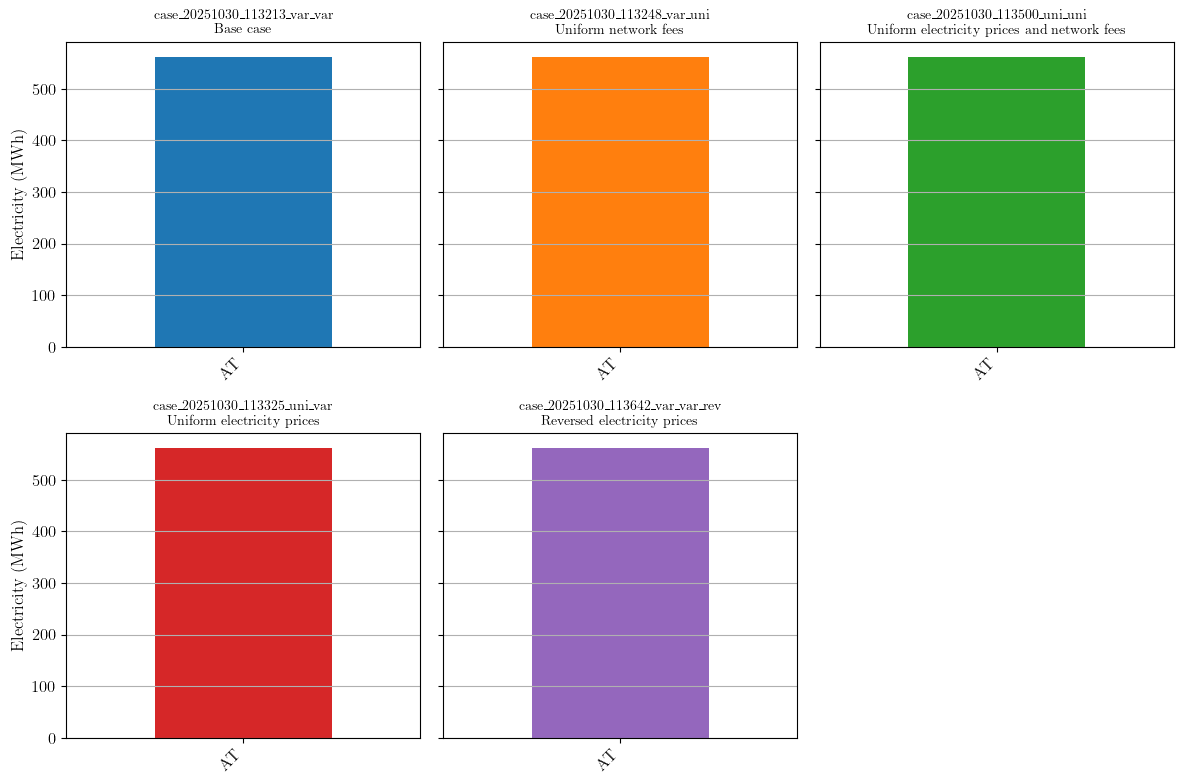

In [81]:
#
#
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharey=True)
axes = axes.ravel()

for i, (case_name, df) in enumerate(zip(case_study_names, electrification_per_country)):
    ax = axes[i]
    # filter for year 2030
    df_2030 = df[df['year'] == 2030]
    if df_2030.empty:
        ax.text(0.5, 0.5, "No data for 2030", ha='center', va='center')
        subtitle = case_study_name_labels.get(case_name, '')
        ax.set_title(f"{case_name}\n{subtitle}", fontsize=10)
        ax.set_xticks([])
        continue

    # aggregate in case of duplicates, then sort
    vals = df_2030.groupby('country')['electricity'].mean().sort_values(ascending=False)
    vals.plot(kind='bar', ax=ax, color='C{}'.format(i))

    # show both case name and human-friendly label (subtitle) in the subplot title
    subtitle = case_study_name_labels.get(case_name, '')
    if subtitle:
        ax.set_title(f"{case_name}\n{subtitle}", fontsize=10)
    else:
        ax.set_title(case_name)

    ax.set_xlabel('')
    ax.set_ylabel('Electricity (MWh)')
    ax.set_xticklabels(vals.index, rotation=45, ha='right')
    ax.grid(axis='y')

# hide any unused subplots (if any)
for j in range(len(case_study_names), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

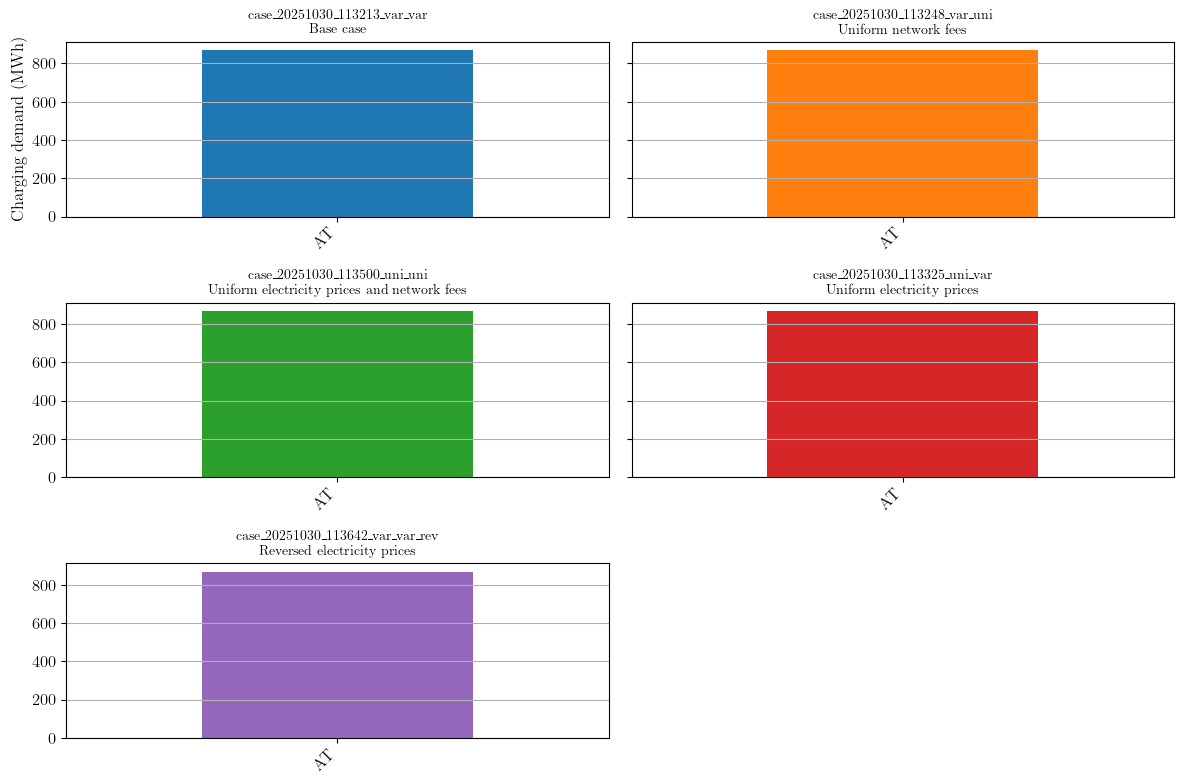

In [82]:
#
fig, axes = plt.subplots(3, 2, figsize=(12, 8), sharey=True)
axes = axes.ravel()

for i, (case_name, df) in enumerate(zip(case_study_names, electrification_per_country)):
    ax = axes[i]
    # filter for year 2030
    df_2030 = df[df['year'] == 2040]
    if df_2030.empty:
        ax.text(0.5, 0.5, "No data for 2030", ha='center', va='center')
        ax.set_title(case_name)
        ax.set_xticks([])
        continue

    # aggregate in case of duplicates, then sort
    vals = df_2030.groupby('country')['electricity'].mean().sort_values(ascending=False)
    vals.plot(kind='bar', ax=ax, color='C{}'.format(i))
    subtitle = case_study_name_labels.get(case_name, '')
    if subtitle:
        ax.set_title(f"{case_name}\n{subtitle}", fontsize=10)
    else:
        ax.set_title(case_name)
    ax.set_xlabel('')
    ax.set_ylabel('Charging demand (MWh)' if i == 0 else '')
    ax.set_xticklabels(vals.index, rotation=45, ha='right')
    ax.grid(axis='y')
# hide any unused subplots (if any)
for j in range(len(case_study_names), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.savefig("figures/electricity_charged_by_country_2040.pdf", dpi=300)

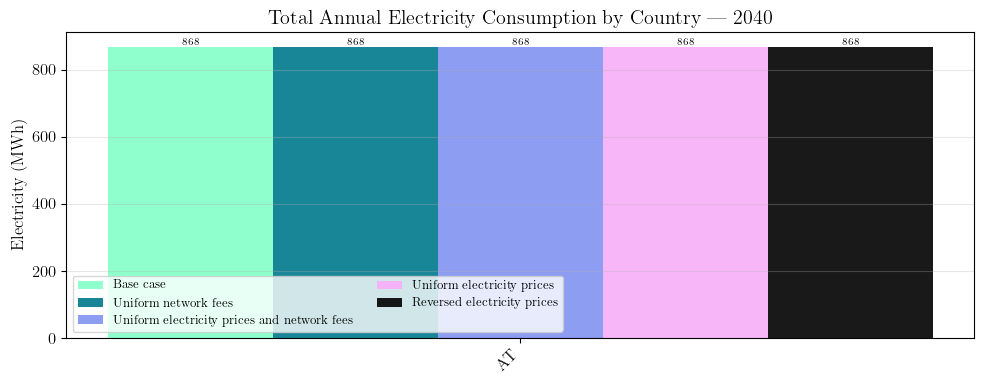

Saved: figures/electricity_by_country_2040_grouped_all_scenarios.pdf


In [84]:
# Grouped bar chart: for each country show 4 bars (one per scenario) side-by-side (default year = 2040)
year = 2040  # change if you want another year

colors = {
    "Base case": "#84ffc9",
    "Uniform network fees": "#00798c",
    "Uniform electricity prices": "#f7aef8",
    "Uniform electricity prices and network fees": "#8093f1"
}
# Collect per-scenario series (mean per country for border regions)
scenario_series = {}
countries_set = set()
for case_name, df in zip(case_study_names, electrification_per_country):
    if df is None or df.empty:
        continue
    s = df[df['year'] == year].groupby('country')['electricity'].mean()
    scenario_series[case_name] = s
    countries_set |= set(s.index)

countries = sorted(countries_set)
if len(countries) == 0:
    raise ValueError(f"No country data found for year {year} in electrification_per_country.")

# Build aligned DataFrame (countries x scenarios)
df_plot = pd.DataFrame({case: scenario_series.get(case, pd.Series(dtype=float)) for case in case_study_names})
df_plot = df_plot.reindex(index=countries).fillna(0)

# Plot grouped bars (one group per country, one bar per scenario)
n_scen = len(case_study_names)
x = np.arange(len(countries))
width = 0.8 / n_scen

fig, ax = plt.subplots(figsize=(max(10, len(countries) * 0.6), 4))
for i, case in enumerate(case_study_names):
    vals = df_plot[case].values
    offsets = (i - (n_scen - 1) / 2) * width
    bars = ax.bar(x + offsets, vals, width, label=case_study_name_labels.get(case, case), color=colors.get(case_study_name_labels.get(case, case), "#000000"), alpha=0.9)
    # value labels
    for j, v in enumerate(vals):
        if v != 0:
            ax.text(x[j] + offsets, v, f'{v:.0f}', ha='center', va='bottom', fontsize=7, rotation=0)

ax.set_xticks(x)
ax.set_xticklabels(countries, rotation=45, ha='right')
ax.set_ylabel('Electricity (MWh)')
ax.set_title(f'Total Annual Electricity Consumption by Country — {year}')
ax.legend(ncol=2, fontsize=9)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()

os.makedirs('figures', exist_ok=True)
outf = f'figures/electricity_by_country_{year}_grouped_all_scenarios.pdf'
plt.savefig(outf, dpi=300, bbox_inches='tight')
plt.show()

print(f"Saved: {outf}")

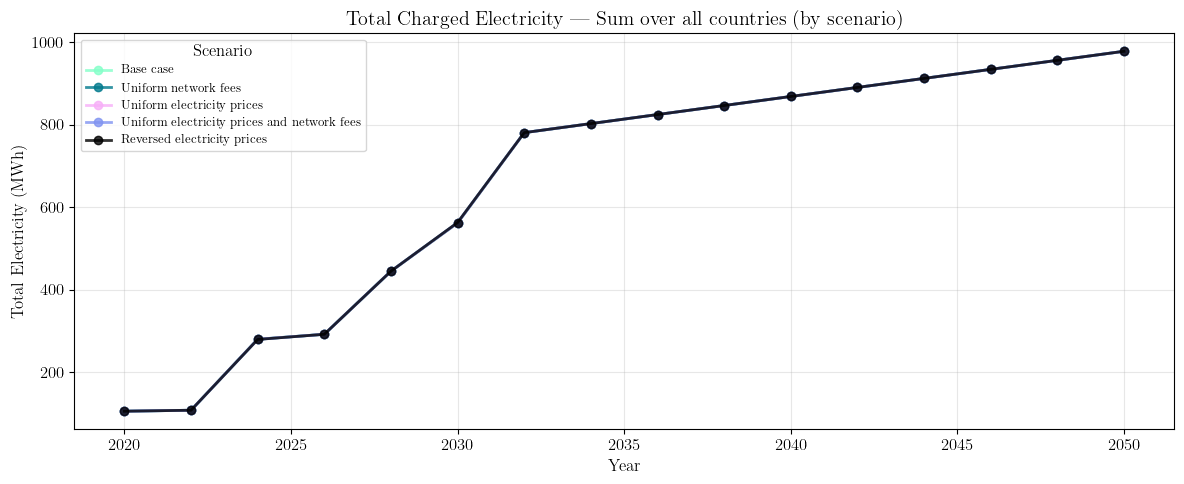

scenario  case_20251030_113213_var_var  case_20251030_113248_var_uni  \
year                                                                   
2020                        104.998876                    105.014320   
2022                        107.337643                    107.289213   
2024                        279.438854                    279.438823   
2026                        291.482013                    291.486230   
2028                        444.506692                    444.506669   
2030                        561.474168                    561.465680   
2032                        780.431427                    780.431427   
2034                        802.352573                    802.352572   
2036                        824.273713                    824.273712   
2038                        846.194854                    846.194853   
2040                        868.116002                    868.116004   
2042                        890.037149                    890.03

In [85]:
colors = {
    "Base case": "#84ffc9",
    "Uniform network fees": "#00798c",
    "Uniform electricity prices": "#f7aef8",
    "Uniform electricity prices and network fees": "#8093f1"
}

# Sum electricity across all countries per year and compare scenarios
records = []
for case_name, df in zip(case_study_names, electrification_per_country):
    if df is None or df.empty:
        continue
    yearly = df.groupby('year')['electricity'].sum().rename('total_electricity_MWh')
    for year, val in yearly.items():
        records.append({'scenario': case_name, 'year': int(year), 'total_electricity_MWh': float(val)})

df_total_by_year = pd.DataFrame(records)

# Pivot so years are index and scenarios are columns
pivot_total = df_total_by_year.pivot(index='year', columns='scenario', values='total_electricity_MWh').sort_index()

# Plot
fig, ax = plt.subplots(figsize=(12, 5))
for scen in pivot_total.columns:
    label = case_study_name_labels.get(scen, scen)
    ax.plot(pivot_total.index, pivot_total[scen], marker='o', linewidth=2, label=label, alpha=0.8, color=colors.get(label, "#000000"))

ax.set_xlabel('Year')
ax.set_ylabel('Total Electricity (MWh)')
ax.set_title('Total Charged Electricity — Sum over all countries (by scenario)')
ax.legend(title='Scenario', loc='best', fontsize=9)
ax.grid(alpha=0.3)
plt.tight_layout()

# save and show
os.makedirs('figures', exist_ok=True)
plt.savefig('figures/total_electricity_by_year_comparison.pdf', bbox_inches='tight')
plt.show()

# Display the pivot table for reference
print(pivot_total)

Saved vehicle stats for case_20251030_113213_var_var -> figures\vehicles_by_tech_case_20251030_113213_var_var.csv
Saved vehicle stats for case_20251030_113248_var_uni -> figures\vehicles_by_tech_case_20251030_113248_var_uni.csv
Saved vehicle stats for case_20251030_113500_uni_uni -> figures\vehicles_by_tech_case_20251030_113500_uni_uni.csv
Saved vehicle stats for case_20251030_113325_uni_var -> figures\vehicles_by_tech_case_20251030_113325_uni_var.csv
Saved vehicle stats for case_20251030_113642_var_var_rev -> figures\vehicles_by_tech_case_20251030_113642_var_var_rev.csv
Saved aggregated file: figures/vehicles_by_tech_all_cases.csv
Saved plot -> figures\h_all_by_tech_by_case.png


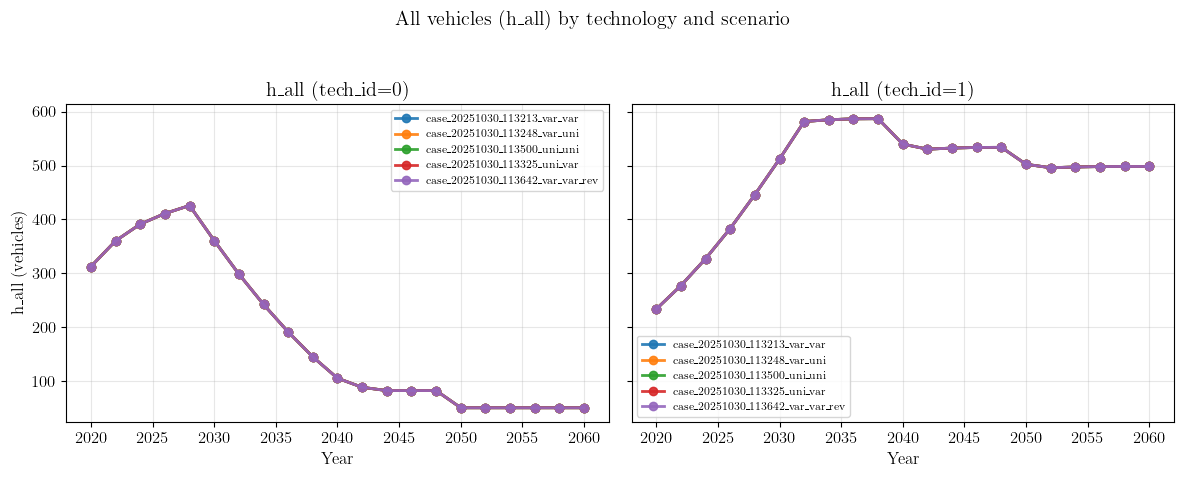

No tech metadata found in loaded_runs. Plotting all techs.
Saved plot -> figures\h_all_grouped_bar_by_year_electric_only.png


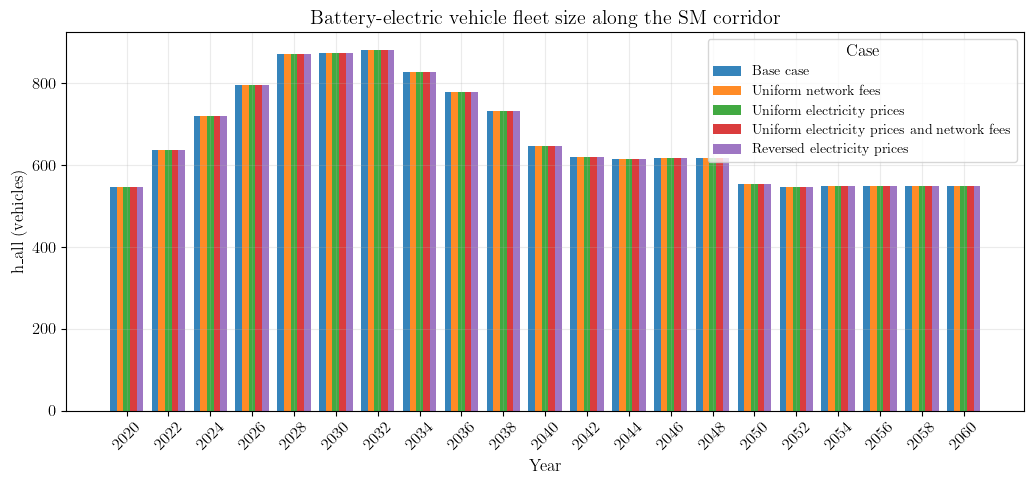

In [86]:
import os
import numpy as np
import seaborn as sns
from collections import defaultdict

# Aggregate per-technology vehicle statistics for each case and save results

vehicles_by_case = {}

for case_name, case_data in loaded_runs.items():
    input_data = case_data.get("input_data", {})
    output_data = case_data.get("output_data", {})

    # gather years from available output variables
    year_keys = set()
    for var in ("h", "h_plus", "h_exist", "h_minus"):
        for k in output_data.get(var, {}).keys():
            try:
                year_keys.add(int(k[0]))
            except Exception:
                pass
    if len(year_keys) == 0:
        years = list(range(2020, 2051, 2))
    else:
        years = sorted(year_keys)

    # infer tech ids and odpair ids from keys present in output variables
    tech_ids = set()
    odpair_ids = set()
    gen_ids = set()
    for var in ("h", "h_plus", "h_exist", "h_minus"):
        for k in output_data.get(var, {}).keys():
            if not isinstance(k, tuple) or len(k) < 3:
                continue
            tech_ids.add(k[2])
            odpair_ids.add(k[1])
            gen_ids.add(k[-1])

    # fallback to empty sets -> nothing to compute
    tech_ids = sorted(tech_ids)
    odpair_ids = sorted(odpair_ids)
    if len(gen_ids) > 0:
        g_init = int(min(gen_ids))
    else:
        g_init = 0

    # create minimal mapping objects so code below can use .keys() like before
    techvehicle_list = {tid: None for tid in tech_ids}
    odpair_list = {rid: None for rid in odpair_ids}

    # prepare dictionaries (year keys ensured)
    bought_vehicles_by_tech = {tech_id: {year: 0 for year in years} for tech_id in techvehicle_list.keys()}
    exiting_vehicles_by_tech = {tech_id: {year: 0 for year in years} for tech_id in techvehicle_list.keys()}
    h_now_by_tech = {tech_id: {year: 0 for year in years} for tech_id in techvehicle_list.keys()}
    h_all_by_tech = {tech_id: {year: 0 for year in years} for tech_id in techvehicle_list.keys()}

    # local shortcuts to avoid KeyError
    h_plus = output_data.get("h_plus", {})
    h_minus = output_data.get("h_minus", {})
    h_exist = output_data.get("h_exist", {})
    h_all = output_data.get("h", {})

    # Calculate values for each technology and year
    for y in years:
        for tech_id in techvehicle_list.keys():
            bought_vehicles_by_tech[tech_id][y] = sum(
                h_plus.get((y, r, tech_id, g), 0.0)
                for g in range(g_init, y + 1)
                for r in odpair_list.keys()
            )
            exiting_vehicles_by_tech[tech_id][y] = sum(
                h_minus.get((y, r, tech_id, g), 0.0)
                for g in range(g_init, y + 1)
                for r in odpair_list.keys()
            )
            h_now_by_tech[tech_id][y] = sum(
                h_exist.get((y, r, tech_id, g), 0.0)
                for g in range(g_init, y + 1)
                for r in odpair_list.keys()
            )
            h_all_by_tech[tech_id][y] = sum(
                h_all.get((y, r, tech_id, g), 0.0)
                for g in range(g_init, y + 1)
                for r in odpair_list.keys()
            )

    # convert to tidy DataFrame for easier storage / plotting
    rows = []
    for tech_id in techvehicle_list.keys():
        for y in years:
            rows.append({
                "case": case_name,
                "tech_id": tech_id,
                "year": int(y),
                "bought_vehicles": float(bought_vehicles_by_tech[tech_id].get(y, 0.0)),
                "exiting_vehicles": float(exiting_vehicles_by_tech[tech_id].get(y, 0.0)),
                "h_now": float(h_now_by_tech[tech_id].get(y, 0.0)),
                "h_all": float(h_all_by_tech[tech_id].get(y, 0.0))
            })

    df_stats = pd.DataFrame(rows)

    # store in memory and export CSV for each case
    vehicles_by_case[case_name] = {
        "bought_vehicles_by_tech": bought_vehicles_by_tech,
        "exiting_vehicles_by_tech": exiting_vehicles_by_tech,
        "h_now_by_tech": h_now_by_tech,
        "h_all_by_tech": h_all_by_tech,
        "df": df_stats
    }
    loaded_runs[case_name]["vehicle_stats"] = vehicles_by_case[case_name]

    os.makedirs("figures", exist_ok=True)
    out_csv = os.path.join("figures", f"vehicles_by_tech_{case_name}.csv")
    df_stats.to_csv(out_csv, index=False)
    print(f"Saved vehicle stats for {case_name} -> {out_csv}")

# summary variable for further use
vehicles_by_case_df = pd.concat([v["df"] for v in vehicles_by_case.values()], ignore_index=True) if vehicles_by_case else pd.DataFrame()
#vehicles_by_case_df.to_csv("figures/vehicles_by_tech_all_cases.csv", index=False)
print("Saved aggregated file: figures/vehicles_by_tech_all_cases.csv")

# Plot h_all_by_tech for each technology (one subplot per tech) across scenarios
import matplotlib.pyplot as plt

if vehicles_by_case_df.empty:
    print("No vehicle stats available to plot.")
else:
    tech_ids_plot = sorted(vehicles_by_case_df['tech_id'].unique())
    cases = vehicles_by_case_df['case'].unique()
    cmap = plt.get_cmap('tab10')

    n = max(1, len(tech_ids_plot))
    fig, axes = plt.subplots(1, n, figsize=(6 * n, 5), sharey=True)
    if n == 1:
        axes = [axes]

    for i, tech_id in enumerate(tech_ids_plot):
        ax = axes[i]
        for j, case_name in enumerate(cases):
            df_case = vehicles_by_case_df[
                (vehicles_by_case_df['case'] == case_name) &
                (vehicles_by_case_df['tech_id'] == tech_id)
            ]
            if df_case.empty:
                continue
            df_case = df_case.sort_values('year')
            ax.plot(df_case['year'], df_case['h_all'], marker='o', linewidth=2,
                    label=case_name, color=cmap(j % 10), alpha=0.9)

        ax.set_title(f"h_all (tech_id={tech_id})")
        ax.set_xlabel("Year")
        if i == 0:
            ax.set_ylabel("h_all (vehicles)")
        ax.grid(alpha=0.3)
        ax.legend(fontsize=8, loc='best')

    plt.suptitle("All vehicles (h_all) by technology and scenario")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    os.makedirs("figures", exist_ok=True)
    out_path = os.path.join("figures", "h_all_by_tech_by_case.png")
    plt.savefig(out_path, bbox_inches='tight', dpi=150)
    print(f"Saved plot -> {out_path}")
    plt.show()

# Filter to electricity-fueled technologies and plot h_all grouped bars by year and case

def _find_electric_tech_ids(loaded_runs):
    electric_ids = set()
    checked = False
    for case in loaded_runs.values():
        inp = case.get("input_data", {}) or {}
        for key in ("techvehicle", "techvehicles", "technologies", "techs", "vehicle_types", "vehicles"):
            items = inp.get(key)
            if items is None:
                continue
            checked = True
            # pandas DataFrame
            if hasattr(items, "iterrows"):
                for _, row in items.iterrows():
                    rid = None
                    for idcol in ("tech_id", "id", "idx", "index"):
                        if idcol in row:
                            rid = row[idcol]
                            break
                    if rid is None and "name" in row:
                        # try to parse numeric prefix
                        try:
                            rid = int(row["name"].split("_")[0])
                        except Exception:
                            rid = None
                    fuel_val = None
                    for fcol in ("fuel", "fuel_type", "propulsion", "powertrain", "energy_source"):
                        if fcol in row:
                            fuel_val = row[fcol]
                            break
                    if rid is not None and isinstance(fuel_val, str) and "electr" in fuel_val.lower():
                        electric_ids.add(int(rid))
            # dict-like
            elif isinstance(items, dict):
                for rid, meta in items.items():
                    try:
                        rid_int = int(rid)
                    except Exception:
                        rid_int = None
                    fuel_val = None
                    if isinstance(meta, dict):
                        for fcol in ("fuel", "fuel_type", "propulsion", "powertrain", "energy_source"):
                            if fcol in meta:
                                fuel_val = meta[fcol]
                                break
                        if rid_int is None:
                            for idcol in ("id", "tech_id", "idx"):
                                if idcol in meta:
                                    try:
                                        rid_int = int(meta[idcol])
                                    except Exception:
                                        pass
                    if rid_int is not None and isinstance(fuel_val, str) and "electr" in fuel_val.lower():
                        electric_ids.add(int(rid_int))
            # list of dicts
            elif isinstance(items, list):
                for entry in items:
                    if not isinstance(entry, dict):
                        continue
                    rid = None
                    for idcol in ("tech_id", "id", "idx"):
                        if idcol in entry:
                            try:
                                rid = int(entry[idcol])
                                break
                            except Exception:
                                pass
                    fuel_val = None
                    for fcol in ("fuel", "fuel_type", "propulsion", "powertrain", "energy_source"):
                        if fcol in entry:
                            fuel_val = entry[fcol]
                            break
                    if rid is not None and isinstance(fuel_val, str) and "electr" in fuel_val.lower():
                        electric_ids.add(int(rid))
    return electric_ids, checked

if vehicles_by_case_df.empty:
    print("No vehicle stats available to plot.")
else:
    electric_ids, checked = _find_electric_tech_ids(loaded_runs)
    if not electric_ids:
        if checked:
            print("Warning: no electric technologies were detected in input_data. Plotting all techs.")
            df_plot = vehicles_by_case_df.copy()
        else:
            # fallback: attempt to detect electric tech by guessing common names in case there is a 'tech_name' column
            if "tech_name" in vehicles_by_case_df.columns:
                mask = vehicles_by_case_df["tech_name"].str.contains("electr|ev|battery", case=False, na=False)
                if mask.any():
                    df_plot = vehicles_by_case_df[mask].copy()
                    electric_ids = set(df_plot["tech_id"].unique())
                else:
                    print("No tech metadata found and no tech_name matches. Plotting all techs.")
                    df_plot = vehicles_by_case_df.copy()
            else:
                print("No tech metadata found in loaded_runs. Plotting all techs.")
                df_plot = vehicles_by_case_df.copy()
    else:
        df_plot = vehicles_by_case_df[vehicles_by_case_df["tech_id"].isin(sorted(electric_ids))].copy()
        if df_plot.empty:
            print(f"Detected electric tech ids {sorted(electric_ids)} but no matching rows in vehicles_by_case_df. Plotting all techs.")
            df_plot = vehicles_by_case_df.copy()
        else:
            print(f"Filtering to electric tech ids: {sorted(electric_ids)}")

    # Group h_all by year and case and plot grouped bars (one group per year, one bar per case)
    pivot = df_plot.pivot_table(index='year', columns='case', values='h_all', aggfunc='sum').sort_index()
    years = pivot.index.tolist()
    cases = pivot.columns.tolist()

    n_years = len(years)
    n_cases = len(cases)
    width = 0.8 / max(1, n_cases)
    x = np.arange(n_years)

    fig, ax = plt.subplots(figsize=(max(8, n_years * 0.5), 5))
    cmap = plt.get_cmap('tab10')
    for i, case in enumerate(cases):
        vals = pivot[case].values
        ax.bar(x + i * width, vals, width=width, label=case_study_name_labels[case], color=cmap(i % 10), alpha=0.9)

    ax.set_xticks(x + width * (n_cases - 1) / 2)
    ax.set_xticklabels([int(y) for y in years], rotation=45)
    ax.set_xlabel("Year")
    ax.set_ylabel("h_all (vehicles)")
    ax.set_title("Battery-electric vehicle fleet size along the SM corridor")
    ax.legend(title="Case", fontsize=10, loc='best')
    ax.grid(alpha=0.25)

    plt.tight_layout()
    os.makedirs("figures", exist_ok=True)
    out_path = os.path.join("figures", "h_all_grouped_bar_by_year_electric_only.png")
    plt.savefig(out_path, bbox_inches='tight', dpi=150)
    print(f"Saved plot -> {out_path}")
    plt.show()


In [ ]:
import sys
sys.path.insert(0, '.')  # Add current directory to path

from debug_bev_flows import debug_bev_flows

# Run the debug
debug_bev_flows(loaded_runs, target_year=2030)

Analyzing case: case_20251028_091344_var_var

STEP 1: Check flow data availability
Flow data found: 68133 entries

Sample flow keys (first 5):
  1. (2040, (0, 2006, 2006), (1, 1), 2040)
      Value: 1.072132
  2. (2052, (0, 2537, 2537), (1, 1), 2052)
      Value: 0.265499
  3. (2028, (0, 1183, 1183), (1, 1), 2028)
      Value: 0.899914
  4. (2040, (0, 2586, 2586), (1, 1), 2040)
      Value: 0.331439
  5. (2036, (0, 706, 706), (1, 1), 2036)
      Value: 0.290071

STEP 2: Check TechVehicle data
TechVehicle data found under key: 'TechVehicle'
TechVehicle data type: <class 'list'>
Number of tech vehicles: 2

Tech vehicle details:
  TV 0: ICEV (fuel: unknown)
  TV 1: BEV (fuel: unknown)

Found 0 BEV tech vehicle IDs: set()

STEP 3: Filter flows for target year and BEVs
Target year: 2030
BEV tech vehicle IDs: set()

Years found in flow data: [2020, 2022, 2024, 2026, 2028, 2030, 2032, 2034, 2036, 2038, 2040, 2042, 2044, 2046, 2048, 2050, 2052, 2054, 2056, 2058, 2060]
  Distribution: {2040: 31

CREATING BEV COUNTRY MATRIX

Step 1: Loading geographic and odpair mappings...
  Found 2853 odpairs
  Found 75 geographic elements

Step 2: Identifying BEV tech vehicles...
    Tech 0: fuel=diesel
    Tech 1: fuel=electricity
    TV 0 (ICEV): technology=0 -> fuel=diesel
    TV 1 (BEV): technology=1 -> fuel=electricity
      ✓ ELECTRIC!
    Tech 0: fuel=diesel
    Tech 1: fuel=electricity
    TV 0 (ICEV): technology=0 -> fuel=diesel
    TV 1 (BEV): technology=1 -> fuel=electricity
      ✓ ELECTRIC!
    Tech 0: fuel=diesel
    Tech 1: fuel=electricity
    TV 0 (ICEV): technology=0 -> fuel=diesel
    TV 1 (BEV): technology=1 -> fuel=electricity
      ✓ ELECTRIC!
    Tech 0: fuel=diesel
    Tech 1: fuel=electricity
    TV 0 (ICEV): technology=0 -> fuel=diesel
    TV 1 (BEV): technology=1 -> fuel=electricity
      ✓ ELECTRIC!
    Tech 0: fuel=diesel
    Tech 1: fuel=electricity
    TV 0 (ICEV): technology=0 -> fuel=diesel
    TV 1 (BEV): technology=1 -> fuel=electricity
      ✓ ELECTRIC!
  

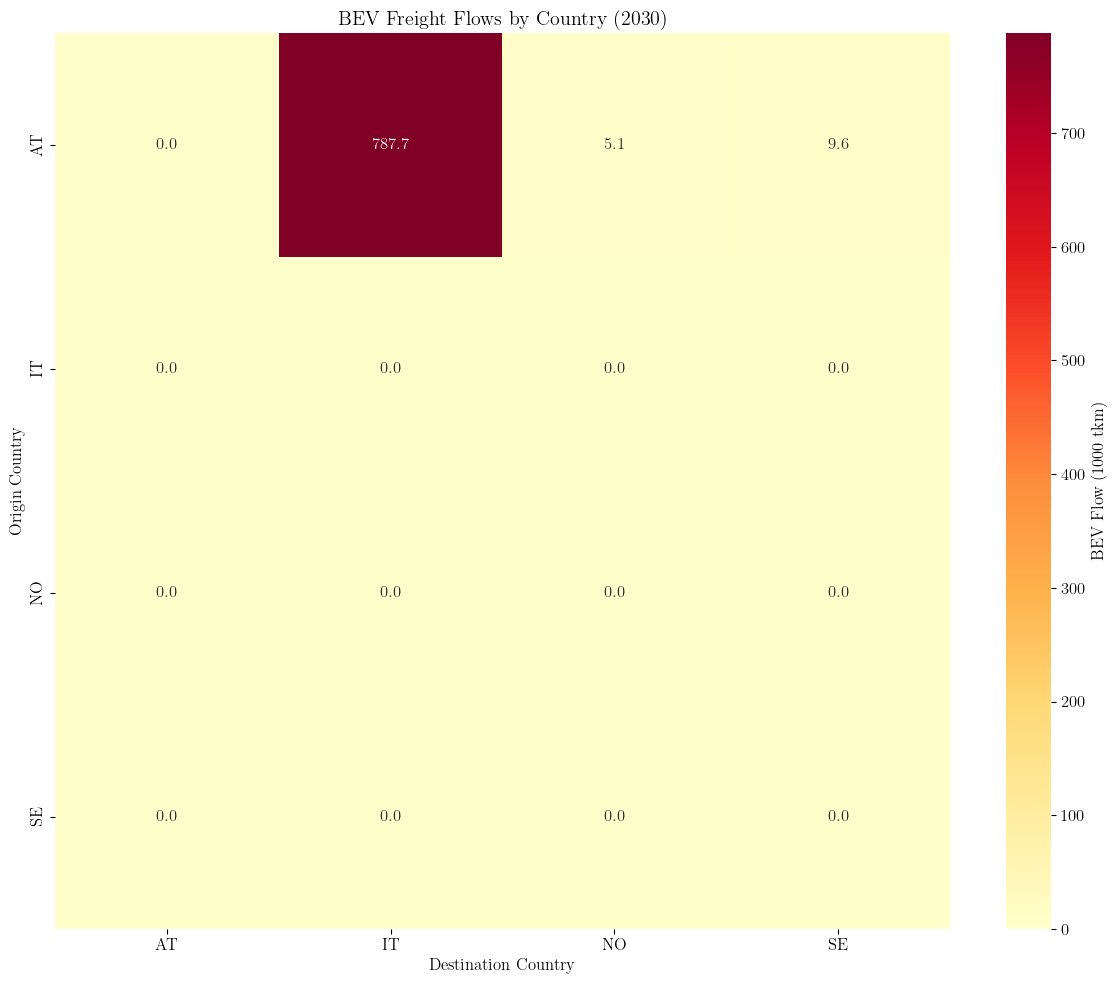

In [87]:
# Import the FIXED function
import sys
sys.path.insert(0, '.')
from bev_country_matrix_FIXED import create_bev_country_matrix_FIXED

# Create matrix for 2030
bev_matrix_2030 = create_bev_country_matrix_FIXED(loaded_runs, target_year=2034)

# Display
print(bev_matrix_2030)

# Visualize
import matplotlib.pyplot as plt
import seaborn as sns

if not bev_matrix_2030.empty:
    plt.figure(figsize=(12, 10))
    sns.heatmap(bev_matrix_2030, annot=True, fmt='.1f', cmap='YlOrRd',
                cbar_kws={'label': 'BEV Flow (1000 tkm)'})
    plt.title('BEV Freight Flows by Country (2030)')
    plt.xlabel('Destination Country')
    plt.ylabel('Origin Country')
    plt.tight_layout()
    plt.show()


YEAR: 2034
CREATING BEV MATRICES FOR ALL CASES (Year: 2034)

--- Processing: case_20251030_113213_var_var ---
CREATING BEV COUNTRY MATRIX

Step 1: Loading geographic and odpair mappings...
  Found 2853 odpairs
  Found 75 geographic elements

Step 2: Identifying BEV tech vehicles...
    Tech 0: fuel=diesel
    Tech 1: fuel=electricity
    TV 0 (ICEV): technology=0 -> fuel=diesel
    TV 1 (BEV): technology=1 -> fuel=electricity
      ✓ ELECTRIC!
    Tech 0: fuel=diesel
    Tech 1: fuel=electricity
    TV 0 (ICEV): technology=0 -> fuel=diesel
    TV 1 (BEV): technology=1 -> fuel=electricity
      ✓ ELECTRIC!
    Tech 0: fuel=diesel
    Tech 1: fuel=electricity
    TV 0 (ICEV): technology=0 -> fuel=diesel
    TV 1 (BEV): technology=1 -> fuel=electricity
      ✓ ELECTRIC!
    Tech 0: fuel=diesel
    Tech 1: fuel=electricity
    TV 0 (ICEV): technology=0 -> fuel=diesel
    TV 1 (BEV): technology=1 -> fuel=electricity
      ✓ ELECTRIC!
    Tech 0: fuel=diesel
    Tech 1: fuel=electricity
   

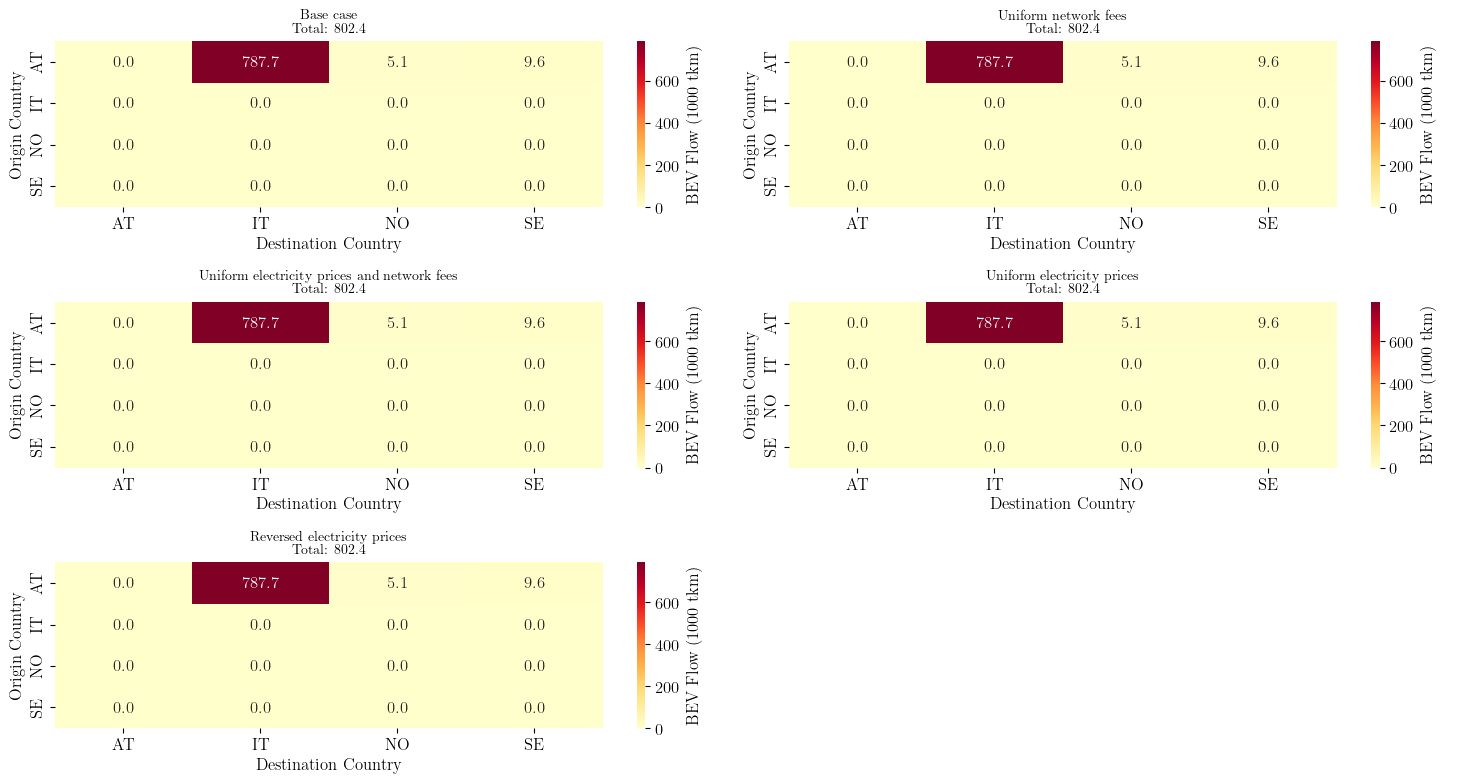

In [88]:
from bev_matrix_all_cases import create_bev_matrices_all_cases, compare_bev_matrices, plot_bev_matrices_comparison
# Force reload
if 'bev_matrix_all_cases' in sys.modules:
    importlib.reload(sys.modules['bev_matrix_all_cases'])
else:
    import bev_matrix_all_cases
for year in [2034]:
      print(f"\n{'='*80}")
      print(f"YEAR: {year}")
      print('='*80)

      matrices = create_bev_matrices_all_cases(loaded_runs, target_year=year)
      comparison = compare_bev_matrices(matrices)
      plot_bev_matrices_comparison(matrices, case_labels=case_study_name_labels, figsize=(15, 8))

In [ ]:

from border_region_electrification_analysis import (
    load_border_region_codes,
    calculate_electrification_by_country_border_only,
    compare_border_vs_all_electrification,
    analyze_border_region_electrification
)

# Load the border region codes
border_nuts2_codes = load_border_region_codes("border_nuts2_codes.txt")
print(f"Loaded {len(border_nuts2_codes)} border region codes:")
print(sorted(border_nuts2_codes))

Loaded 14 border region codes:
['AT31', 'AT32', 'AT33', 'AT34', 'DE14', 'DE21', 'DE22', 'DE27', 'DEF0', 'DK03', 'ITH1', 'ITH3', 'NO08', 'SE23']


In [ ]:
electrification_per_country_border = []

for run in loaded_runs:
    input_data = loaded_runs[run]["input_data"]
    output_data = loaded_runs[run]["output_data"]

    df_electrification_border, _, skip_counters = calculate_electrification_by_country_border_only(
        input_data,
        output_data,
        border_nuts2_codes,
        years_to_plot=range(2020, 2051, 2)
    )

    electrification_per_country_border.append(df_electrification_border)

    print(f"\n{run}:")
    print(f"  Entries processed for border regions: {len(df_electrification_border)}")
    print(f"  Entries filtered out (not border): {skip_counters['not_border_region']}")
    print(df_electrification_border.head())


case_20251028_091344_var_var:
  Entries processed for border regions: 96
  Entries filtered out (not border): 41224
  country  year  electrification_pct   total_fuel  electricity region_type
0      AT  2042           100.000000  5266.118203  5266.118203      border
1      AT  2044           100.000000  5395.819910  5395.819910      border
2      AT  2046           100.000000  5525.521616  5525.521616      border
3      AT  2040           100.000000  5136.416489  5136.416489      border
4      AT  2036            99.359856  4877.013067  4845.793162      border

case_20251028_091411_var_uni:
  Entries processed for border regions: 96
  Entries filtered out (not border): 41146
  country  year  electrification_pct   total_fuel  electricity region_type
0      AT  2042           100.000000  5266.118203  5266.118203      border
1      AT  2044           100.000000  5395.819910  5395.819910      border
2      AT  2046           100.000000  5525.521616  5525.521616      border
3      AT  2040 

In [ ]:
print("\nComparing Border vs All Regions for first scenario:")
run_name = list(loaded_runs.keys())[0]
input_data = loaded_runs[run_name]["input_data"]
output_data = loaded_runs[run_name]["output_data"]

df_comparison = compare_border_vs_all_electrification(
    input_data,
    output_data,
    border_nuts2_codes,
    years_to_plot=[2030, 2040]
)

print("\nComparison data:")
print(df_comparison.pivot_table(
    index=['country', 'year'],
    columns='region_type',
    values='electrification_pct'
))


Comparing Border vs All Regions for first scenario:

Comparison data:
region_type          all      border
country year                        
AT      2030   82.558719   82.558719
        2040  100.000000  100.000000
DE      2030   31.407708   27.043118
        2040   88.841828   88.553399
DK      2030   77.266010   53.070764
        2040  100.000000  100.000000
IT      2030   29.441564   23.502286
        2040   89.569979   98.497988
NO      2030  100.000000  100.000000
        2040  100.000000  100.000000
SE      2030  100.000000  100.000000
        2040  100.000000  100.000000


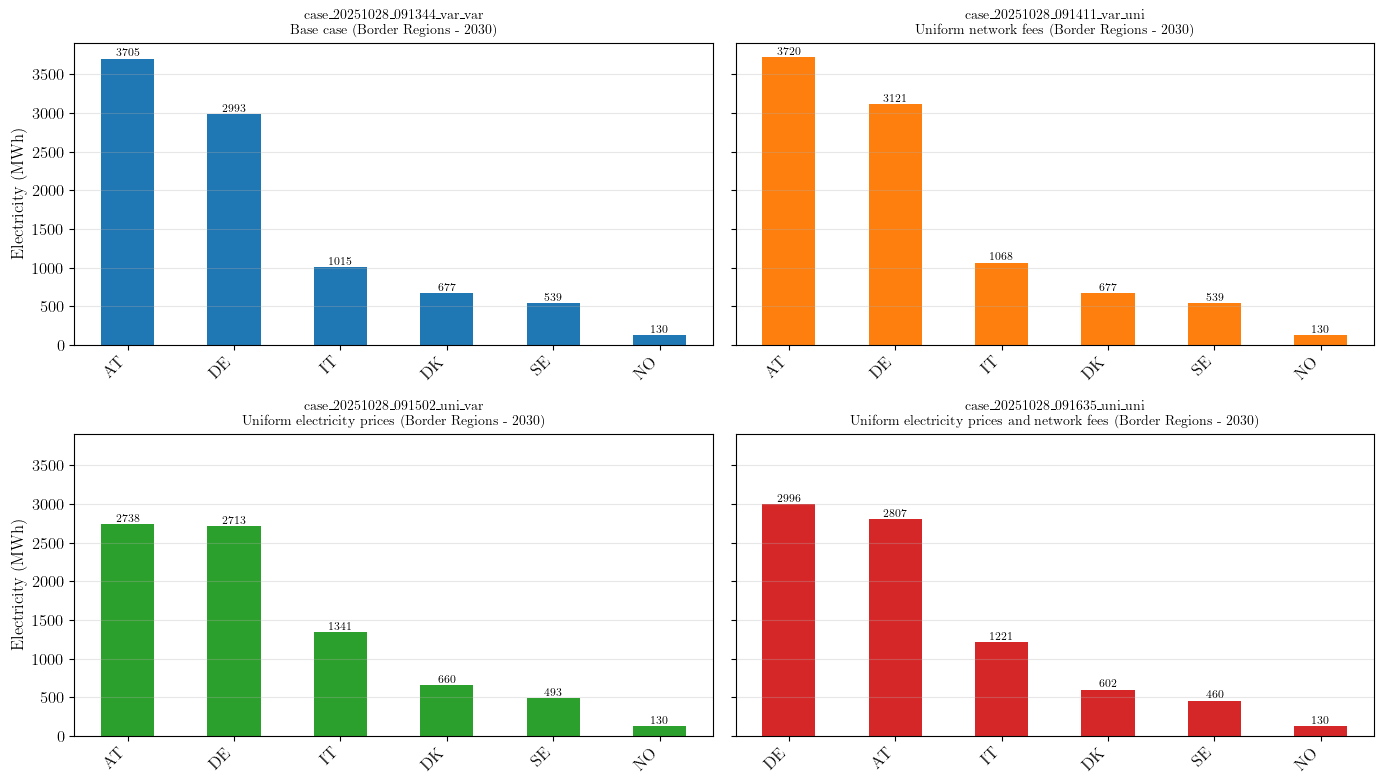

Saved: border_regions_electricity_2030.pdf


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharey=True)
axes = axes.ravel()

for i, (case_name, df) in enumerate(zip(case_study_names, electrification_per_country_border)):
    ax = axes[i]

    # Filter for year 2030
    df_2030 = df[df['year'] == 2030]

    if df_2030.empty:
        ax.text(0.5, 0.5, "No data for 2030", ha='center', va='center')
        ax.set_title(f'{case_name}\n(Border Regions)')
        ax.set_xticks([])
        continue

    # Aggregate and sort
    vals = df_2030.groupby('country')['electricity'].mean().sort_values(ascending=False)

    if len(vals) == 0:
        ax.text(0.5, 0.5, "No border data", ha='center', va='center')
        ax.set_title(f'{case_name}\n(Border Regions)')
        continue

    # Plot
    vals.plot(kind='bar', ax=ax, color=f'C{i}')
    subtitle = case_study_name_labels.get(case_name, '')
    if subtitle:
        ax.set_title(f"{case_name}\n{subtitle} (Border Regions - 2030)", fontsize=10)
    else:
        ax.set_title(f"{case_name} (Border Regions - 2030)", fontsize=10)
    ax.set_xlabel('')
    ax.set_ylabel('Electricity (MWh)' if i % 2 == 0 else '')
    ax.set_xticklabels(vals.index, rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for j, (idx, val) in enumerate(vals.items()):
        ax.text(j, val, f'{val:.0f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('figures/border_regions_electricity_2030.pdf', bbox_inches='tight')
plt.show()

print("Saved: border_regions_electricity_2030.pdf")

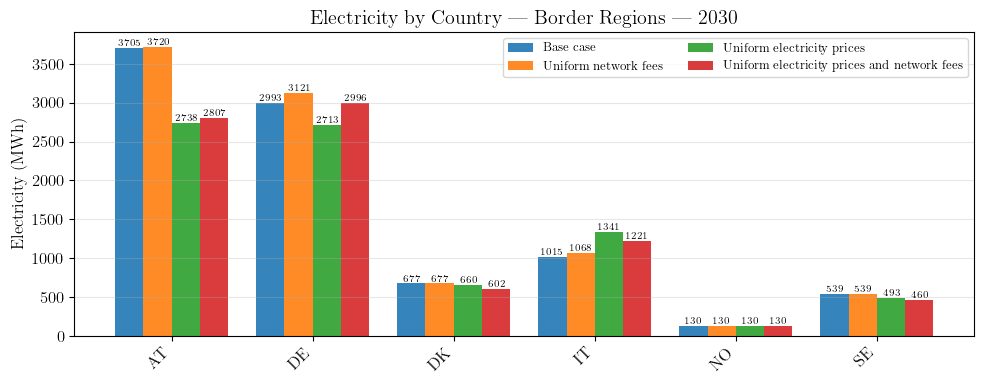

Saved: figures/electricity_by_country_2030_all_scenarios.pdf


In [ ]:
# Grouped bar chart: for each country show 4 bars (one per scenario) side-by-side
year = 2030  # change if you want another year

# Collect per-scenario series (mean per country like previous plots)
scenario_series = {}
countries_set = set()
for case_name, df in zip(case_study_names, electrification_per_country_border):
    if df is None or df.empty:
        continue
    s = df[df['year'] == year].groupby('country')['electricity'].mean()
    scenario_series[case_name] = s
    countries_set |= set(s.index)

countries = sorted(countries_set)
if len(countries) == 0:
    raise ValueError(f"No country data found for year {year} in electrification_per_country_border.")

# Build aligned DataFrame (countries x scenarios)
df_plot = pd.DataFrame({case: scenario_series.get(case, pd.Series(dtype=float)) for case in case_study_names})
df_plot = df_plot.reindex(index=countries).fillna(0)

# Plot grouped bars (4 bars per country)
n_scen = len(case_study_names)
x = np.arange(len(countries))
width = 0.8 / n_scen

fig, ax = plt.subplots(figsize=(max(10, len(countries) * 0.6), 4))
for i, case in enumerate(case_study_names):
    vals = df_plot[case].values
    offsets = (i - (n_scen - 1) / 2) * width
    bars = ax.bar(x + offsets, vals, width, label=case_study_name_labels.get(case, case), color=f'C{i}', alpha=0.9)
    # value labels
    for j, v in enumerate(vals):
        if v != 0:
            ax.text(x[j] + offsets, v, f'{v:.0f}', ha='center', va='bottom', fontsize=7)

ax.set_xticks(x)
ax.set_xticklabels(countries, rotation=45, ha='right')
ax.set_ylabel('Electricity (MWh)')
ax.set_title(f'Electricity by Country — Border Regions — {year}')
ax.legend(ncol=2, fontsize=9)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()

os.makedirs('figures', exist_ok=True)
outf = f'figures/electricity_by_country_{year}_all_scenarios.pdf'
plt.savefig(outf)
plt.show()

print(f"Saved: {outf}")

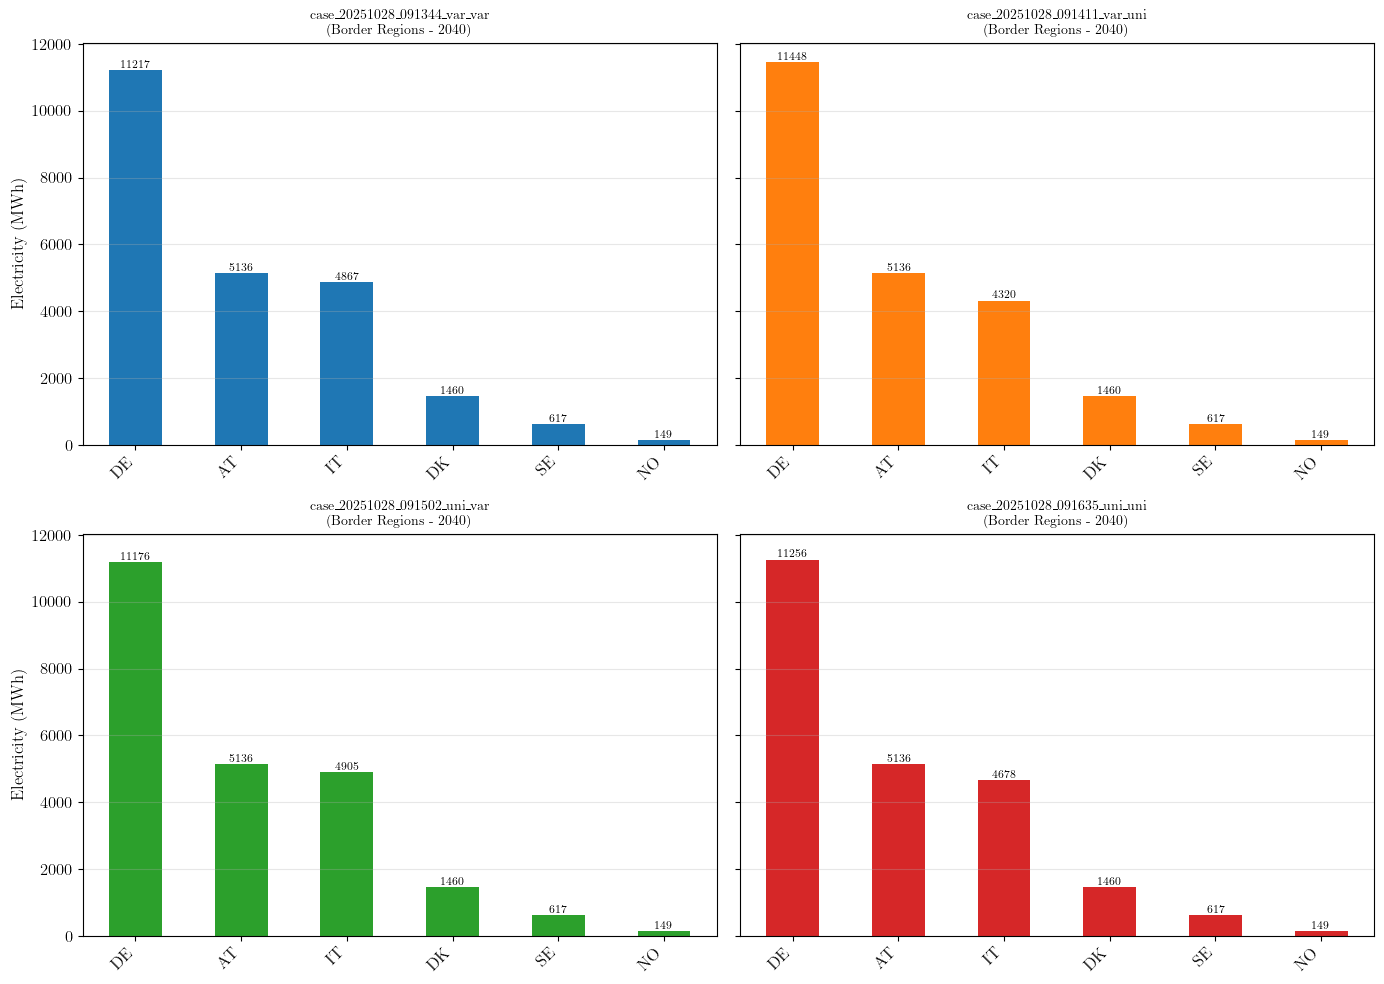

Saved: border_regions_electricity_2040.png


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)
axes = axes.ravel()

for i, (case_name, df) in enumerate(zip(case_study_names, electrification_per_country_border)):
    ax = axes[i]

    # Filter for year 2040
    df_2040 = df[df['year'] == 2040]

    if df_2040.empty:
        ax.text(0.5, 0.5, "No data for 2040", ha='center', va='center')
        ax.set_title(f'{case_name}\n(Border Regions)')
        ax.set_xticks([])
        continue

    # Aggregate and sort
    vals = df_2040.groupby('country')['electricity'].mean().sort_values(ascending=False)

    if len(vals) == 0:
        ax.text(0.5, 0.5, "No border data", ha='center', va='center')
        ax.set_title(f'{case_name}\n(Border Regions)')
        continue

    # Plot
    vals.plot(kind='bar', ax=ax, color=f'C{i}')
    ax.set_title(f'{case_name}\n(Border Regions - 2040)', fontsize=10)
    ax.set_xlabel('')
    ax.set_ylabel('Electricity (MWh)' if i % 2 == 0 else '')
    ax.set_xticklabels(vals.index, rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for j, (idx, val) in enumerate(vals.items()):
        ax.text(j, val, f'{val:.0f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('figures/border_regions_electricity_2040.pdf', bbox_inches='tight')
plt.show()

print("Saved: border_regions_electricity_2040.png")


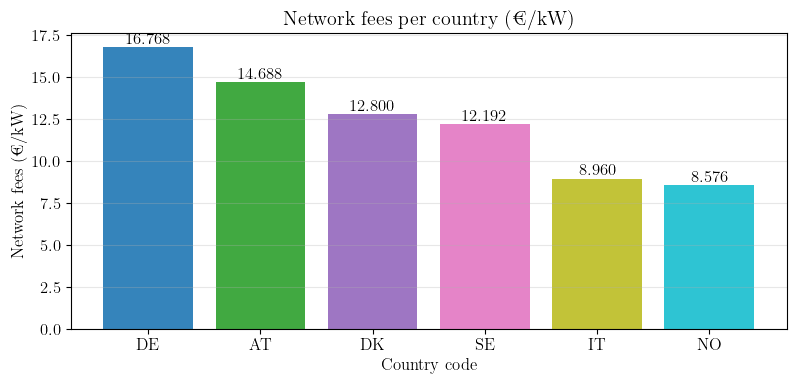

In [ ]:
network_fees = {'AT': 14.688000000000002, 'DK': 12.8, 'DE': 16.768, 'IT': 8.96, 'SE': 12.192, 'NO': 8.576}

# Bar plot of network fees (€/kW) per country
items = sorted(network_fees.items(), key=lambda x: x[1], reverse=True)
countries, fees = zip(*items)

fig, ax = plt.subplots(figsize=(8, 4))
cols = plt.cm.tab10(np.linspace(0, 1, len(countries)))
bars = ax.bar(countries, fees, color=cols, alpha=0.9)

# Annotate values
for bar, fee in zip(bars, fees):
    ax.text(bar.get_x() + bar.get_width() / 2, fee, f"{fee:.3f}", ha='center', va='bottom', fontsize=12)

ax.set_xlabel('Country code')
ax.set_ylabel('Network fees (€/kW)')
ax.set_title('Network fees per country (€/kW)')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
os.makedirs('figures', exist_ok=True)
plt.savefig('figures/network_fees_by_country.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
from sub_border_regions import (
    analyze_sub_border_regions,
    get_sub_border_region_info,
    SUB_BORDER_REGIONS,
    calculate_electrification_by_sub_border_region,
    plot_single_sub_region_detail
)
import pandas as pd
import matplotlib.pyplot as plt

# Display available sub-border region clusters
print("Available Sub-Border Region Clusters:")
df_info = get_sub_border_region_info()
display(df_info)

Available Sub-Border Region Clusters:


,cluster_name,description,num_regions,countries,regions
0,Austria-Germany-Italy,NUTS2 regions around Austria with adjacent Ger...,10,"AT, DE, IT","AT31, AT32, AT33, AT34, DE14, DE21, DE22, DE27..."
1,Germany-Denmark-Sweden,Cross-border cluster including all of Denmark ...,8,"DE, DK, SE","DEF0, DK01, DK02, DK03, DK04, DK05, SE22, SE23"
2,Denmark-Germany,NUTS2 regions connecting Denmark and Germany (...,2,"DE, DK","DEF0, DK03"
3,Norway-Sweden,NUTS2 regions connecting Norway and Sweden,2,"NO, SE","NO08, SE23"



Analyzing sub-region: Austria-Germany-Italy

SUB-BORDER REGION ELECTRIFICATION SUMMARY

Austria-Germany-Italy
--------------------------------------------------------------------------------
Description: NUTS2 regions around Austria with adjacent German and Italian regions
NUTS2 Regions: AT31, AT32, AT33, AT34, DE14, DE21, DE22, DE27, ITH1, ITH3
Countries: AT, DE, IT

  Year 2030:
    Countries with data: 3
    Average electrification: 44.95%
    Total electricity: 7181.14 MWh
    Total fuel consumption: 17357.06 MWh
    By country:
      DE: 28.78% (2461.21 / 8551.40 MWh)
      AT: 82.56% (3705.16 / 4487.91 MWh)
      IT: 23.50% (1014.77 / 4317.75 MWh)

  Year 2040:
    Countries with data: 3
    Average electrification: 94.76%
    Total electricity: 18398.62 MWh
    Total fuel consumption: 19865.17 MWh
    By country:
      DE: 85.77% (8394.75 / 9787.08 MWh)
      AT: 100.00% (5136.42 / 5136.42 MWh)
      IT: 98.50% (4867.45 / 4941.67 MWh)

  Year 2050:
    Countries with data: 3
  

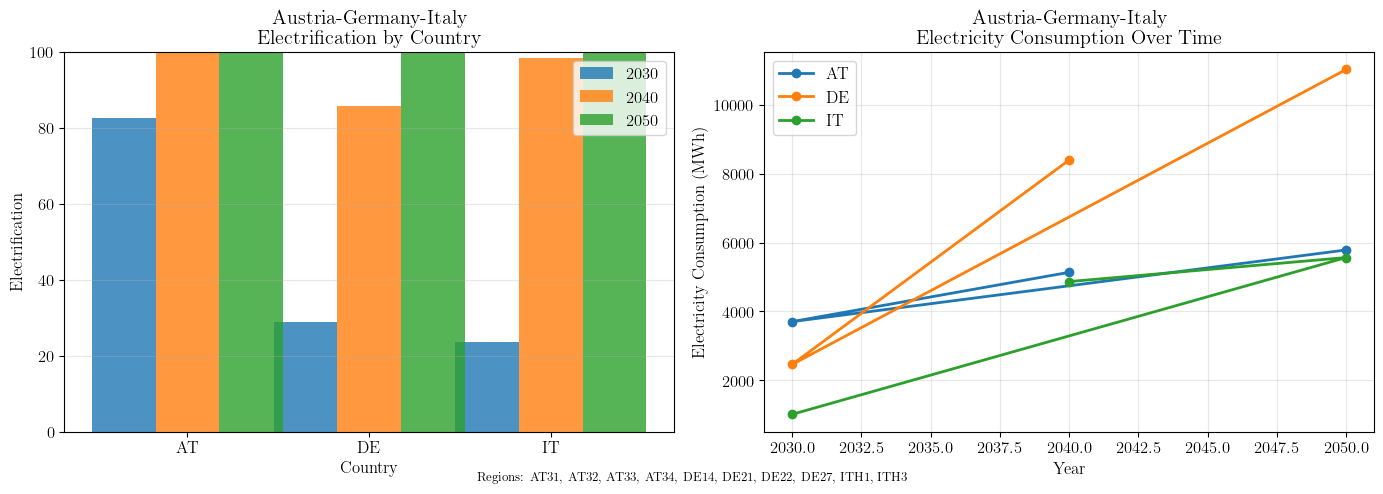


Austria-Germany-Italy Cluster Results:


,country,year,electrification_pct,total_fuel,electricity,region_type,sub_region
0,DE,2050,100.000000,11022.772944,11022.772944,border_Austria-Germany-Italy,Austria-Germany-Italy
1,DE,2030,28.781436,8551.396900,2461.214819,border_Austria-Germany-Italy,Austria-Germany-Italy
2,DE,2040,85.773794,9787.084924,8394.754047,border_Austria-Germany-Italy,Austria-Germany-Italy
3,AT,2040,100.000000,5136.416489,5136.416489,border_Austria-Germany-Italy,Austria-Germany-Italy
4,AT,2030,82.558719,4487.907931,3705.159311,border_Austria-Germany-Italy,Austria-Germany-Italy
5,AT,2050,100.000000,5784.925041,5784.925041,border_Austria-Germany-Italy,Austria-Germany-Italy
6,IT,2040,98.497988,4941.671707,4867.447187,border_Austria-Germany-Italy,Austria-Germany-Italy
7,IT,2050,100.000000,5565.592367,5565.592367,border_Austria-Germany-Italy,Austria-Germany-Italy
8,IT,2030,23.502286,4317.751033,1014.770179,border_Austria-Germany-Italy,Austria-Germany-Italy


In [ ]:
df_austria_cluster = analyze_sub_border_regions(
    input_data,
    output_data,
    years_to_plot=[2030, 2040, 2050],
    sub_region_name='Austria-Germany-Italy',
    show_plots=True,
    verbose=True
)

# Display results
print("\nAustria-Germany-Italy Cluster Results:")
display(df_austria_cluster)


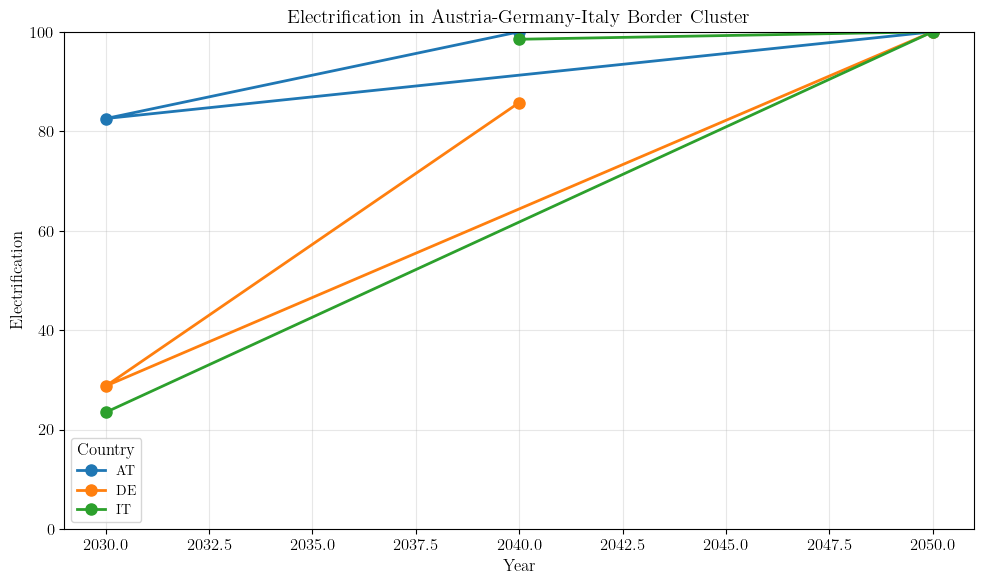

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

for country in sorted(df_austria_cluster['country'].unique()):
    country_data = df_austria_cluster[df_austria_cluster['country'] == country]
    ax.plot(country_data['year'], country_data['electrification_pct'],
           marker='o', label=country, linewidth=2, markersize=8)

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Electrification %', fontsize=12)
ax.set_title('Electrification in Austria-Germany-Italy Border Cluster', fontsize=14, fontweight='bold')
ax.legend(title='Country', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 100)

plt.tight_layout()
plt.show()

Processing sub-region: Austria-Germany-Italy...
  Found 9 country-year combinations
Processing sub-region: Germany-Denmark-Sweden...
  Found 9 country-year combinations
Processing sub-region: Denmark-Germany...
  Found 6 country-year combinations
Processing sub-region: Norway-Sweden...
  Found 6 country-year combinations

SUB-BORDER REGION ELECTRIFICATION SUMMARY

Austria-Germany-Italy
--------------------------------------------------------------------------------
Description: NUTS2 regions around Austria with adjacent German and Italian regions
NUTS2 Regions: AT31, AT32, AT33, AT34, DE14, DE21, DE22, DE27, ITH1, ITH3
Countries: AT, DE, IT

  Year 2030:
    Countries with data: 3
    Average electrification: 44.95%
    Total electricity: 7181.14 MWh
    Total fuel consumption: 17357.06 MWh
    By country:
      DE: 28.78% (2461.21 / 8551.40 MWh)
      AT: 82.56% (3705.16 / 4487.91 MWh)
      IT: 23.50% (1014.77 / 4317.75 MWh)

  Year 2040:
    Countries with data: 3
    Average electr

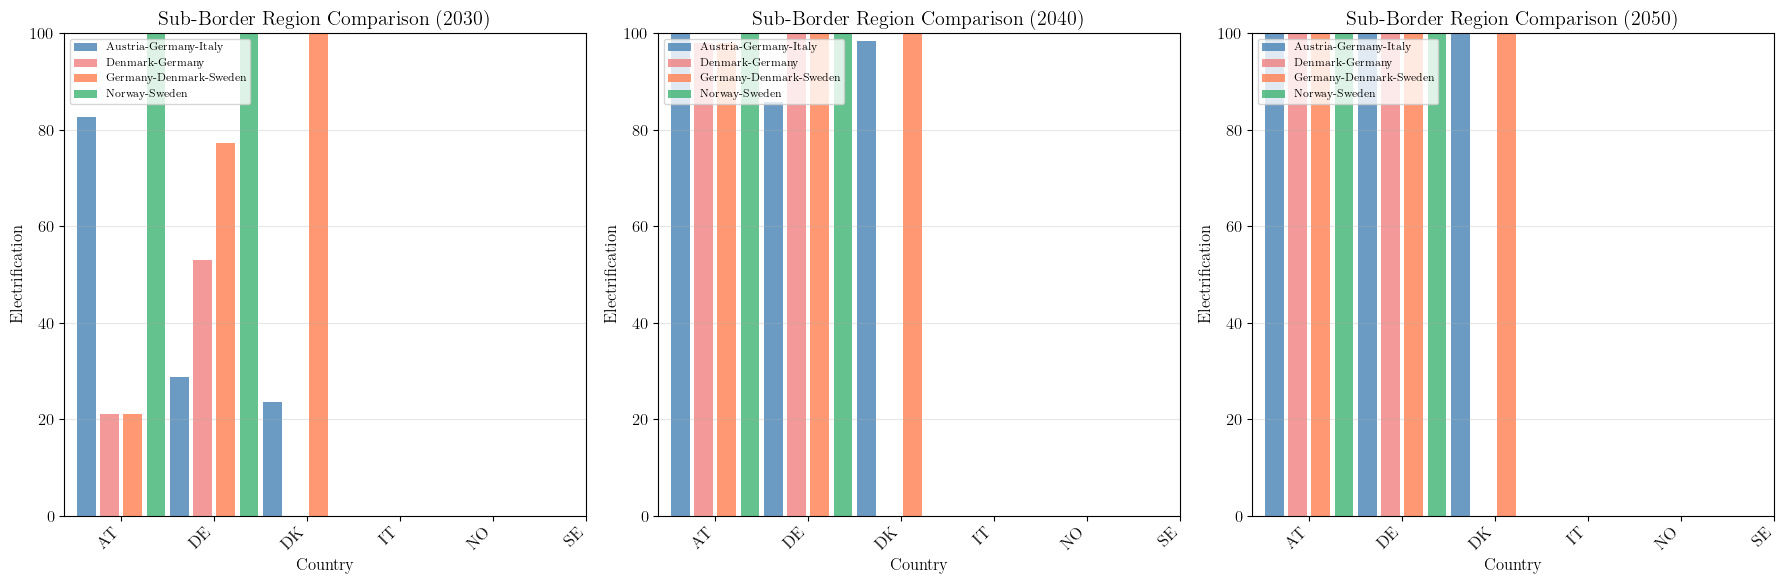

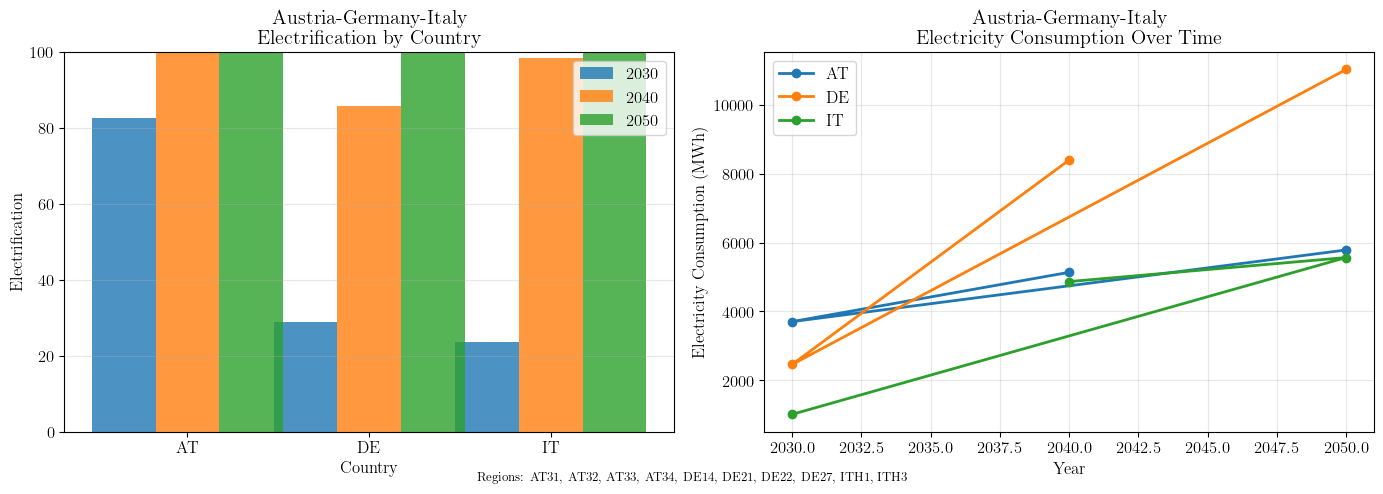

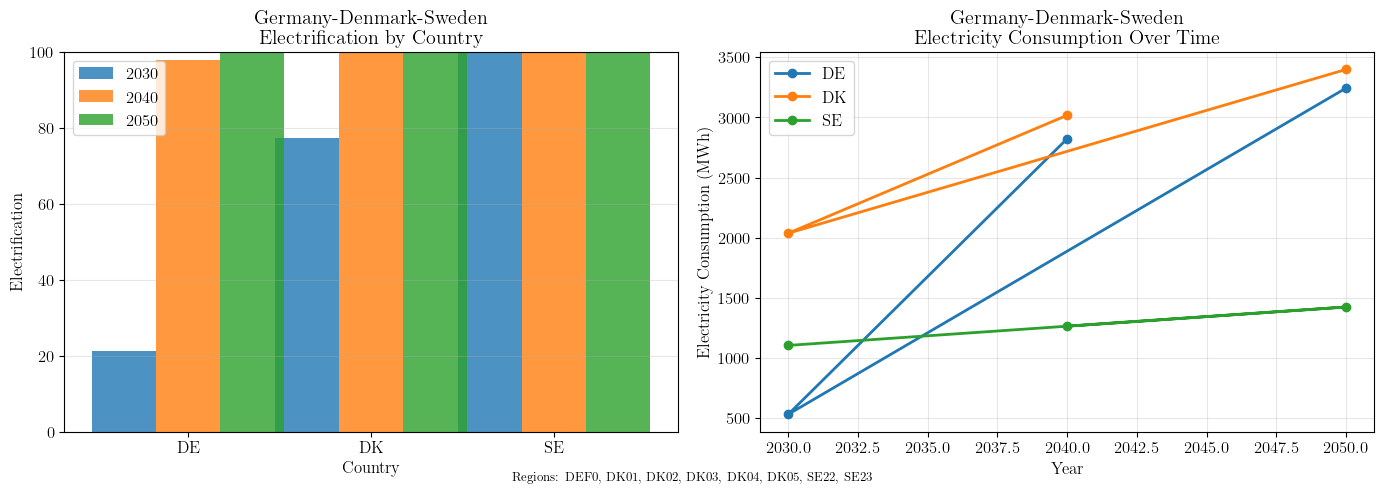

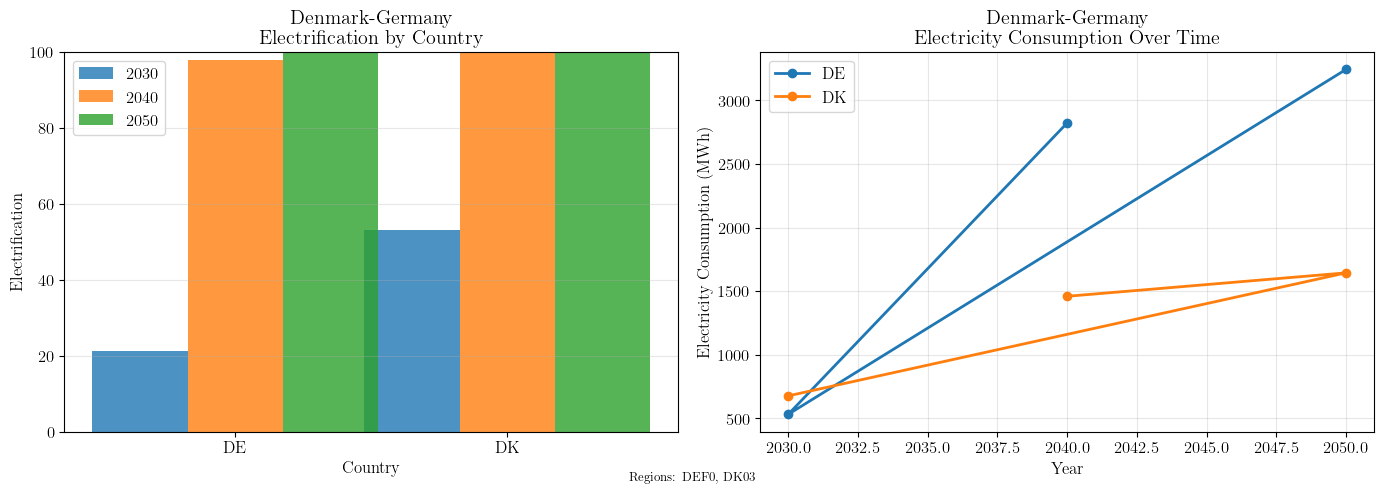

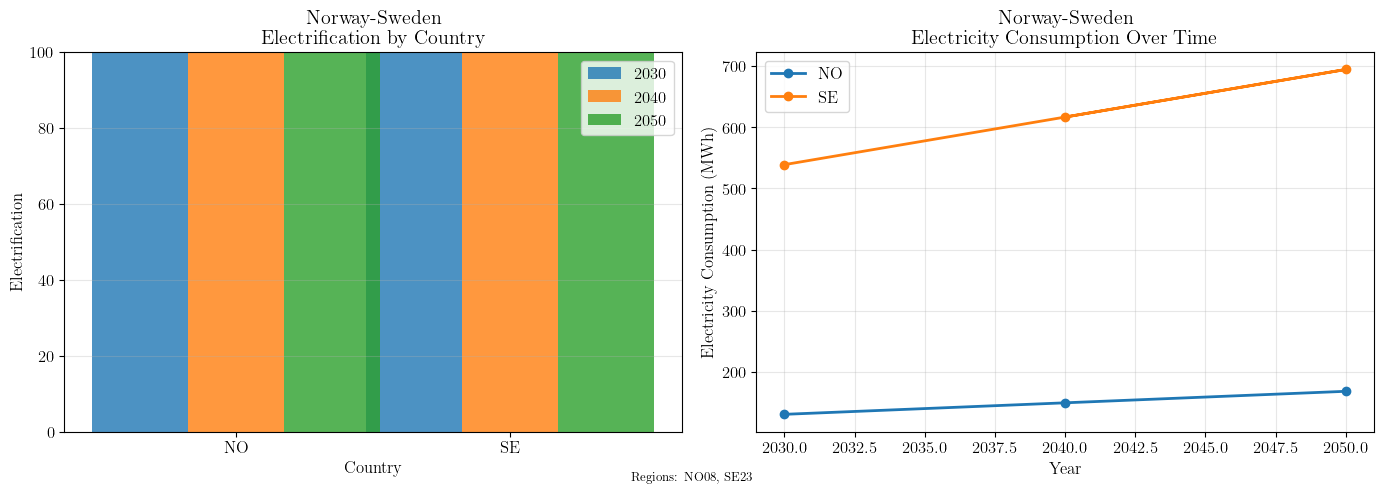


Summary by Sub-Border Region:


,Sub-Region,Year,Avg Electrification %,Total Electricity (MWh),Total Fuel (MWh)
0,Austria-Germany-Italy,2030,44.947480,7181.144309,17357.055864
1,Austria-Germany-Italy,2040,94.757260,18398.617723,19865.173120
2,Austria-Germany-Italy,2050,100.000000,22373.290352,22373.290352
3,Denmark-Germany,2030,37.103067,1208.757011,3791.755686
4,Denmark-Germany,2040,99.000004,4282.073773,4339.669330
5,Denmark-Germany,2050,100.000000,4887.582985,4887.582985
6,Germany-Denmark-Sweden,2030,66.133793,3673.807355,6257.601581
7,Germany-Denmark-Sweden,2040,99.333336,7104.237625,7161.833182
8,Germany-Denmark-Sweden,2050,100.000000,8066.064806,8066.064806
9,Norway-Sweden,2030,100.000000,669.393916,669.393916


In [ ]:
df_all_clusters, results_by_cluster = analyze_sub_border_regions(
    input_data,
    output_data,
    years_to_plot=[2030, 2040, 2050],
    show_plots=True,
    verbose=True
)

# Create summary comparison table
summary = df_all_clusters.groupby(['sub_region', 'year']).agg({
    'electrification_pct': 'mean',
    'electricity': 'sum',
    'total_fuel': 'sum'
}).reset_index()

summary.columns = ['Sub-Region', 'Year', 'Avg Electrification %',
                   'Total Electricity (MWh)', 'Total Fuel (MWh)']

print("\nSummary by Sub-Border Region:")
display(summary)

In [ ]:
austria_cluster_regions = SUB_BORDER_REGIONS['Austria-Germany-Italy']['regions']

print(f"Austria-Germany-Italy Cluster includes {len(austria_cluster_regions)} NUTS2 regions:")
print("\nBy country:")

# Organize by country
for country in ['AT', 'DE', 'IT']:
    country_regions = [r for r in sorted(austria_cluster_regions) if r.startswith(country)]
    print(f"\n{country}: {len(country_regions)} regions")
    for region in country_regions:
        print(f"  - {region}")

Austria-Germany-Italy Cluster includes 10 NUTS2 regions:

By country:

AT: 4 regions
  - AT31
  - AT32
  - AT33
  - AT34

DE: 4 regions
  - DE14
  - DE21
  - DE22
  - DE27

IT: 2 regions
  - ITH1
  - ITH3


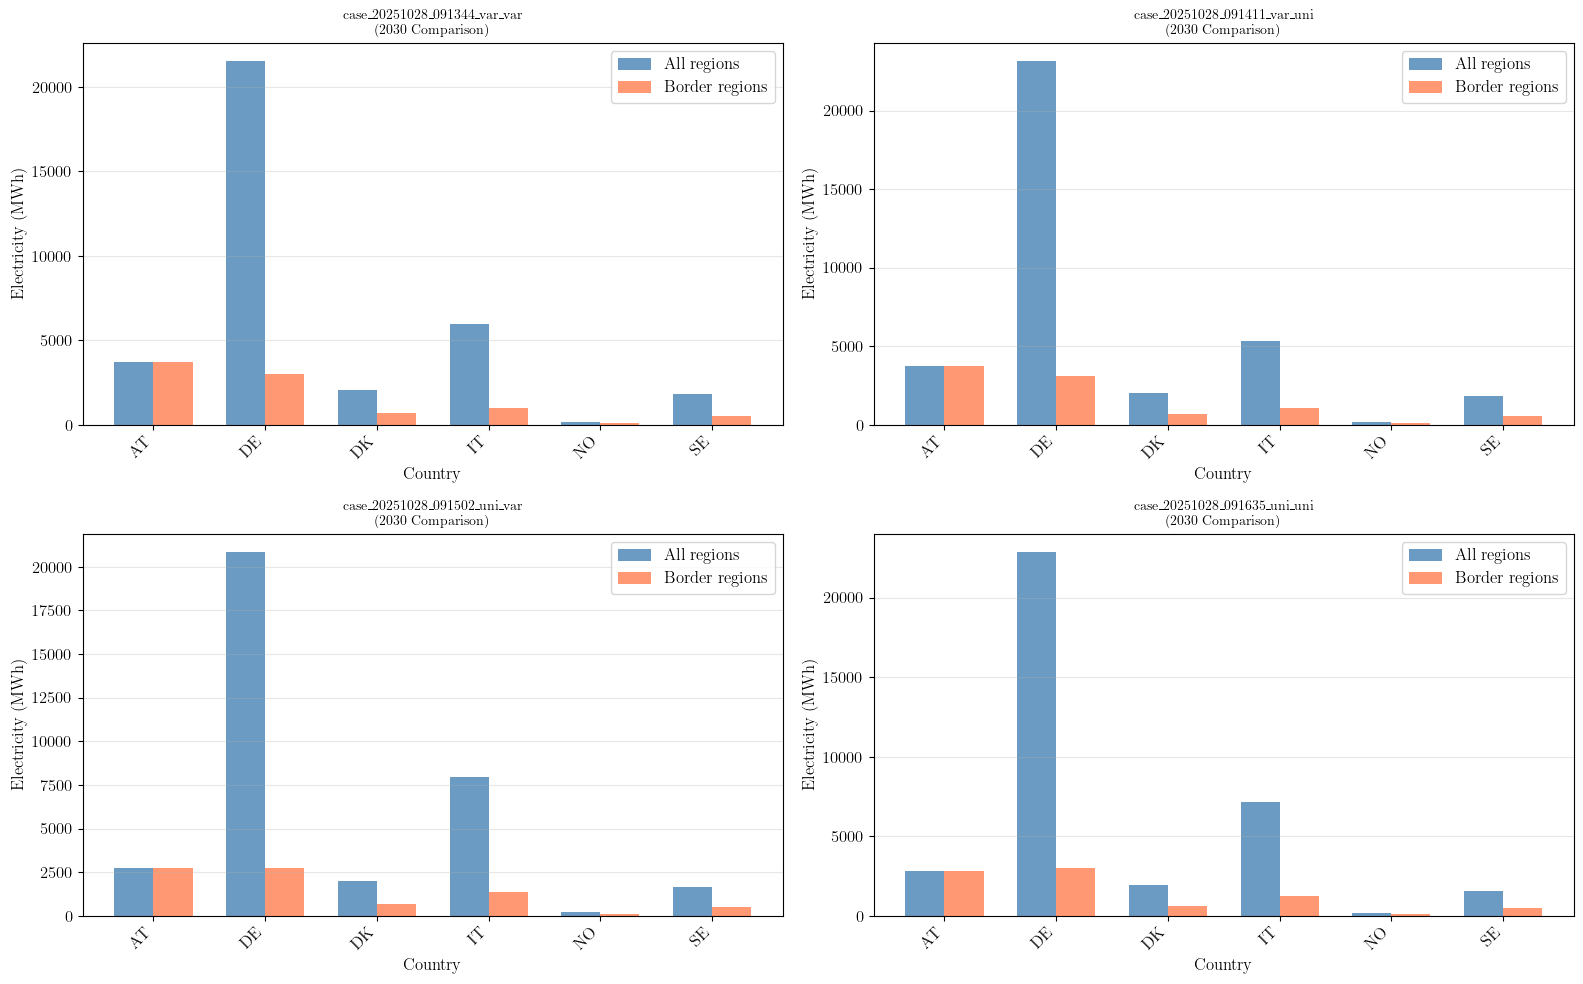

Saved: border_vs_all_comparison_2030.png


In [ ]:
from electrification_analysis import calculate_electrification_by_country

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.ravel()

for i, (case_name, run) in enumerate(zip(case_study_names, loaded_runs.keys())):
    ax = axes[i]

    input_data = loaded_runs[run]["input_data"]
    output_data = loaded_runs[run]["output_data"]

    # Calculate both
    df_all, _, _ = calculate_electrification_by_country(
        input_data, output_data, years_to_plot=[2030]
    )
    df_border, _, _ = calculate_electrification_by_country_border_only(
        input_data, output_data, border_nuts2_codes, years_to_plot=[2030]
    )

    if df_all.empty or df_border.empty:
        ax.text(0.5, 0.5, "No data", ha='center', va='center')
        ax.set_title(case_name)
        continue

    # Merge data
    df_all_agg = df_all.groupby('country')['electricity'].mean()
    df_border_agg = df_border.groupby('country')['electricity'].mean()

    # Combine for plotting
    countries = sorted(set(df_all_agg.index) | set(df_border_agg.index))

    x = np.arange(len(countries))
    width = 0.35

    all_vals = [df_all_agg.get(c, 0) for c in countries]
    border_vals = [df_border_agg.get(c, 0) for c in countries]

    ax.bar(x - width/2, all_vals, width, label='All regions', alpha=0.8, color='steelblue')
    ax.bar(x + width/2, border_vals, width, label='Border regions', alpha=0.8, color='coral')

    ax.set_title(f'{case_name}\n(2030 Comparison)', fontsize=10)
    ax.set_xlabel('Country')
    ax.set_ylabel('Electricity (MWh)')
    ax.set_xticks(x)
    ax.set_xticklabels(countries, rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('border_vs_all_comparison_2030.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: border_vs_all_comparison_2030.png")

In [ ]:
# Use first scenario (var_var) as reference
reference_scenario = case_study_names[0]
reference_df = electrification_per_country_border[0]

print(f"\nBORDER REGION DELTA ANALYSIS (compared to reference: {reference_scenario})")
print("=" * 80)

# Create comprehensive delta tables
delta_tables = {}

for year in [2030, 2040]:
    print(f"\n{'='*80}")
    print(f"YEAR {year} - DETAILED COUNTRY-BY-COUNTRY COMPARISON")
    print(f"{'='*80}\n")

    # Get reference values
    ref_data = reference_df[reference_df['year'] == year].set_index('country')

    # Create comparison table for this year
    comparison_data = []

    for case_name, df in zip(case_study_names, electrification_per_country_border):
        case_data = df[df['year'] == year].set_index('country')

        # Calculate differences for each country
        common_countries = sorted(set(ref_data.index) & set(case_data.index))

        for country in common_countries:
            ref_elec = ref_data.loc[country, 'electricity']
            ref_pct = ref_data.loc[country, 'electrification_pct']
            ref_total = ref_data.loc[country, 'total_fuel']

            case_elec = case_data.loc[country, 'electricity']
            case_pct = case_data.loc[country, 'electrification_pct']
            case_total = case_data.loc[country, 'total_fuel']

            delta_elec = case_elec - ref_elec
            delta_pct = case_pct - ref_pct
            delta_total = case_total - ref_total
            pct_change_elec = (delta_elec / ref_elec * 100) if ref_elec > 0 else 0

            comparison_data.append({
                'scenario': case_name,
                'country': country,
                'ref_electricity_MWh': ref_elec,
                'case_electricity_MWh': case_elec,
                'delta_electricity_MWh': delta_elec,
                'pct_change_electricity': pct_change_elec,
                'ref_electrification_pct': ref_pct,
                'case_electrification_pct': case_pct,
                'delta_electrification_pct': delta_pct,
                'ref_total_fuel_MWh': ref_total,
                'case_total_fuel_MWh': case_total,
                'delta_total_fuel_MWh': delta_total
            })

    # Create DataFrame
    df_delta = pd.DataFrame(comparison_data)
    delta_tables[year] = df_delta

    # Display summary by scenario
    for case_name in case_study_names:
        if case_name == reference_scenario:
            continue

        print(f"\n{case_name} vs {reference_scenario}:")
        print("-" * 80)

        case_delta = df_delta[df_delta['scenario'] == case_name]

        # Print country-by-country comparison
        print("\nBy Country:")
        for _, row in case_delta.iterrows():
            print(f"  {row['country']}:")
            print(f"    Electricity:      {row['ref_electricity_MWh']:>10.2f} → {row['case_electricity_MWh']:>10.2f} "
                  f"(Diff {row['delta_electricity_MWh']:+10.2f} MWh, {row['pct_change_electricity']:+6.2f}%)")
            print(f"    Electrification:  {row['ref_electrification_pct']:>10.2f}% → {row['case_electrification_pct']:>10.2f}% "
                  f"(Diff {row['delta_electrification_pct']:+10.2f} pp)")
            print(f"    Total Fuel:       {row['ref_total_fuel_MWh']:>10.2f} → {row['case_total_fuel_MWh']:>10.2f} "
                  f"(Diff {row['delta_total_fuel_MWh']:+10.2f} MWh)")

        # Overall statistics
        print(f"\n  Overall Statistics:")
        print(f"    Avg Diff electrification:    {case_delta['delta_electrification_pct'].mean():+.2f} percentage points")
        print(f"    Total Diff electricity:      {case_delta['delta_electricity_MWh'].sum():+.2f} MWh")
        print(f"    Avg % change electricity: {case_delta['pct_change_electricity'].mean():+.2f}%")
        print(f"    Total Diff fuel:             {case_delta['delta_total_fuel_MWh'].sum():+.2f} MWh")
        print(f"    Countries compared:       {len(case_delta)}")

        # Identify biggest changes
        max_increase = case_delta.loc[case_delta['delta_electricity_MWh'].idxmax()]
        max_decrease = case_delta.loc[case_delta['delta_electricity_MWh'].idxmin()]

        print(f"\n  Largest Changes:")
        print(f"    Max increase: {max_increase['country']} ({max_increase['delta_electricity_MWh']:+.2f} MWh)")
        print(f"    Max decrease: {max_decrease['country']} ({max_decrease['delta_electricity_MWh']:+.2f} MWh)")

# Export delta tables
for year, df_delta in delta_tables.items():
    filename = f'border_delta_analysis_{year}.csv'
    df_delta.to_csv(filename, index=False)
    print(f"\nExported: {filename}")

print("\n" + "=" * 80)



BORDER REGION DELTA ANALYSIS (compared to reference: case_20251028_091344_var_var)

YEAR 2030 - DETAILED COUNTRY-BY-COUNTRY COMPARISON


case_20251028_091411_var_uni vs case_20251028_091344_var_var:
--------------------------------------------------------------------------------

By Country:
  AT:
    Electricity:         3705.16 →    3720.21 (Diff     +15.05 MWh,  +0.41%)
    Electrification:       82.56% →      82.89% (Diff      +0.34 pp)
    Total Fuel:          4487.91 →    4487.91 (Diff      -0.00 MWh)
  DE:
    Electricity:         2993.02 →    3121.01 (Diff    +127.99 MWh,  +4.28%)
    Electrification:       27.04% →      28.20% (Diff      +1.16 pp)
    Total Fuel:         11067.59 →   11067.59 (Diff      +0.00 MWh)
  DK:
    Electricity:          676.95 →     676.94 (Diff      -0.01 MWh,  -0.00%)
    Electrification:       53.07% →      53.07% (Diff      -0.00 pp)
    Total Fuel:          1275.56 →    1275.56 (Diff      +0.00 MWh)
  IT:
    Electricity:         1014.77 →    10


Creating delta visualization plots...


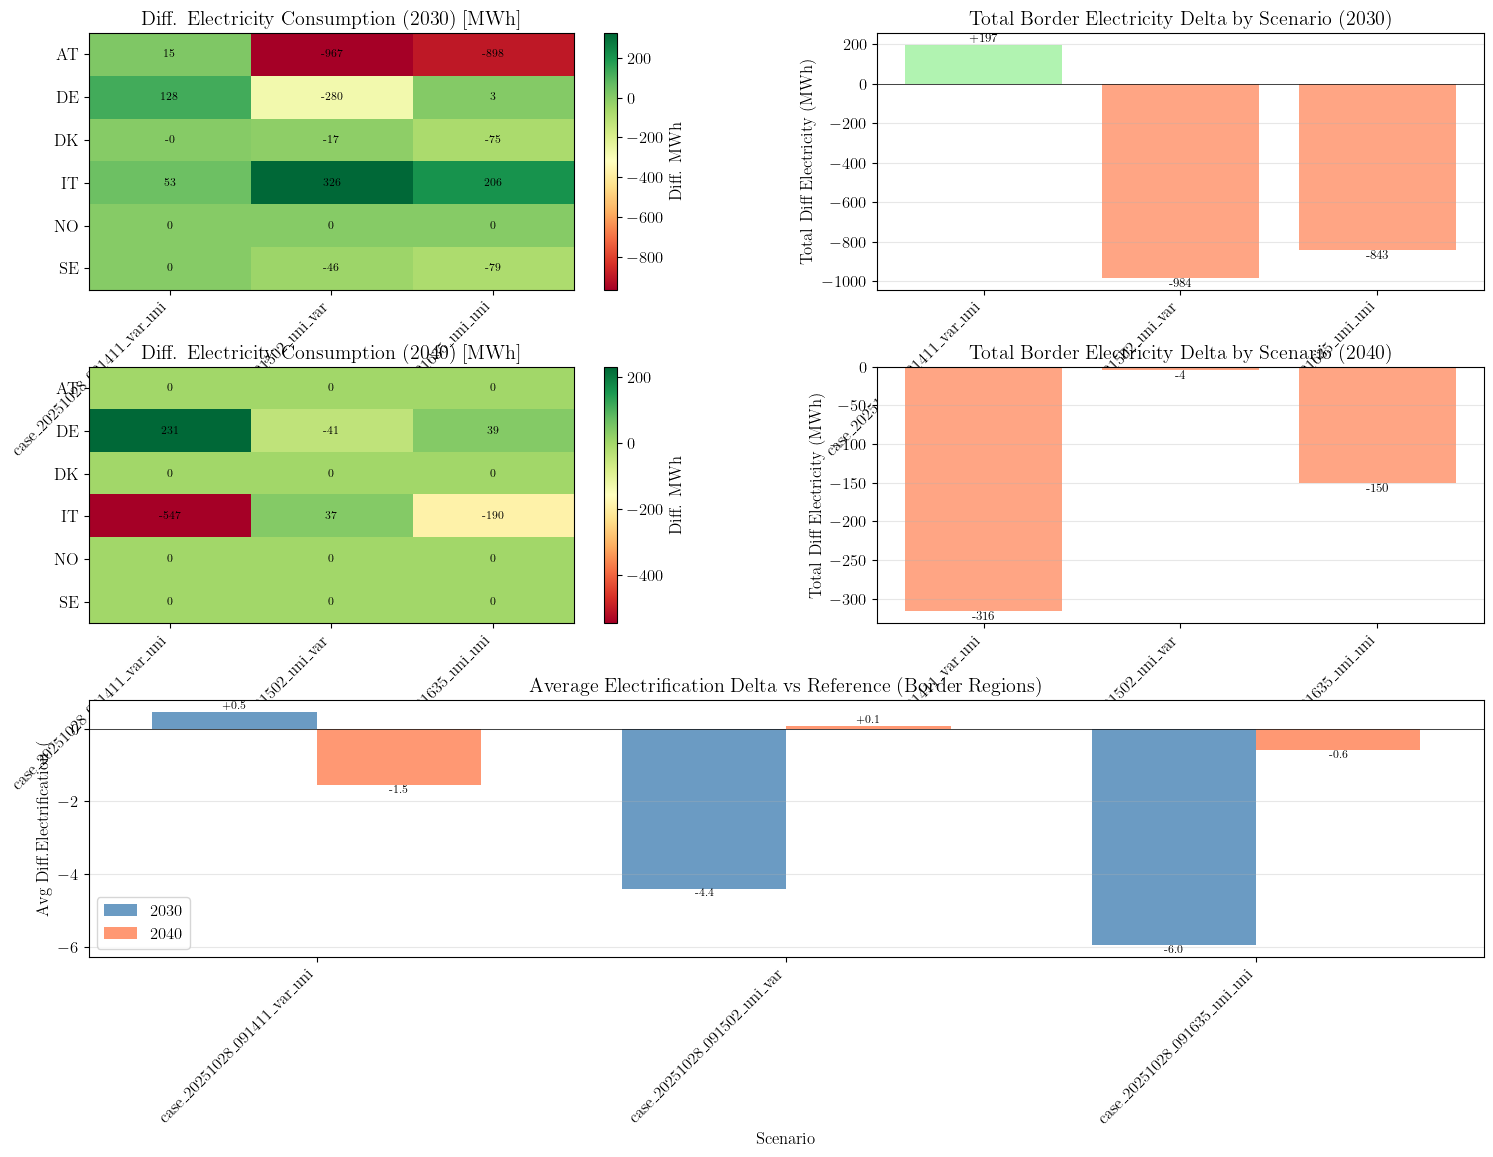

Saved: border_delta_analysis_visualization.png


In [ ]:
print("\nCreating delta visualization plots...")

# Create figure with multiple subplots
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

for year_idx, year in enumerate([2030, 2040]):
    df_delta = delta_tables[year]

    # Exclude reference scenario
    df_delta_plot = df_delta[df_delta['scenario'] != reference_scenario]

    # 1. Heatmap of electricity deltas
    ax1 = fig.add_subplot(gs[year_idx, 0])

    pivot_elec = df_delta_plot.pivot(index='country', columns='scenario', values='delta_electricity_MWh')
    im = ax1.imshow(pivot_elec.values, cmap='RdYlGn', aspect='auto')

    ax1.set_xticks(np.arange(len(pivot_elec.columns)))
    ax1.set_yticks(np.arange(len(pivot_elec.index)))
    ax1.set_xticklabels(pivot_elec.columns, rotation=45, ha='right')
    ax1.set_yticklabels(pivot_elec.index)

    # Add values to heatmap
    for i in range(len(pivot_elec.index)):
        for j in range(len(pivot_elec.columns)):
            text = ax1.text(j, i, f'{pivot_elec.values[i, j]:.0f}',
                          ha="center", va="center", color="black", fontsize=8)

    ax1.set_title(f'Diff. Electricity Consumption ({year}) [MWh]', fontweight='bold')
    plt.colorbar(im, ax=ax1, label='Diff. MWh')

    # 2. Bar chart of total deltas by scenario
    ax2 = fig.add_subplot(gs[year_idx, 1])

    scenario_totals = df_delta_plot.groupby('scenario')['delta_electricity_MWh'].sum()
    colors = ['coral' if x < 0 else 'lightgreen' for x in scenario_totals.values]

    ax2.bar(range(len(scenario_totals)), scenario_totals.values, color=colors, alpha=0.7)
    ax2.set_xticks(range(len(scenario_totals)))
    ax2.set_xticklabels(scenario_totals.index, rotation=45, ha='right')
    ax2.set_ylabel('Total Diff Electricity (MWh)')
    ax2.set_title(f'Total Border Electricity Delta by Scenario ({year})', fontweight='bold')
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax2.grid(axis='y', alpha=0.3)

    # Add value labels
    for i, v in enumerate(scenario_totals.values):
        ax2.text(i, v, f'{v:+.0f}', ha='center', va='bottom' if v > 0 else 'top', fontsize=9)

# 3. Electrification percentage delta comparison (both years)
ax3 = fig.add_subplot(gs[2, :])

all_years_data = []
for year in [2030, 2040]:
    df_delta = delta_tables[year]
    df_delta_plot = df_delta[df_delta['scenario'] != reference_scenario]

    for scenario in df_delta_plot['scenario'].unique():
        scenario_data = df_delta_plot[df_delta_plot['scenario'] == scenario]
        all_years_data.append({
            'year': year,
            'scenario': scenario,
            'avg_delta_pct': scenario_data['delta_electrification_pct'].mean()
        })

df_years_comparison = pd.DataFrame(all_years_data)
pivot_years = df_years_comparison.pivot(index='scenario', columns='year', values='avg_delta_pct')

x = np.arange(len(pivot_years.index))
width = 0.35

ax3.bar(x - width/2, pivot_years[2030], width, label='2030', alpha=0.8, color='steelblue')
ax3.bar(x + width/2, pivot_years[2040], width, label='2040', alpha=0.8, color='coral')

ax3.set_xlabel('Scenario')
ax3.set_ylabel('Avg Diff.Electrification (%)')
ax3.set_title('Average Electrification Delta vs Reference (Border Regions)', fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(pivot_years.index, rotation=45, ha='right')
ax3.legend()
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax3.grid(axis='y', alpha=0.3)

# Add value labels
for i, scenario in enumerate(pivot_years.index):
    v1 = pivot_years.loc[scenario, 2030]
    v2 = pivot_years.loc[scenario, 2040]
    ax3.text(i - width/2, v1, f'{v1:+.1f}', ha='center', va='bottom' if v1 > 0 else 'top', fontsize=8)
    ax3.text(i + width/2, v2, f'{v2:+.1f}', ha='center', va='bottom' if v2 > 0 else 'top', fontsize=8)

plt.savefig('border_delta_analysis_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: border_delta_analysis_visualization.png")


Analyzing temporal evolution of deltas...


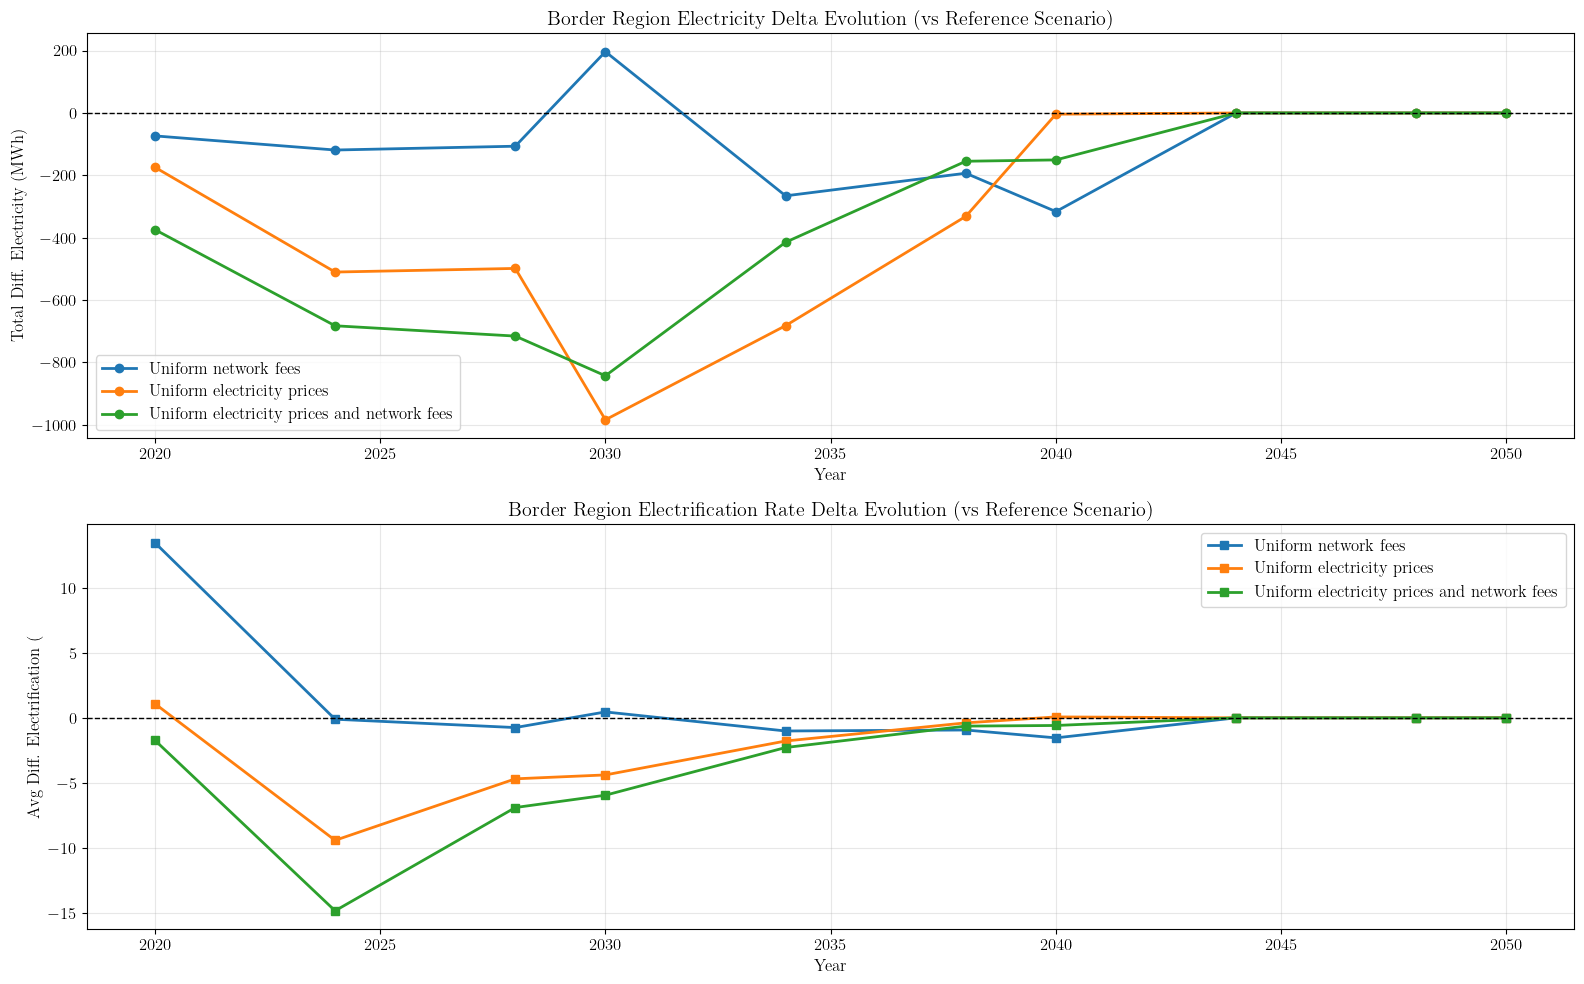

Saved: border_delta_time_series.png
Exported: border_delta_time_series.csv


In [ ]:
print("\nAnalyzing temporal evolution of deltas...")

# Calculate deltas for multiple years
years_to_analyze = [2020, 2024, 2028, 2030, 2034, 2038, 2040, 2044, 2048, 2050]

time_series_deltas = []

for year in years_to_analyze:
    ref_year = reference_df[reference_df['year'] == year]

    if len(ref_year) == 0:
        continue

    ref_year_indexed = ref_year.set_index('country')

    for case_idx, (case_name, df) in enumerate(zip(case_study_names, electrification_per_country_border)):
        if case_name == reference_scenario:
            continue

        case_year = df[df['year'] == year]

        if len(case_year) == 0:
            continue

        case_year_indexed = case_year.set_index('country')

        common_countries = set(ref_year_indexed.index) & set(case_year_indexed.index)

        for country in common_countries:
            ref_elec = ref_year_indexed.loc[country, 'electricity']
            case_elec = case_year_indexed.loc[country, 'electricity']
            ref_pct = ref_year_indexed.loc[country, 'electrification_pct']
            case_pct = case_year_indexed.loc[country, 'electrification_pct']

            time_series_deltas.append({
                'year': year,
                'scenario': case_name,
                'country': country,
                'delta_electricity_MWh': case_elec - ref_elec,
                'delta_electrification_pct': case_pct - ref_pct
            })

df_time_series = pd.DataFrame(time_series_deltas)

# Plot time series
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Plot 1: Delta electricity over time by scenario
ax1 = axes[0]

for scenario in df_time_series['scenario'].unique():
    scenario_data = df_time_series[df_time_series['scenario'] == scenario]
    yearly_totals = scenario_data.groupby('year')['delta_electricity_MWh'].sum()

    ax1.plot(yearly_totals.index, yearly_totals.values, marker='o', linewidth=2, label=case_study_name_labels.get(scenario, scenario))

ax1.set_xlabel('Year')
ax1.set_ylabel('Total Diff. Electricity (MWh)')
ax1.set_title('Border Region Electricity Delta Evolution (vs Reference Scenario)', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='black', linestyle='--', linewidth=1)

# Plot 2: Average electrification delta over time
ax2 = axes[1]

for scenario in df_time_series['scenario'].unique():
    scenario_data = df_time_series[df_time_series['scenario'] == scenario]
    yearly_avg = scenario_data.groupby('year')['delta_electrification_pct'].mean()

    ax2.plot(yearly_avg.index, yearly_avg.values, marker='s', linewidth=2, label=case_study_name_labels.get(scenario, scenario))

ax2.set_xlabel('Year')
ax2.set_ylabel('Avg Diff. Electrification (%)')
ax2.set_title('Border Region Electrification Rate Delta Evolution (vs Reference Scenario)', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)

plt.tight_layout()
plt.savefig('border_delta_time_series.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: border_delta_time_series.png")

# Export time series data
df_time_series.to_csv('border_delta_time_series.csv', index=False)
print("Exported: border_delta_time_series.csv")



Analyzing specific border corridors...

Austria-Germany Corridor:
------------------------------------------------------------
  2030 - case_20251028_091411_var_uni:
    Electricity:         6698.18 →    6841.22 (Diff    +143.04 MWh)
    Avg Electrif.:         54.80% →      55.55% (Diff      +0.75 pp)
  2030 - case_20251028_091502_uni_var:
    Electricity:         6698.18 →    5450.91 (Diff   -1247.27 MWh)
    Avg Electrif.:         54.80% →      42.76% (Diff     -12.04 pp)
  2030 - case_20251028_091635_uni_uni:
    Electricity:         6698.18 →    5803.28 (Diff    -894.90 MWh)
    Avg Electrif.:         54.80% →      44.81% (Diff      -9.99 pp)
  2040 - case_20251028_091411_var_uni:
    Electricity:        16353.36 →   16584.21 (Diff    +230.85 MWh)
    Avg Electrif.:         94.28% →      95.19% (Diff      +0.91 pp)
  2040 - case_20251028_091502_uni_var:
    Electricity:        16353.36 →   16312.47 (Diff     -40.90 MWh)
    Avg Electrif.:         94.28% →      94.12% (Diff      -0

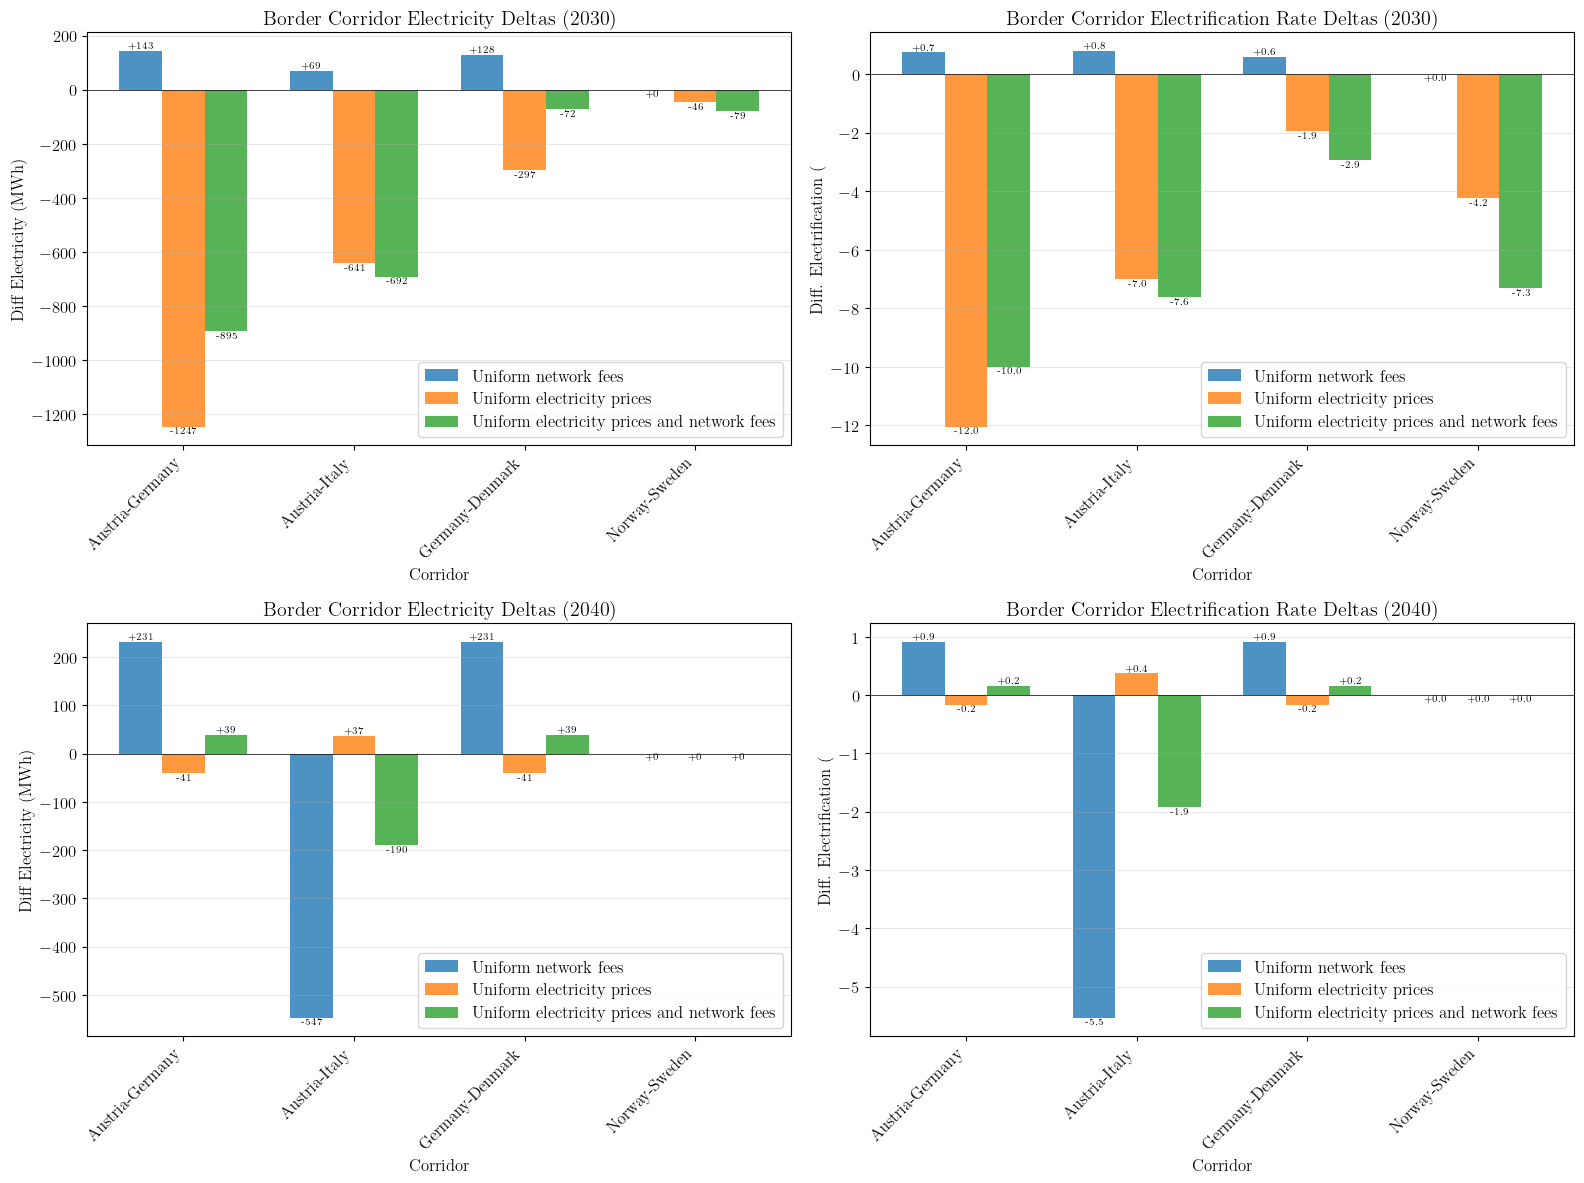


Saved: border_corridor_delta_analysis.png
Exported: border_corridor_delta_analysis.csv


In [ ]:
print("\nAnalyzing specific border corridors...")

# Load border region connections
border_regions_df = pd.read_csv('border_regions_analysis.csv')

# Define major corridors
corridors = {
    'Austria-Germany': {'AT': ['AT31', 'AT32', 'AT33', 'AT34'], 'DE': ['DE14', 'DE21', 'DE22', 'DE27']},
    'Austria-Italy': {'AT': ['AT32', 'AT33'], 'IT': ['ITH1', 'ITH3']},
    'Germany-Denmark': {'DE': ['DEF0'], 'DK': ['DK03']},
    'Norway-Sweden': {'NO': ['NO08'], 'SE': ['SE23']}
}

# Analyze each corridor
corridor_analysis = []

for corridor_name, countries_regions in corridors.items():
    print(f"\n{corridor_name} Corridor:")
    print("-" * 60)

    # Get all regions in this corridor
    corridor_nuts2 = []
    for country, regions in countries_regions.items():
        corridor_nuts2.extend(regions)

    # Calculate metrics for reference scenario
    for year in [2030, 2040]:
        ref_data_year = reference_df[reference_df['year'] == year]

        # Filter to corridor countries
        corridor_countries = list(countries_regions.keys())

        ref_corridor = ref_data_year[ref_data_year['country'].isin(corridor_countries)]
        ref_total_elec = ref_corridor['electricity'].sum()
        ref_avg_pct = ref_corridor['electrification_pct'].mean()

        # Compare with other scenarios
        for case_name, df in zip(case_study_names, electrification_per_country_border):
            if case_name == reference_scenario:
                continue

            case_data_year = df[df['year'] == year]
            case_corridor = case_data_year[case_data_year['country'].isin(corridor_countries)]

            case_total_elec = case_corridor['electricity'].sum() 
            case_avg_pct = case_corridor['electrification_pct'].mean()

            delta_elec = case_total_elec - ref_total_elec
            delta_pct = case_avg_pct - ref_avg_pct

            corridor_analysis.append({
                'corridor': corridor_name,
                'year': year,
                'scenario': case_name,
                'ref_electricity_MWh': ref_total_elec,
                'case_electricity_MWh': case_total_elec,
                'delta_electricity_MWh': delta_elec,
                'ref_avg_electrification_pct': ref_avg_pct,
                'case_avg_electrification_pct': case_avg_pct,
                'delta_electrification_pct': delta_pct
            })

            print(f"  {year} - {case_name}:")
            print(f"    Electricity:      {ref_total_elec:>10.2f} → {case_total_elec:>10.2f} (Diff {delta_elec:+10.2f} MWh)")
            print(f"    Avg Electrif.:    {ref_avg_pct:>10.2f}% → {case_avg_pct:>10.2f}% (Diff {delta_pct:+10.2f} pp)")

# Create DataFrame and visualize
df_corridor = pd.DataFrame(corridor_analysis)

# Visualize corridor deltas
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for year_idx, year in enumerate([2030, 2040]):
    year_data = df_corridor[df_corridor['year'] == year]

    # Electricity delta by corridor
    ax1 = axes[year_idx, 0]
    pivot_elec = year_data.pivot(index='corridor', columns='scenario', values='delta_electricity_MWh')

    x = np.arange(len(pivot_elec.index))
    width = 0.25

    for i, scenario in enumerate(pivot_elec.columns):
        offset = (i - len(pivot_elec.columns)/2 + 0.5) * width
        bars = ax1.bar(x + offset, pivot_elec[scenario], width, label=case_study_name_labels[scenario], alpha=0.8)

        # Add value labels
        for j, v in enumerate(pivot_elec[scenario]):
            if not pd.isna(v):
                ax1.text(j + offset, v, f'{v:+.0f}', ha='center',
                        va='bottom' if v > 0 else 'top', fontsize=7, rotation=0)

    ax1.set_xlabel('Corridor')
    ax1.set_ylabel('Diff Electricity (MWh)')
    ax1.set_title(f'Border Corridor Electricity Deltas ({year})', fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(pivot_elec.index, rotation=45, ha='right')
    ax1.legend()
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax1.grid(axis='y', alpha=0.3)

    # Electrification delta by corridor
    ax2 = axes[year_idx, 1]
    pivot_pct = year_data.pivot(index='corridor', columns='scenario', values='delta_electrification_pct')

    for i, scenario in enumerate(pivot_pct.columns):
        offset = (i - len(pivot_pct.columns)/2 + 0.5) * width
        bars = ax2.bar(x + offset, pivot_pct[scenario], width, label=case_study_name_labels[scenario], alpha=0.8)

        # Add value labels
        for j, v in enumerate(pivot_pct[scenario]):
            if not pd.isna(v):
                ax2.text(j + offset, v, f'{v:+.1f}', ha='center',
                        va='bottom' if v > 0 else 'top', fontsize=7, rotation=0)

    ax2.set_xlabel('Corridor')
    ax2.set_ylabel('Diff. Electrification (%)')
    ax2.set_title(f'Border Corridor Electrification Rate Deltas ({year})', fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(pivot_pct.index, rotation=45, ha='right')
    ax2.legend()
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('border_corridor_delta_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nSaved: border_corridor_delta_analysis.png")

# Export corridor analysis
df_corridor.to_csv('border_corridor_delta_analysis.csv', index=False)
print("Exported: border_corridor_delta_analysis.csv")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from infrastructure_analysis import get_infrastructure_data

def load_border_region_codes(border_codes_file="border_nuts2_codes.txt"):
    """Load border region codes from file."""
    with open(border_codes_file, 'r') as f:
        codes = {line.strip() for line in f if line.strip()}
    return codes

def calculate_border_infrastructure_capacity(
    input_data, output_data, border_nuts2_codes, year, fuel_name='electricity'
):
    """Calculate infrastructure capacity for border regions only."""
    infra_data = get_infrastructure_data(input_data, output_data)
    fuel_list = infra_data['fuel_list']
    fueling_infr_types_list = infra_data['fueling_infr_types_list']
    initial_fueling_infr = infra_data['initial_fueling_infr']
    investment_years = infra_data['investment_years']

    geographic_element_list = {d["id"]: d for d in input_data["GeographicElement"]}

    # Extract energy consumption
    energy_by_location = {}
    if 's' in output_data:
        for key, value in output_data['s'].items():
            s_year = key[0]
            if s_year != year:
                continue
            if len(key) >= 4:
                f_l = key[3]
                fuel_id, infr_id = f_l[0], f_l[1]
                geo_id = key[1] if isinstance(key[1], int) else (key[2] if len(key) > 2 and isinstance(key[2], int) else None)
                if geo_id is not None:
                    energy_key = (s_year, geo_id, fuel_id, infr_id)
                    energy_by_location[energy_key] = energy_by_location.get(energy_key, 0.0) + value

    records = []
    for geo_id, geo_data in geographic_element_list.items():
        geo_nuts2 = geo_data.get('nuts2_region')
        if geo_nuts2 not in border_nuts2_codes:
            continue

        country = geo_data.get('country', 'Unknown')
        for infr_id, infr_data in fueling_infr_types_list.items():
            for fuel_id, fuel_data in fuel_list.items():
                current_fuel_name = fuel_data["name"]
                if fuel_name and current_fuel_name != fuel_name:
                    continue
                if infr_data["fuel"] != current_fuel_name:
                    continue

                initial_key = (current_fuel_name, infr_id, geo_id)
                initial_capacity = initial_fueling_infr[initial_key]["installed_kW"] if initial_key in initial_fueling_infr else 0.0

                added_capacity = 0.0
                f_l = (fuel_id, infr_id)
                for inv_year in investment_years:
                    if inv_year <= year:
                        key_q = (inv_year, f_l, geo_id)
                        if key_q in output_data["q_fuel_infr_plus"]:
                            added_capacity += output_data["q_fuel_infr_plus"][key_q]

                total_capacity = initial_capacity + added_capacity
                energy_key = (year, geo_id, fuel_id, infr_id)
                energy_consumed = energy_by_location.get(energy_key, 0.0)

                utilization_rate = None
                if total_capacity > 0:
                    max_possible_energy = total_capacity * 8760
                    utilization_rate = energy_consumed / max_possible_energy if max_possible_energy > 0 else 0.0

                if total_capacity > 0:
                    records.append({
                        'geo_id': geo_id,
                        'geo_name': geo_data.get('name', 'Unknown'),
                        'nuts2_region': geo_nuts2,
                        'country': country,
                        'fuel': current_fuel_name,
                        'infrastructure_type': infr_data['fueling_type'],
                        'initial_capacity_kW': initial_capacity,
                        'added_capacity_kW': added_capacity,
                        'total_capacity_kW': total_capacity,
                        'energy_consumed_MWh': energy_consumed,
                        'utilization_rate': utilization_rate,
                        'utilization_pct': utilization_rate * 100 if utilization_rate else None
                    })

    return pd.DataFrame(records)

print("Functions loaded successfully!")


Functions loaded successfully!


In [ ]:
print("="*80)
print("BORDER REGION CHARGING INFRASTRUCTURE ANALYSIS")
print("="*80)

# Load border region codes
border_nuts2_codes = load_border_region_codes("border_nuts2_codes.txt")
print(f"\nAnalyzing {len(border_nuts2_codes)} border regions:")
print(sorted(border_nuts2_codes))

# Analyze all scenarios
print("\nCalculating border infrastructure for all scenarios...")
years_to_analyze = [2030, 2040, 2050]

border_infra_data = {}
for scenario_name, run_name in zip(case_study_names, loaded_runs.keys()):
    input_data = loaded_runs[run_name]["input_data"]
    output_data = loaded_runs[run_name]["output_data"]

    scenario_records = []
    for year in years_to_analyze:
        print(f"  Processing {scenario_name} - {year}...")

        df_infra = calculate_border_infrastructure_capacity(
            input_data, output_data, border_nuts2_codes, year, fuel_name='electricity'
        )

        if len(df_infra) > 0:
            # Aggregate by country
            agg_data = []
            for country in df_infra['country'].unique():
                country_data = df_infra[df_infra['country'] == country]
                for infr_type in country_data['infrastructure_type'].unique():
                    type_data = country_data[country_data['infrastructure_type'] == infr_type]
                    total_capacity = type_data['total_capacity_kW'].sum()
                    total_energy = type_data['energy_consumed_MWh'].sum()
                    max_possible = total_capacity * 8760
                    utilization = (total_energy / max_possible * 100) if max_possible > 0 else 0.0

                    agg_data.append({
                        'country': country,
                        'infrastructure_type': infr_type,
                        'total_capacity_kW': total_capacity,
                        'total_capacity_MW': total_capacity / 1000,
                        'total_energy_MWh': total_energy,
                        'utilization_pct': utilization
                    })

            df_agg = pd.DataFrame(agg_data)
            df_agg['year'] = year
            df_agg['scenario'] = scenario_name
            scenario_records.append(df_agg)

    if scenario_records:
        border_infra_data[scenario_name] = pd.concat(scenario_records, ignore_index=True)

print("\nData collection complete!")
for scenario, df in border_infra_data.items():
    print(f"  {scenario}: {len(df)} records")


BORDER REGION CHARGING INFRASTRUCTURE ANALYSIS

Analyzing 14 border regions:
['AT31', 'AT32', 'AT33', 'AT34', 'DE14', 'DE21', 'DE22', 'DE27', 'DEF0', 'DK03', 'ITH1', 'ITH3', 'NO08', 'SE23']

Calculating border infrastructure for all scenarios...
  Processing case_20251028_091344_var_var - 2030...
  Processing case_20251028_091344_var_var - 2040...
  Processing case_20251028_091344_var_var - 2050...
  Processing case_20251028_091411_var_uni - 2030...
  Processing case_20251028_091411_var_uni - 2040...
  Processing case_20251028_091411_var_uni - 2050...
  Processing case_20251028_091502_uni_var - 2030...
  Processing case_20251028_091502_uni_var - 2040...
  Processing case_20251028_091502_uni_var - 2050...
  Processing case_20251028_091635_uni_uni - 2030...
  Processing case_20251028_091635_uni_uni - 2040...
  Processing case_20251028_091635_uni_uni - 2050...

Data collection complete!
  case_20251028_091344_var_var: 36 records
  case_20251028_091411_var_uni: 36 records
  case_20251028_0

In [ ]:
print("\n" + "="*80)
print("CALCULATING INFRASTRUCTURE DELTAS VS REFERENCE SCENARIO")
print("="*80)

reference_scenario = case_study_names[0]
print(f"\nReference scenario: {reference_scenario}")

delta_infra_records = []
for year in years_to_analyze:
    ref_data = border_infra_data[reference_scenario]
    ref_year = ref_data[ref_data['year'] == year]

    for scenario_name in case_study_names:
        if scenario_name == reference_scenario:
            continue

        case_data = border_infra_data[scenario_name]
        case_year = case_data[case_data['year'] == year]

        for _, ref_row in ref_year.iterrows():
            country = ref_row['country']
            infr_type = ref_row['infrastructure_type']

            case_match = case_year[
                (case_year['country'] == country) &
                (case_year['infrastructure_type'] == infr_type)
            ]

            if len(case_match) > 0:
                case_row = case_match.iloc[0]
                delta_infra_records.append({
                    'year': year,
                    'scenario': scenario_name,
                    'country': country,
                    'infrastructure_type': infr_type,
                    'ref_capacity_MW': ref_row['total_capacity_MW'],
                    'case_capacity_MW': case_row['total_capacity_MW'],
                    'delta_capacity_MW': case_row['total_capacity_MW'] - ref_row['total_capacity_MW'],
                    'pct_change_capacity': ((case_row['total_capacity_MW'] - ref_row['total_capacity_MW']) /
                                           ref_row['total_capacity_MW'] * 100) if ref_row['total_capacity_MW'] > 0 else 0,
                    'ref_utilization_pct': ref_row['utilization_pct'],
                    'case_utilization_pct': case_row['utilization_pct'],
                    'delta_utilization_pct': case_row['utilization_pct'] - ref_row['utilization_pct']
                })

df_delta_infra = pd.DataFrame(delta_infra_records)
print(f"\nDelta records created: {len(df_delta_infra)}")
df_delta_infra.to_csv('border_infrastructure_deltas.csv', index=False)
print("Exported: border_infrastructure_deltas.csv")



CALCULATING INFRASTRUCTURE DELTAS VS REFERENCE SCENARIO

Reference scenario: case_20251028_091344_var_var

Delta records created: 108
Exported: border_infrastructure_deltas.csv


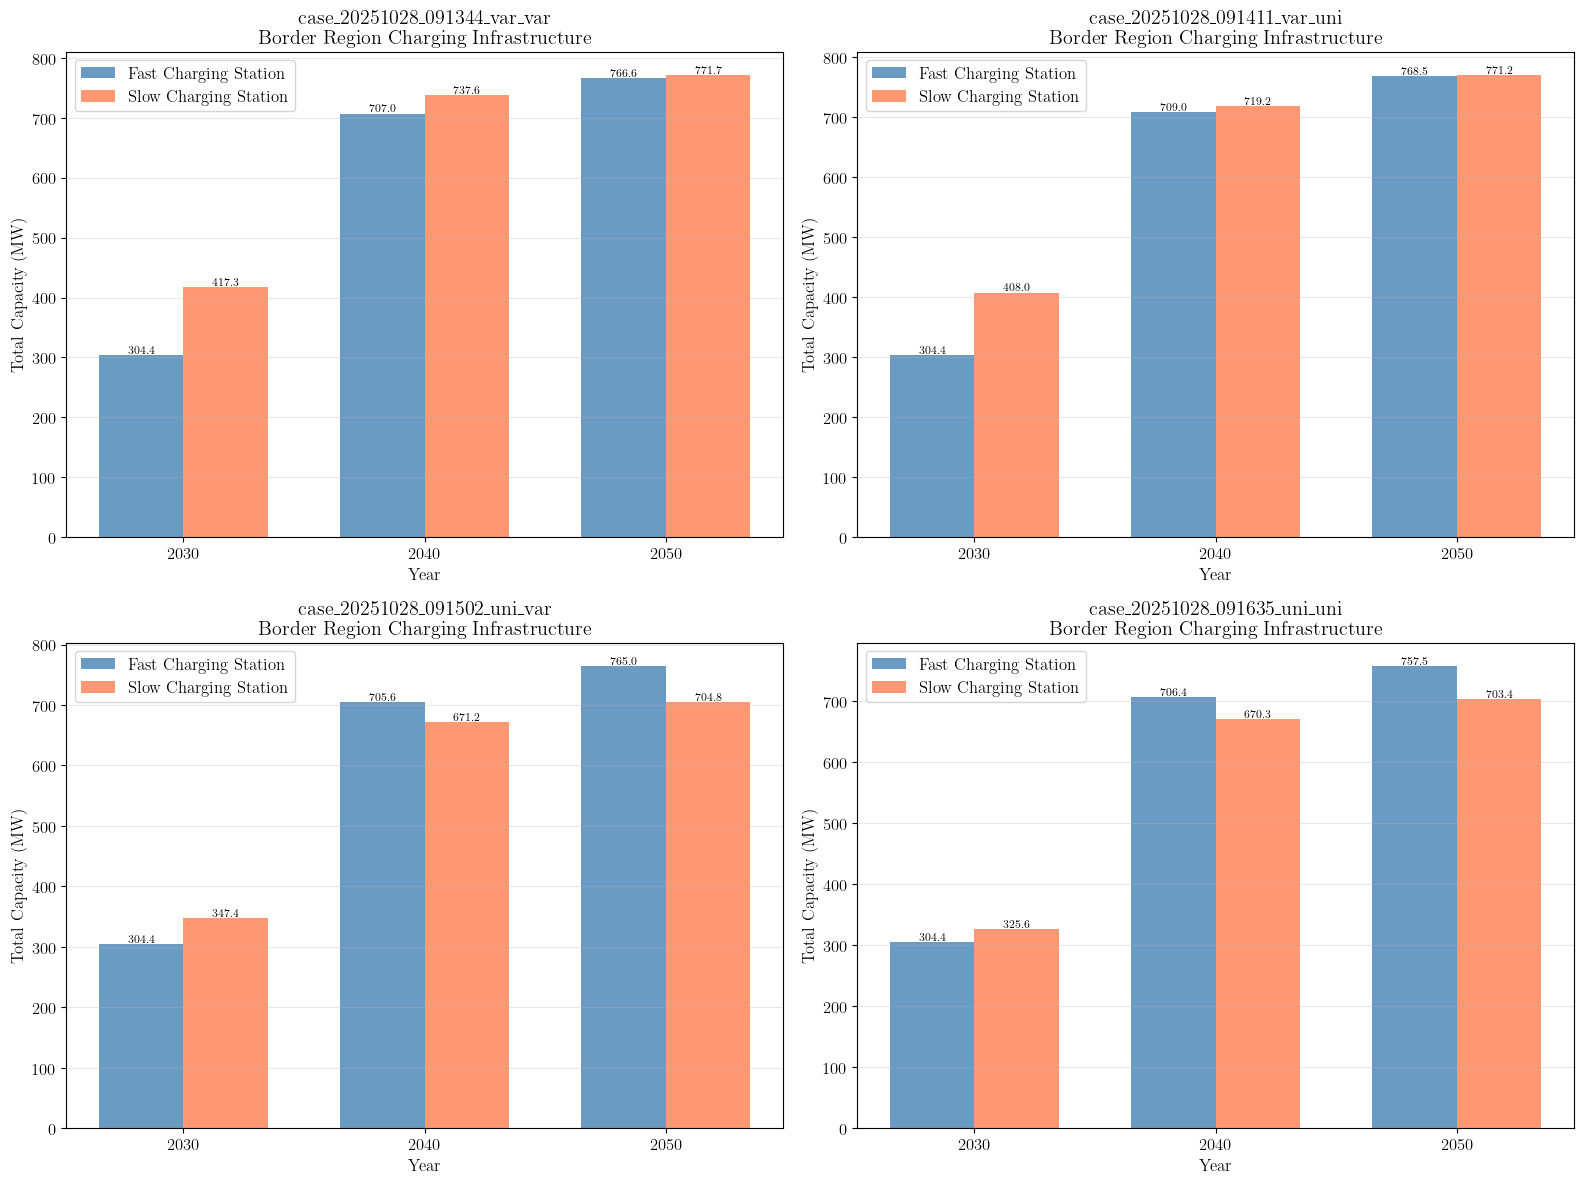

Plot 1 saved: border_infrastructure_capacity_by_scenario.png


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

infr_types = ['fast_charging_station', 'slow_charging_station']
colors = {'fast_charging_station': 'steelblue', 'slow_charging_station': 'coral'}

for i, scenario_name in enumerate(case_study_names):
    ax = axes[i]
    scenario_data = border_infra_data[scenario_name]

    plot_data = []
    for year in years_to_analyze:
        year_data = scenario_data[scenario_data['year'] == year]
        for infr_type in infr_types:
            type_data = year_data[year_data['infrastructure_type'] == infr_type]
            total_capacity = type_data['total_capacity_MW'].sum()
            plot_data.append({'year': year, 'infrastructure_type': infr_type, 'total_capacity_MW': total_capacity})

    df_plot = pd.DataFrame(plot_data)

    if len(df_plot) > 0:
        x = np.arange(len(years_to_analyze))
        width = 0.35

        for j, infr_type in enumerate(infr_types):
            infr_data = df_plot[df_plot['infrastructure_type'] == infr_type]
            offset = (j - 0.5) * width
            values = [infr_data[infr_data['year'] == year]['total_capacity_MW'].sum() for year in years_to_analyze]
            bars = ax.bar(x + offset, values, width, label=infr_type.replace('_', ' ').title(),
                         color=colors.get(infr_type, 'gray'), alpha=0.8)

            for k, v in enumerate(values):
                if v > 0:
                    ax.text(k + offset, v, f'{v:.1f}', ha='center', va='bottom', fontsize=8)

        ax.set_xlabel('Year', fontweight='bold')
        ax.set_ylabel('Total Capacity (MW)', fontweight='bold')
        ax.set_title(f'{scenario_name}\nBorder Region Charging Infrastructure', fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(years_to_analyze)
        ax.legend(loc='upper left')
        ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('border_infrastructure_capacity_by_scenario.png', dpi=300, bbox_inches='tight')
plt.show()
print("Plot 1 saved: border_infrastructure_capacity_by_scenario.png")

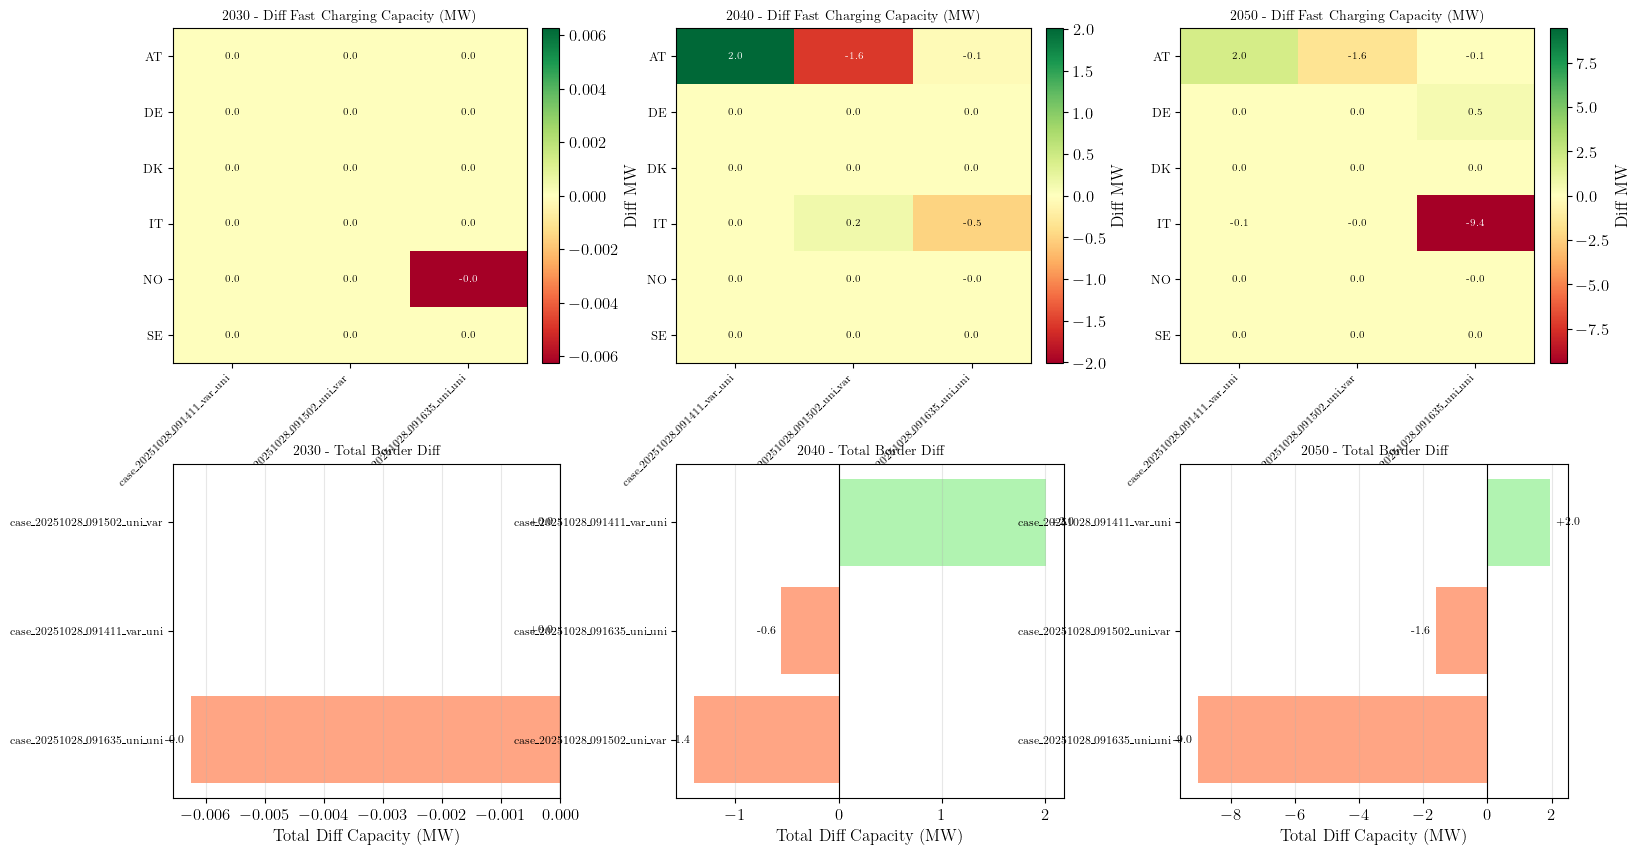

Plot 2 saved: border_infrastructure_capacity_deltas.png


In [ ]:
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

df_delta_fast = df_delta_infra[df_delta_infra['infrastructure_type'] == 'fast_charging_station']

for year_idx, year in enumerate([2030, 2040, 2050]):
    year_data = df_delta_fast[df_delta_fast['year'] == year]
    if len(year_data) == 0:
        continue

    # Heatmap
    ax_heat = fig.add_subplot(gs[0, year_idx])
    pivot_capacity = year_data.pivot(index='country', columns='scenario', values='delta_capacity_MW')

    if not pivot_capacity.empty:
        im = ax_heat.imshow(pivot_capacity.values, cmap='RdYlGn', aspect='auto',
                           vmin=-pivot_capacity.abs().max().max(), vmax=pivot_capacity.abs().max().max())
        ax_heat.set_xticks(np.arange(len(pivot_capacity.columns)))
        ax_heat.set_yticks(np.arange(len(pivot_capacity.index)))
        ax_heat.set_xticklabels(pivot_capacity.columns, rotation=45, ha='right', fontsize=8)
        ax_heat.set_yticklabels(pivot_capacity.index, fontsize=9)

        for i in range(len(pivot_capacity.index)):
            for j in range(len(pivot_capacity.columns)):
                val = pivot_capacity.values[i, j]
                if not pd.isna(val):
                    text_color = 'white' if abs(val) > pivot_capacity.abs().max().max() * 0.5 else 'black'
                    ax_heat.text(j, i, f'{val:.1f}', ha="center", va="center", color=text_color, fontsize=7)

        ax_heat.set_title(f'{year} - Diff Fast Charging Capacity (MW)', fontweight='bold', fontsize=10)
        plt.colorbar(im, ax=ax_heat, label='Diff MW', fraction=0.046, pad=0.04)

    # Bar chart
    ax_bar = fig.add_subplot(gs[1, year_idx])
    scenario_totals = year_data.groupby('scenario')['delta_capacity_MW'].sum().sort_values()
    colors_bar = ['coral' if x < 0 else 'lightgreen' for x in scenario_totals.values]
    ax_bar.barh(range(len(scenario_totals)), scenario_totals.values, color=colors_bar, alpha=0.7)
    ax_bar.set_yticks(range(len(scenario_totals)))
    ax_bar.set_yticklabels(scenario_totals.index, fontsize=8)
    ax_bar.set_xlabel('Total Diff Capacity (MW)', fontweight='bold')
    ax_bar.set_title(f'{year} - Total Border Diff', fontweight='bold', fontsize=10)
    ax_bar.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    ax_bar.grid(axis='x', alpha=0.3)

    for i, v in enumerate(scenario_totals.values):
        h_align = 'left' if v > 0 else 'right'
        offset = 0.02 * (scenario_totals.abs().max())
        x_pos = v + offset if v > 0 else v - offset
        ax_bar.text(x_pos, i, f'{v:+.1f}', va='center', ha=h_align, fontsize=8)

plt.savefig('border_infrastructure_capacity_deltas.png', dpi=300, bbox_inches='tight')
plt.show()
print("Plot 2 saved: border_infrastructure_capacity_deltas.png")


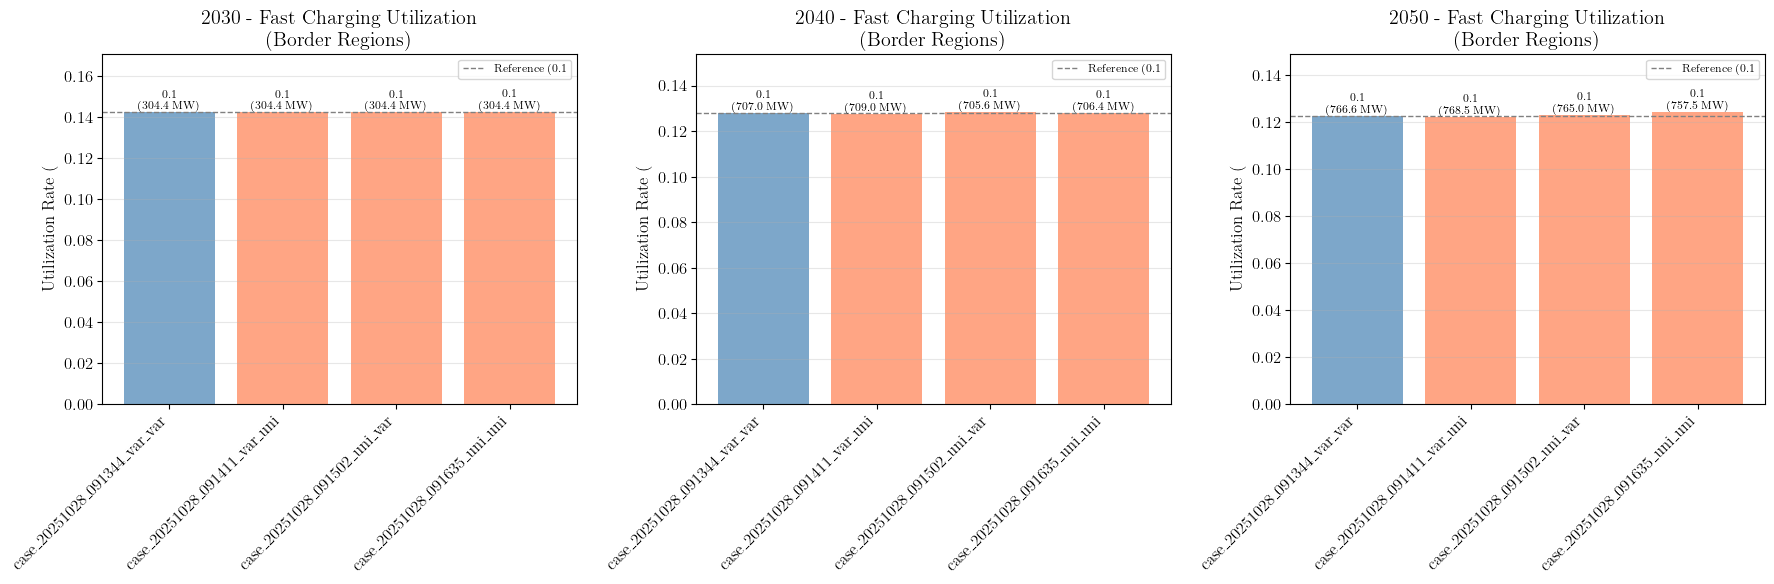

Plot 3 saved: border_infrastructure_utilization.png


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for year_idx, year in enumerate([2030, 2040, 2050]):
    ax = axes[year_idx]
    plot_data = []

    for scenario_name in case_study_names:
        scenario_data = border_infra_data[scenario_name]
        year_data = scenario_data[scenario_data['year'] == year]
        fast_data = year_data[year_data['infrastructure_type'] == 'fast_charging_station']

        if len(fast_data) > 0:
            total_capacity = fast_data['total_capacity_MW'].sum()
            if total_capacity > 0:
                weighted_util = (fast_data['utilization_pct'] * fast_data['total_capacity_MW']).sum() / total_capacity
            else:
                weighted_util = 0
            plot_data.append({'scenario': scenario_name, 'utilization_pct': weighted_util, 'total_capacity_MW': total_capacity})

    if plot_data:
        df_util_plot = pd.DataFrame(plot_data)
        x = np.arange(len(df_util_plot))
        bars = ax.bar(x, df_util_plot['utilization_pct'], alpha=0.7,
                     color=['steelblue' if s == reference_scenario else 'coral' for s in df_util_plot['scenario']])
        ax.set_xticks(x)
        ax.set_xticklabels(df_util_plot['scenario'], rotation=45, ha='right')
        ax.set_ylabel('Utilization Rate (%)', fontweight='bold')
        ax.set_title(f'{year} - Fast Charging Utilization\n(Border Regions)', fontweight='bold')
        ax.set_ylim(0, min(100, df_util_plot['utilization_pct'].max() * 1.2))
        ax.grid(axis='y', alpha=0.3)

        for i, (idx, row) in enumerate(df_util_plot.iterrows()):
            ax.text(i, row['utilization_pct'], f"{row['utilization_pct']:.1f}%\n({row['total_capacity_MW']:.1f} MW)",
                   ha='center', va='bottom', fontsize=8)

        if len(df_util_plot) > 0:
            ref_util = df_util_plot[df_util_plot['scenario'] == reference_scenario]['utilization_pct']
            if len(ref_util) > 0:
                ax.axhline(y=ref_util.iloc[0], color='gray', linestyle='--', linewidth=1,
                          label=f'Reference ({ref_util.iloc[0]:.1f}%)')
                ax.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.savefig('border_infrastructure_utilization.png', dpi=300, bbox_inches='tight')
plt.show()
print("Plot 3 saved: border_infrastructure_utilization.png")


In [ ]:
from sub_border_regions_cross_case import *
  # Define readable labels for your cases
case_labels = {
    "case_20251022_152235_var_var": "Var-Var",
    "case_20251022_152358_var_uni": "Var-Uni",
    "case_20251022_153056_uni_var": "Uni-Var",
    "case_20251022_153317_uni_uni": "Uni-Uni"
}

# Run analysis using your pre-loaded data
df_comparison, df_summary = analyze_sub_region_cross_case_preloaded(
    loaded_runs=loaded_runs,  # Your existing dictionary!
    case_labels=case_labels,
    sub_region_name='Austria-Germany-Italy',
    years_to_plot=[2030, 2040, 2050],
    baseline_case='Var-Var',
    show_plots=False,
    verbose=True
)

# Display results
display(df_comparison.head())
display(df_summary.head())



Processing case: case_20251028_091344_var_var
  Study: case_20251028_091344_var_var
  Loaded 20 input structures
  Loaded 10 output variables
  Found 9 country-year combinations

Processing case: case_20251028_091411_var_uni
  Study: case_20251028_091411_var_uni
  Loaded 20 input structures
  Loaded 10 output variables
  Found 9 country-year combinations

Processing case: case_20251028_091502_uni_var
  Study: case_20251028_091502_uni_var
  Loaded 20 input structures
  Loaded 10 output variables
  Found 9 country-year combinations

Processing case: case_20251028_091635_uni_uni
  Study: case_20251028_091635_uni_uni
  Loaded 20 input structures
  Loaded 10 output variables
  Found 9 country-year combinations

CROSS-CASE COMPARISON: Austria-Germany-Italy
                        Case  Year  Countries  Avg Electrification %  Min Electrification %  Max Electrification %  Total Electricity (MWh)  Total Fuel (MWh)
case_20251028_091344_var_var  2030          3              44.947480            

,country,year,electrification_pct,total_fuel,electricity,region_type,sub_region,case,case_study_name
0,DE,2050,100.000000,11022.772944,11022.772944,border_Austria-Germany-Italy,Austria-Germany-Italy,case_20251028_091344_var_var,case_20251028_091344_var_var
1,DE,2030,28.781436,8551.396900,2461.214819,border_Austria-Germany-Italy,Austria-Germany-Italy,case_20251028_091344_var_var,case_20251028_091344_var_var
2,DE,2040,85.773794,9787.084924,8394.754047,border_Austria-Germany-Italy,Austria-Germany-Italy,case_20251028_091344_var_var,case_20251028_091344_var_var
3,AT,2040,100.000000,5136.416489,5136.416489,border_Austria-Germany-Italy,Austria-Germany-Italy,case_20251028_091344_var_var,case_20251028_091344_var_var
4,AT,2030,82.558719,4487.907931,3705.159311,border_Austria-Germany-Italy,Austria-Germany-Italy,case_20251028_091344_var_var,case_20251028_091344_var_var


,Case,Year,Countries,Avg Electrification %,Min Electrification %,Max Electrification %,Total Electricity (MWh),Total Fuel (MWh)
0,case_20251028_091344_var_var,2030,3,44.947480,23.502286,82.558719,7181.144309,17357.055864
1,case_20251028_091344_var_var,2040,3,94.757260,85.773794,100.000000,18398.617723,19865.173120
2,case_20251028_091344_var_var,2050,3,100.000000,100.000000,100.000000,22373.290352,22373.290352
3,case_20251028_091411_var_uni,2030,3,45.887280,24.741033,82.894127,7356.168867,17357.055864
4,case_20251028_091411_var_uni,2040,3,91.764612,87.429229,100.000000,18056.265644,19865.173122


In [ ]:
print(case_study_name_labels)

{'case_20251028_091344_var_var': 'Base case', 'case_20251028_091411_var_uni': 'Uniform network fees', 'case_20251028_091502_uni_var': 'Uniform electricity prices', 'case_20251028_091635_uni_uni': 'Uniform electricity prices and network fees'}


In [ ]:
# Bar plots of absolute "electricity" by country and scenario for years 2030, 2040, 2050
# Relies on df_comparison and a mapping `case_labels` or `case_study_name_labels` already present in the notebook.


colors = {
    "Base case": "#84ffc9",
    "Uniform network fees": "#4281a4",
    "Uniform electricity prices": "#e56399",
    "Uniform electricity prices and network fees": "#7f96ff"
}
labels = {}
for i, case_study_name in enumerate(case_study_names):
    labels[case_study_name] = case_study_name_labels[i]

years = [2030, 2040, 2050]
if 'df_comparison' not in globals():
    raise RuntimeError("df_comparison not found in the notebook. Run the cell that creates df_comparison first.")

# prefer short labels mapping if available
label_map = globals().get('case_labels', globals().get('case_study_name_labels', {}))

os.makedirs('figures', exist_ok=True)

fig, axes = plt.subplots(1, len(years), figsize=(6 * len(years), 5), sharey=True)
if len(years) == 1:
    axes = [axes]

for ax, year in zip(axes, years):
    dfy = df_comparison[df_comparison['year'] == year]
    if dfy.empty:
        ax.text(0.5, 0.5, f"No data for {year}", ha='center', va='center')
        ax.set_title(str(year))
        ax.set_xticks([])
        continue

    # pivot so rows = countries, cols = scenarios, values = electricity (absolute)
    pivot = dfy.pivot_table(index='country', columns='case', values='electricity', aggfunc='sum').fillna(0)
    countries = list(pivot.index)
    scenarios = list(pivot.columns)

    n_scen = max(1, len(scenarios))
    x = np.arange(len(countries))
    width = 0.8 / n_scen
    #scenarios_reordered = ['Var-Var', 'Var-Uni', 'Uni-Var', 'Uni-Uni']

    for i, scen in enumerate(scenarios):
        vals = pivot[scen].values
        offsets = (i - (n_scen - 1) / 2) * width
        bars = ax.bar(x + offsets, vals, width, label=labels.get(scen, scen), color=colors.get(labels.get(scen, scen), 'gray'), alpha=0.8)

        # annotate absolute values
        for xi, v in zip(x + offsets, vals):
            if v != 0:
                ax.text(xi, v, f'{v:.0f}', ha='center', va='bottom', fontsize=8, rotation=0)

    ax.set_xticks(x)
    ax.set_xticklabels(countries, rotation=45, ha='right')
    ax.set_title(f'Electricity by Country — {year}')
    ax.set_ylabel('Electricity (MWh)')
    ax.grid(axis='y', alpha=0.3)
    ax.legend(fontsize=9)

plt.tight_layout()
outfile = 'figures/subregion_electricity_by_country_2030_2040_2050_AT_DE_IT.pdf'
plt.savefig(outfile, dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {outfile}")
df_comparison_at_de_it = df_comparison.copy()

KeyError: 0

In [ ]:
import importlib
import sub_border_regions
import sub_border_regions_cross_case

# Reload base module first (contains SUB_BORDER_REGIONS definition)
importlib.reload(sub_border_regions)

# Then reload cross-case module (imports from sub_border_regions)
importlib.reload(sub_border_regions_cross_case)

# Import everything
from sub_border_regions_cross_case import *

print("✓ Modules reloaded!")
print("\nAvailable clusters:")
for name in SUB_BORDER_REGIONS.keys():
    print(f"  - {name}")

case_labels = {
    "case_20251022_152235_var_var": "Var-Var",
    "case_20251022_152358_var_uni": "Var-Uni",
    "case_20251022_153056_uni_var": "Uni-Var",
    "case_20251022_153317_uni_uni": "Uni-Uni"
}

# Analyze the NEW Germany-Denmark-Sweden cluster
df_comparison, df_summary = analyze_sub_region_cross_case_preloaded(
    loaded_runs=loaded_runs,
    case_labels=case_labels,
    sub_region_name='Germany-Denmark-Sweden',  # <-- THE NEW CLUSTER!
    years_to_plot=[2030, 2040, 2050],
    baseline_case='Var-Var',
    show_plots=False,
    verbose=True
)

display(df_comparison)
display(df_summary)

✓ Modules reloaded!

Available clusters:
  - Austria-Germany-Italy
  - Germany-Denmark-Sweden
  - Denmark-Germany
  - Norway-Sweden

Processing case: case_20251028_091344_var_var
  Study: case_20251028_091344_var_var
  Loaded 20 input structures
  Loaded 9 output variables
  Found 9 country-year combinations

Processing case: case_20251028_091411_var_uni
  Study: case_20251028_091411_var_uni
  Loaded 20 input structures
  Loaded 9 output variables
  Found 9 country-year combinations

Processing case: case_20251028_091502_uni_var
  Study: case_20251028_091502_uni_var
  Loaded 20 input structures
  Loaded 9 output variables
  Found 9 country-year combinations

Processing case: case_20251028_091635_uni_uni
  Study: case_20251028_091635_uni_uni
  Loaded 20 input structures
  Loaded 9 output variables
  Found 9 country-year combinations

CROSS-CASE COMPARISON: Germany-Denmark-Sweden
                        Case  Year  Countries  Avg Electrification %  Min Electrification %  Max Electrificat

,country,year,electrification_pct,total_fuel,electricity,region_type,sub_region,case,case_study_name
0,SE,2040,100.000000,1264.441876,1264.441876,border_Germany-Denmark-Sweden,Germany-Denmark-Sweden,case_20251028_091344_var_var,case_20251028_091344_var_var
1,SE,2050,100.000000,1424.086530,1424.086530,border_Germany-Denmark-Sweden,Germany-Denmark-Sweden,case_20251028_091344_var_var,case_20251028_091344_var_var
2,SE,2030,100.000000,1104.797235,1104.797235,border_Germany-Denmark-Sweden,Germany-Denmark-Sweden,case_20251028_091344_var_var,case_20251028_091344_var_var
3,DK,2050,100.000000,3398.596769,3398.596769,border_Germany-Denmark-Sweden,Germany-Denmark-Sweden,case_20251028_091344_var_var,case_20251028_091344_var_var
4,DK,2030,77.266010,2636.609673,2037.203088,border_Germany-Denmark-Sweden,Germany-Denmark-Sweden,case_20251028_091344_var_var,case_20251028_091344_var_var
5,DK,2040,100.000000,3017.603221,3017.603221,border_Germany-Denmark-Sweden,Germany-Denmark-Sweden,case_20251028_091344_var_var,case_20251028_091344_var_var
6,DE,2040,98.000007,2879.788085,2822.192528,border_Germany-Denmark-Sweden,Germany-Denmark-Sweden,case_20251028_091344_var_var,case_20251028_091344_var_var
7,DE,2030,21.135369,2516.194673,531.807032,border_Germany-Denmark-Sweden,Germany-Denmark-Sweden,case_20251028_091344_var_var,case_20251028_091344_var_var
8,DE,2050,100.000000,3243.381507,3243.381507,border_Germany-Denmark-Sweden,Germany-Denmark-Sweden,case_20251028_091344_var_var,case_20251028_091344_var_var
9,SE,2040,100.000000,1264.441876,1264.441876,border_Germany-Denmark-Sweden,Germany-Denmark-Sweden,case_20251028_091411_var_uni,case_20251028_091411_var_uni


,Case,Year,Countries,Avg Electrification %,Min Electrification %,Max Electrification %,Total Electricity (MWh),Total Fuel (MWh)
0,case_20251028_091344_var_var,2030,3,66.133793,21.135369,100.000000,3673.807355,6257.601581
1,case_20251028_091344_var_var,2040,3,99.333336,98.000007,100.000000,7104.237625,7161.833182
2,case_20251028_091344_var_var,2050,3,100.000000,100.000000,100.000000,8066.064806,8066.064806
3,case_20251028_091411_var_uni,2030,3,66.418591,21.990000,100.000000,3695.305311,6257.601580
4,case_20251028_091411_var_uni,2040,3,99.636817,98.910451,100.000000,7130.456480,7161.833181
5,case_20251028_091411_var_uni,2050,3,100.000000,100.000000,100.000000,8066.064806,8066.064806
6,case_20251028_091502_uni_var,2030,3,59.805248,17.335199,86.793990,3380.097555,6257.601581
7,case_20251028_091502_uni_var,2040,3,99.207511,97.622532,100.000000,7093.367153,7161.833181
8,case_20251028_091502_uni_var,2050,3,100.000000,100.000000,100.000000,8066.064806,8066.064806
9,case_20251028_091635_uni_uni,2030,3,57.224352,18.612756,80.490653,3270.970062,6257.601581


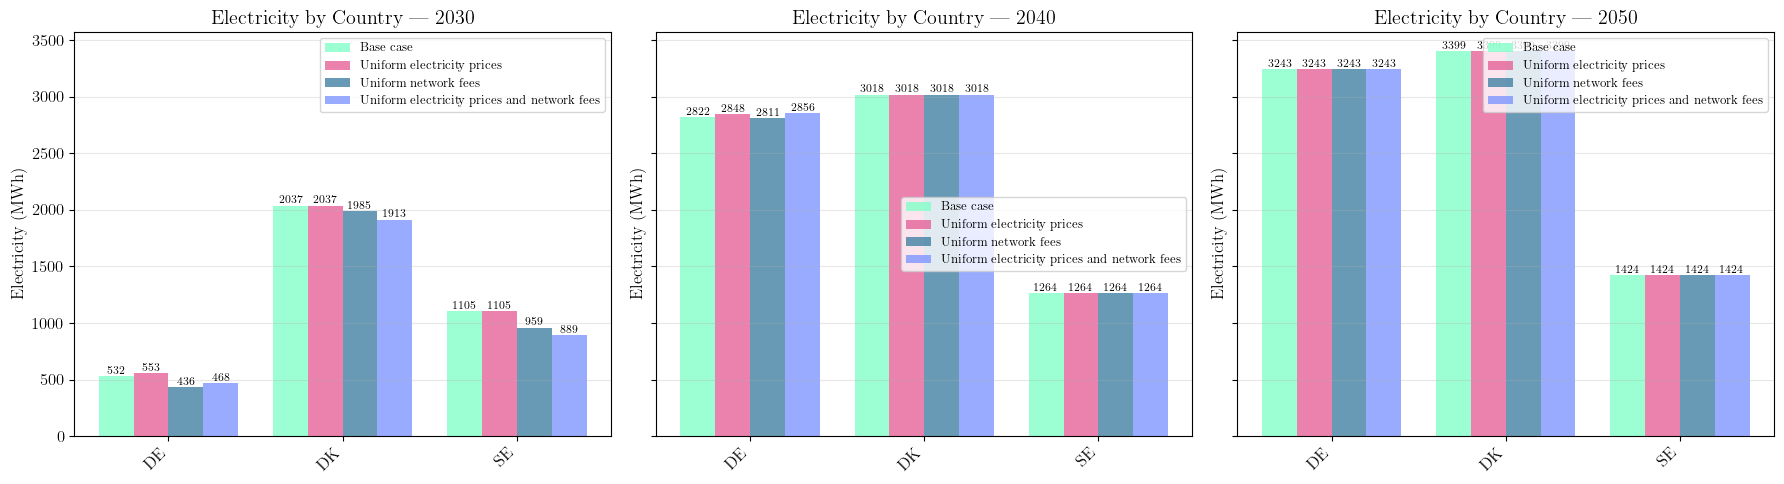

Saved: figures/subregion_electricity_by_country_2030_2040_2050_DE_DK_SE.pdf


In [ ]:
# Bar plots of absolute "electricity" by country and scenario for years 2030, 2040, 2050
# Relies on df_comparison and a mapping `case_labels` or `case_study_name_labels` already present in the notebook.

# colors = {
#     'Var-Var': '#a6cfd5',
#     'Var-Uni': '#4281a4',
#     'Uni-Var': '#e56399',
#     'Uni-Uni': '#7f96ff'
# }
years = [2030, 2040, 2050]
if 'df_comparison' not in globals():
    raise RuntimeError("df_comparison not found in the notebook. Run the cell that creates df_comparison first.")

# prefer short labels mapping if available
label_map = globals().get('case_labels', globals().get('case_study_name_labels', {}))

os.makedirs('figures', exist_ok=True)

fig, axes = plt.subplots(1, len(years), figsize=(6 * len(years), 5), sharey=True)
if len(years) == 1:
    axes = [axes]

for ax, year in zip(axes, years):
    dfy = df_comparison[df_comparison['year'] == year]
    if dfy.empty:
        ax.text(0.5, 0.5, f"No data for {year}", ha='center', va='center')
        ax.set_title(str(year))
        ax.set_xticks([])
        continue

    # pivot so rows = countries, cols = scenarios, values = electricity (absolute)
    pivot = dfy.pivot_table(index='country', columns='case', values='electricity', aggfunc='sum').fillna(0)
    countries = list(pivot.index)
    scenarios = list(pivot.columns)

    n_scen = max(1, len(scenarios))
    x = np.arange(len(countries))
    width = 0.8 / n_scen
    # scenarios_reordered = ['Var-Var', 'Var-Uni', 'Uni-Var', 'Uni-Uni']

    for i, scen in enumerate(scenarios):
        vals = pivot[scen].values
        offsets = (i - (n_scen - 1) / 2) * width
        bars = ax.bar(x + offsets, vals, width, label=labels.get(scen, scen), color=colors.get(labels.get(scen, scen), 'gray'), alpha=0.8)

        # annotate absolute values
        for xi, v in zip(x + offsets, vals):
            if v != 0:
                ax.text(xi, v, f'{v:.0f}', ha='center', va='bottom', fontsize=8, rotation=0)

    ax.set_xticks(x)
    ax.set_xticklabels(countries, rotation=45, ha='right')
    ax.set_title(f'Electricity by Country — {year}')
    ax.set_ylabel('Electricity (MWh)')
    ax.grid(axis='y', alpha=0.3)
    ax.legend(fontsize=9)

plt.tight_layout()
outfile = 'figures/subregion_electricity_by_country_2030_2040_2050_DE_DK_SE.pdf'
plt.savefig(outfile, dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {outfile}")
df_comparison_de_dk_se = df_comparison.copy()


In [ ]:
import pandas as pd
df = pd.read_csv('highway_km_per_nuts2.csv')
df.head()

,NUTS2_CODE,highway_km
0,AL01,0.000
1,AL02,0.000
2,AL03,0.000
3,AT11,52.932
4,AT12,213.656


In [ ]:
import pandas as pd

# Load metrics
df = pd.read_csv('nuts2_traffic_metrics.csv')

# Get Germany-Denmark-Sweden cluster
  # Cluster definitions
CLUSTER_DE_DK_SE = ['DEF0', 'DK01', 'DK02', 'DK03', 'DK04', 'DK05', 'SE22', 'SE23']
CLUSTER_AT_DE_IT = ['AT31', 'AT32', 'AT33', 'AT34', 'DE14', 'DE21', 'DE22', 'DE27', 'ITH1', 'ITH3']

# Filter dataframe
cluster_de_dk_se = df[df['NUTS2_CODE'].isin(CLUSTER_DE_DK_SE)]
cluster_at_de_it = df[df['NUTS2_CODE'].isin(CLUSTER_AT_DE_IT)]

# Calculate metrics
total_freight_de_dk_se = cluster_de_dk_se['total_tonnes'].sum()
total_tkm_de_dk_se = cluster_de_dk_se['total_tkm'].sum()

total_freight_at_de_it = cluster_at_de_it['total_tonnes'].sum()
total_tkm_at_de_it = cluster_at_de_it['total_tkm'].sum()




In [ ]:
traffic_df = pd.read_csv('nuts2_traffic_metrics.csv')
# Map NUTS2 to country
NUTS2_TO_COUNTRY = {
    'DEF0': 'DE',
    'DK01': 'DK', 'DK02': 'DK', 'DK03': 'DK', 'DK04': 'DK', 'DK05': 'DK',
    'SE22': 'SE', 'SE23': 'SE'
}

# Filter to cluster and aggregate by country
traffic_cluster = traffic_df[traffic_df['NUTS2_CODE'].isin(CLUSTER_DE_DK_SE)].copy()
traffic_cluster['country'] = traffic_cluster['NUTS2_CODE'].map(NUTS2_TO_COUNTRY)

traffic_by_country = traffic_cluster.groupby('country').agg({
    'total_tonnes': 'sum',
    'total_tkm': 'sum'
}).reset_index()

# Merge with df_comparison
combined = df_comparison_de_dk_se.merge(traffic_by_country, on='country', how='left')

# Calculate MWh/TKM
combined['MWh_per_TKM'] = combined['electricity'] / combined['total_tkm']
combined['kWh_per_1000tkm'] = combined['MWh_per_TKM'] * 1000000
# Display result
display(combined[['case', 'country', 'year', 'electricity', 'total_tkm', 'MWh_per_TKM', 'kWh_per_1000tkm']].head(15))

# Summary by year and case
pivot = combined.pivot_table(
    values='kWh_per_1000tkm',
    index=['country', 'year'],
    columns='case',
    aggfunc='mean'
)
display(pivot)



,case,country,year,electricity,total_tkm,MWh_per_TKM,kWh_per_1000tkm
0,case_20251028_091344_var_var,SE,2040,1264.441876,1.011312e+09,1.250299e-06,1.250299
1,case_20251028_091344_var_var,SE,2050,1424.086530,1.011312e+09,1.408158e-06,1.408158
2,case_20251028_091344_var_var,SE,2030,1104.797235,1.011312e+09,1.092440e-06,1.092440
3,case_20251028_091344_var_var,DK,2050,3398.596769,1.702234e+09,1.996550e-06,1.996550
4,case_20251028_091344_var_var,DK,2030,2037.203088,1.702234e+09,1.196782e-06,1.196782
5,case_20251028_091344_var_var,DK,2040,3017.603221,1.702234e+09,1.772731e-06,1.772731
6,case_20251028_091344_var_var,DE,2040,2822.192528,1.138034e+09,2.479884e-06,2.479884
7,case_20251028_091344_var_var,DE,2030,531.807032,1.138034e+09,4.673032e-07,0.467303
8,case_20251028_091344_var_var,DE,2050,3243.381507,1.138034e+09,2.849986e-06,2.849986
9,case_20251028_091411_var_uni,SE,2040,1264.441876,1.011312e+09,1.250299e-06,1.250299


case          case_20251028_091344_var_var  case_20251028_091411_var_uni  \
country year                                                               
DE      2030                      0.467303                      0.486199   
        2040                      2.479884                      2.502922   
        2050                      2.849986                      2.849986   
DK      2030                      1.196782                      1.196778   
        2040                      1.772731                      1.772731   
        2050                      1.996550                      1.996550   
SE      2030                      1.092440                      1.092440   
        2040                      1.250299                      1.250299   
        2050                      1.408158                      1.408158   

case          case_20251028_091502_uni_var  case_20251028_091635_uni_uni  
country year                                                              
DE      2030                      0.383281                      0.411528  
        2040                      2.470332                      2.509931  
        2050                      2.849986                      2.849986  
DK      2030                      1.166122                      1.124039  
        2040                      1.772731                      1.772731  
        2050                      1.996550                      1.996550  
SE      2030                      0.948172                      0.879312  
        2040                      1.250299                      1.250299  
        2050                      1.408158                      1.408158

In [ ]:
 # =============================================================================
# AUSTRIA-GERMANY-ITALY (AT-DE-IT) CLUSTER ANALYSIS
# =============================================================================

import pandas as pd
import numpy as np

# Load traffic metrics
traffic_df = pd.read_csv('nuts2_traffic_metrics.csv')

# Define AT-DE-IT cluster codes
CLUSTER_AT_DE_IT = ['AT31', 'AT32', 'AT33', 'AT34',  # Austria
                    'DE14', 'DE21', 'DE22', 'DE27',  # Germany
                    'ITH1', 'ITH3']                   # Italy

# Map NUTS2 to country
NUTS2_TO_COUNTRY_AT_DE_IT = {
    'AT31': 'AT', 'AT32': 'AT', 'AT33': 'AT', 'AT34': 'AT',
    'DE14': 'DE', 'DE21': 'DE', 'DE22': 'DE', 'DE27': 'DE',
    'ITH1': 'IT', 'ITH3': 'IT'
}
highway_df = pd.read_csv('highway_km_per_nuts2.csv')
# Filter to cluster and aggregate by country
traffic_cluster_at = traffic_df[traffic_df['NUTS2_CODE'].isin(CLUSTER_AT_DE_IT)].copy()
traffic_cluster_at['country'] = traffic_cluster_at['NUTS2_CODE'].map(NUTS2_TO_COUNTRY_AT_DE_IT)

traffic_by_country_at = traffic_cluster_at.groupby('country').agg({
    'origin_tonnes': 'sum',
    'destination_tonnes': 'sum',
    'through_tonnes': 'sum',
    'total_tonnes': 'sum',
    'total_tkm': 'sum'
}).reset_index()

print("="*80)
print("AUSTRIA-GERMANY-ITALY CLUSTER - TRAFFIC METRICS")
print("="*80)
print(traffic_by_country_at)

# Merge with df_comparison_at_de_it
# NOTE: Make sure you have df_comparison for this cluster!
# You need to run analyze_sub_region_cross_case_preloaded() for 'Austria-Germany-Italy' first
AVG_LOAD_TONNES = 13.6
combined_at_de_it = df_comparison_at_de_it.merge(traffic_by_country_at, on='country', how='left')

# Calculate efficiency metrics
combined_at_de_it['MWh_per_TKM'] = combined_at_de_it['electricity'] / combined_at_de_it['total_tkm']
combined_at_de_it['kWh_per_TKM'] = combined_at_de_it['MWh_per_TKM'] * 1000
combined_at_de_it['kWh_per_100tkm'] = combined_at_de_it['MWh_per_TKM'] * 100000
combined_at_de_it['kWh_per_1000tkm'] = combined_at_de_it['MWh_per_TKM'] * 1000000
combined_at_de_it['total_km_traveled'] = combined_at_de_it['total_tkm'] / AVG_LOAD_TONNES
combined_at_de_it['electricity_kWh'] = combined_at_de_it['electricity'] * 1000
combined_at_de_it['kWh_per_km'] = combined_at_de_it['electricity_kWh'] / combined_at_de_it['total_km_traveled']
combined_at_de_it['kWh_per_60km'] = combined_at_de_it['kWh_per_km'] * 60
combined_at_de_it['kWh_per_100km'] = combined_at_de_it['kWh_per_km'] * 100
# Display results
print("\n" + "="*80)
print("COMBINED DATA WITH EFFICIENCY METRICS (AT-DE-IT)")
print("="*80)
display(combined_at_de_it[['case', 'country', 'year', 'electricity', 'total_tkm',
                            'MWh_per_TKM', 'kWh_per_1000tkm', 'kWh_per_60km']].head(15))

# Summary by year and scenario
print("\nkWh per 60 km by year and scenario:")
pivot_at = combined_at_de_it.pivot_table(
    values='kWh_per_60km',
    index=['country', 'year'],
    columns='case',
    aggfunc='mean'
)
display(pivot_at)

# Save results
combined_at_de_it.to_csv('combined_electrification_traffic_at_de_it.csv', index=False)
combined_at_de_it.to_csv('combined_electrification_traffic_at_de_it.csv', index=False)
print("\nSaved to: combined_electrification_traffic_at_de_it.csv")

AUSTRIA-GERMANY-ITALY CLUSTER - TRAFFIC METRICS
  country  origin_tonnes  destination_tonnes  through_tonnes  total_tonnes  \
0      AT   1.903487e+06        1.738483e+06   135266.446654  3.777236e+06   
1      DE   3.626962e+06        3.633768e+06    88853.950193  7.349584e+06   
2      IT   1.831317e+06        1.851087e+06   320691.072087  4.003095e+06   

      total_tkm  
0  1.799814e+09  
1  3.745792e+09  
2  2.325572e+09  

COMBINED DATA WITH EFFICIENCY METRICS (AT-DE-IT)


,case,country,year,electricity,total_tkm,MWh_per_TKM,kWh_per_1000tkm,kWh_per_60km
0,case_20251028_091344_var_var,DE,2050,11022.772944,3.745792e+09,2.942708e-06,2.942708,2.401250
1,case_20251028_091344_var_var,DE,2030,2461.214819,3.745792e+09,6.570612e-07,0.657061,0.536162
2,case_20251028_091344_var_var,DE,2040,8394.754047,3.745792e+09,2.241116e-06,2.241116,1.828750
3,case_20251028_091344_var_var,AT,2040,5136.416489,1.799814e+09,2.853860e-06,2.853860,2.328749
4,case_20251028_091344_var_var,AT,2030,3705.159311,1.799814e+09,2.058635e-06,2.058635,1.679846
5,case_20251028_091344_var_var,AT,2050,5784.925041,1.799814e+09,3.214179e-06,3.214179,2.622770
6,case_20251028_091344_var_var,IT,2040,4867.447187,2.325572e+09,2.093011e-06,2.093011,1.707897
7,case_20251028_091344_var_var,IT,2050,5565.592367,2.325572e+09,2.393215e-06,2.393215,1.952863
8,case_20251028_091344_var_var,IT,2030,1014.770179,2.325572e+09,4.363530e-07,0.436353,0.356064
9,case_20251028_091411_var_uni,DE,2050,11022.772944,3.745792e+09,2.942708e-06,2.942708,2.401250



kWh per 60 km by year and scenario:


case          case_20251028_091344_var_var  case_20251028_091411_var_uni  \
country year                                                               
AT      2030                      1.679846                      1.686670   
        2040                      2.328749                      2.328749   
        2050                      2.622770                      2.622770   
DE      2030                      0.536162                      0.559359   
        2040                      1.828750                      1.873328   
        2050                      2.401250                      2.401250   
IT      2030                      0.356064                      0.374831   
        2040                      1.707897                      1.515971   
        2050                      1.952863                      1.952863   

case          case_20251028_091502_uni_var  case_20251028_091635_uni_uni  
country year                                                              
AT      2030                      1.241285                      1.272689  
        2040                      2.328749                      2.328749  
        2050                      2.622770                      2.622770  
DE      2030                      0.496004                      0.550675  
        2040                      1.822209                      1.829807  
        2050                      2.401250                      2.401250  
IT      2030                      0.470603                      0.428485  
        2040                      1.720899                      1.641395  
        2050                      1.952863                      1.952863


Saved to: combined_electrification_traffic_at_de_it.csv


In [ ]:
# After you have df_comparison:

import pandas as pd

# Load highway kilometers
highway_df = pd.read_csv('highway_km_per_nuts2.csv')

# Define cluster and country mapping
CLUSTER_DE_DK_SE = ['DEF0', 'DK01', 'DK02', 'DK03', 'DK04', 'DK05', 'SE22', 'SE23']

NUTS2_TO_COUNTRY = {
    'DEF0': 'DE',
    'DK01': 'DK', 'DK02': 'DK', 'DK03': 'DK', 'DK04': 'DK', 'DK05': 'DK',
    'SE22': 'SE', 'SE23': 'SE'
}

# Filter and aggregate highway km by country
highway_cluster = highway_df[highway_df['NUTS2_CODE'].isin(CLUSTER_DE_DK_SE)].copy()
highway_cluster['country'] = highway_cluster['NUTS2_CODE'].map(NUTS2_TO_COUNTRY)
highway_by_country = highway_cluster.groupby('country')['highway_km'].sum().reset_index()

print("Highway km by country:")
print(highway_by_country)

# Merge with electrification data
combined = df_comparison_de_dk_se.merge(highway_by_country, on='country', how='left')

# Calculate distance metrics (NO load assumption needed!)
combined['electricity_kWh'] = combined['electricity'] * 1000
combined['kWh_per_km'] = combined['electricity_kWh'] / combined['highway_km']
combined['kWh_per_60km'] = combined['kWh_per_km'] * 60 
combined['kWh_per_100km'] = combined['kWh_per_km'] * 100
combined["kWpeak_per_60km"] = (combined['kWh_per_60km'] / (8760 * 0.3)) 
# Display
display(combined[['case', 'country', 'year', 'electricity', 'highway_km',
                'kWh_per_km', 'kWh_per_60km', "kWpeak_per_60km"]].head(15))

Highway km by country:
  country  highway_km
0      DE     241.447
1      DK    1261.180
2      SE    1707.328


,case,country,year,electricity,highway_km,kWh_per_km,kWh_per_60km,kWpeak_per_60km
0,case_20251028_091344_var_var,SE,2040,1264.441876,1707.328,740.596930,44435.815824,16.908606
1,case_20251028_091344_var_var,SE,2050,1424.086530,1707.328,834.102486,50046.149188,19.043436
2,case_20251028_091344_var_var,SE,2030,1104.797235,1707.328,647.091382,38825.482918,14.773776
3,case_20251028_091344_var_var,DK,2050,3398.596769,1261.180,2694.775345,161686.520671,61.524551
4,case_20251028_091344_var_var,DK,2030,2037.203088,1261.180,1615.315092,96918.905533,36.879340
5,case_20251028_091344_var_var,DK,2040,3017.603221,1261.180,2392.682425,143560.945511,54.627453
6,case_20251028_091344_var_var,DE,2040,2822.192528,241.447,11688.662638,701319.758291,266.864444
7,case_20251028_091344_var_var,DE,2030,531.807032,241.447,2202.582894,132154.973638,50.287281
8,case_20251028_091344_var_var,DE,2050,3243.381507,241.447,13433.099218,805985.953108,306.691763
9,case_20251028_091411_var_uni,SE,2040,1264.441876,1707.328,740.596930,44435.815824,16.908606


In [ ]:
# AT-DE-IT cluster version of the highway km / electrification metrics
# Assumes CLUSTER_AT_DE_IT, NUTS2_TO_COUNTRY_AT_DE_IT and df_comparison_at_de_it are already defined

# ensure highway_df is available
if 'highway_df' not in globals():
    highway_df = pd.read_csv('highway_km_per_nuts2.csv')

# Filter and aggregate highway km by country for AT-DE-IT cluster
highway_cluster_at = highway_df[highway_df['NUTS2_CODE'].isin(CLUSTER_AT_DE_IT)].copy()
highway_cluster_at['country'] = highway_cluster_at['NUTS2_CODE'].map(NUTS2_TO_COUNTRY_AT_DE_IT)
highway_by_country_at = highway_cluster_at.groupby('country')['highway_km'].sum().reset_index()

print("Highway km by country (AT-DE-IT cluster):")
print(highway_by_country_at)

# Merge with electrification data for AT-DE-IT cluster (df_comparison_at_de_it must exist)
combined_at = df_comparison_at_de_it.merge(highway_by_country_at, on='country', how='left')

# Calculate distance-related metrics
combined_at['electricity_kWh'] = combined_at['electricity'] * 1000.0
combined_at['kWh_per_km'] = combined_at['electricity_kWh'] / combined_at['highway_km']
combined_at['kWh_per_60km'] = combined_at['kWh_per_km'] * 60.0
combined_at['kWh_per_100km'] = combined_at['kWh_per_km'] * 100.0
combined_at['kWpeak_per_60km'] = combined_at['kWh_per_60km'] / (8760 * 0.3)  # approximate peak power needed

# Display selected columns
display(combined_at[['case', 'country', 'year', 'electricity', 'highway_km',
                     'kWh_per_km', 'kWh_per_60km', 'kWpeak_per_60km']].head(20))


Highway km by country (AT-DE-IT cluster):
  country  highway_km
0      AT     237.872
1      DE     647.210
2      IT     403.894


,case,country,year,electricity,highway_km,kWh_per_km,kWh_per_60km,kWpeak_per_60km
0,case_20251028_091344_var_var,DE,2050,11022.772944,647.210,17031.215439,1.021873e+06,388.840535
1,case_20251028_091344_var_var,DE,2030,2461.214819,647.210,3802.807155,2.281684e+05,86.822081
2,case_20251028_091344_var_var,DE,2040,8394.754047,647.210,12970.680377,7.782408e+05,296.134255
3,case_20251028_091344_var_var,AT,2040,5136.416489,237.872,21593.195033,1.295592e+06,492.995320
4,case_20251028_091344_var_var,AT,2030,3705.159311,237.872,15576.273420,9.345764e+05,355.622681
5,case_20251028_091344_var_var,AT,2050,5784.925041,237.872,24319.487123,1.459169e+06,555.239432
6,case_20251028_091344_var_var,IT,2040,4867.447187,403.894,12051.298576,7.230779e+05,275.143803
7,case_20251028_091344_var_var,IT,2050,5565.592367,403.894,13779.834231,8.267901e+05,314.608087
8,case_20251028_091344_var_var,IT,2030,1014.770179,403.894,2512.466585,1.507480e+05,57.362251
9,case_20251028_091411_var_uni,DE,2050,11022.772944,647.210,17031.215439,1.021873e+06,388.840535


In [ ]:
"""
Break Analysis from Optimization Results

Analyzes actual breaks taken during optimization:
- Explicit breaks: extra_break_time
- Implicit breaks: Charging time (energy / charging_power)

Identifies where vehicles stopped and for how long.
"""

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def extract_breaks_from_charging(case_name, input_data, output_data):
    """
    Extract break events from charging activity and explicit break time.

    Returns DataFrame with:
    - trip_duration: driving time before stop
    - break_duration: time stopped (charging + extra break)
    - charging_time: time spent charging
    - extra_break: explicit break time
    - energy_kwh: energy charged
    - infr_type: infrastructure type
    """

    travel_time_data = output_data.get('travel_time', {})
    extra_break_time_data = output_data.get('extra_break_time', {})
    energy_data = output_data.get('s', {})

    print(f"\n{case_name}:")
    print(f"  Travel time entries: {len(travel_time_data)}")
    print(f"  Extra break time entries: {len([v for v in extra_break_time_data.values() if v > 0])}")
    print(f"  Charging events: {len([v for v in energy_data.values() if v > 0])}")

    # Get charging power from input data
    fueling_infr_types = input_data.get('FuelingInfrTypes', [])
    charging_power = {}
    for infr in fueling_infr_types:
        # Power is typically an array by year, take first value
        power = infr['fueling_power'][0] if isinstance(infr['fueling_power'], list) else infr['fueling_power']
        charging_power[infr['id']] = power

    print(f"  Charging powers: {charging_power}")

    # Parse charging events
    charging_events = {}
    for key, energy_kwh in energy_data.items():
        if energy_kwh > 0 and len(key) == 5:  # With infrastructure type
            year, prkg, techvehicle, fuel_infr, generation = key
            product, odpair, path, geo = prkg
            fuel_id, infr_type = fuel_infr

            # Calculate charging time (hours)
            power_kw = charging_power.get(infr_type, 100)  # Default to 100 kW if not found
            charging_time = energy_kwh / power_kw

            event_key = (year, odpair, path, geo, techvehicle, fuel_infr, generation)
            if event_key not in charging_events:
                charging_events[event_key] = {
                    'energy_kwh': 0,
                    'charging_time': 0,
                    'infr_type': infr_type
                }

            charging_events[event_key]['energy_kwh'] += energy_kwh
            charging_events[event_key]['charging_time'] += charging_time

    print(f"  Consolidated charging events: {len(charging_events)}")

    # Parse explicit extra break time
    extra_breaks = {}
    for key, break_time in extra_break_time_data.items():
        if break_time > 0:
            year, prkg, techvehicle, fuel_infr, generation = key
            product, odpair, path, geo = prkg
            fuel_id, infr_type = fuel_infr

            event_key = (year, odpair, path, geo, techvehicle, fuel_infr, generation)
            extra_breaks[event_key] = break_time

    print(f"  Explicit extra breaks: {len(extra_breaks)}")

    # Parse travel times to build route sequences
    routes = {}
    for key, travel_time in travel_time_data.items():
        if travel_time > 0:
            year, prkg, techvehicle, fuel_infr, generation = key
            product, odpair, path, geo = prkg
            fuel_id, infr_type = fuel_infr

            route_key = (year, odpair, path, techvehicle, fuel_infr, generation)
            if route_key not in routes:
                routes[route_key] = []

            routes[route_key].append({
                'geo': geo,
                'travel_time': travel_time
            })

    print(f"  Routes found: {len(routes)}")

    # Calculate trip segments between stops (charging or explicit breaks)
    trip_segments = []

    for route_key, locations in routes.items():
        year, odpair, path, techvehicle, fuel_infr, generation = route_key
        fuel_id, infr_type_route = fuel_infr

        # Sort locations by travel time
        locations_sorted = sorted(locations, key=lambda x: x['travel_time'])

        prev_travel_time = 0
        segment_start_time = 0

        for loc in locations_sorted:
            geo = loc['geo']
            travel_time = loc['travel_time']

            # Check if there's a stop at this location (charging or explicit break)
            event_key = (year, odpair, path, geo, techvehicle, fuel_infr, generation)

            has_charging = event_key in charging_events
            has_extra_break = event_key in extra_breaks

            if has_charging or has_extra_break:
                # Calculate driving time for this segment
                driving_time = travel_time - segment_start_time

                # Calculate break duration
                charging_time = charging_events[event_key]['charging_time'] if has_charging else 0
                extra_break = extra_breaks.get(event_key, 0)
                total_break = charging_time + extra_break

                if driving_time > 0 and total_break > 0:  # Valid segment
                    trip_segments.append({
                        'case': case_name,
                        'year': year,
                        'odpair': odpair,
                        'path': path,
                        'geo': geo,
                        'techvehicle': techvehicle,
                        'generation': generation,
                        'infr_type': infr_type_route,
                        'driving_time': driving_time,
                        'charging_time': charging_time,
                        'extra_break': extra_break,
                        'total_break': total_break,
                        'energy_kwh': charging_events[event_key]['energy_kwh'] if has_charging else 0
                    })

                # Update for next segment
                segment_start_time = travel_time  # Next segment starts after this break

        prev_travel_time = travel_time

    print(f"  Trip segments extracted: {len(trip_segments)}")

    return pd.DataFrame(trip_segments)


In [ ]:
print(case_study_name_labels)

{'case_20251028_091344_var_var': 'Base case', 'case_20251028_091411_var_uni': 'Uniform network fees', 'case_20251028_091502_uni_var': 'Uniform electricity prices', 'case_20251028_091635_uni_uni': 'Uniform electricity prices and network fees'}


In [ ]:
"""
DEBUG: Check extra_break_time data
"""

# Check one case in detail
case_name = case_study_names[0]
case_data = loaded_runs[case_name]
output_data = case_data['output_data']

extra_break_time_data = output_data.get('extra_break_time', {})

print(f"Total extra_break_time entries: {len(extra_break_time_data)}")
print(f"Non-zero entries: {len([v for v in extra_break_time_data.values() if v > 0])}")

# Show sample data
print(f"\nFirst 10 entries:")
for i, (key, value) in enumerate(extra_break_time_data.items()):
    if i < 10:
        print(f"  Key: {key}")
        print(f"  Value: {value}")
        print()

# Check value statistics
values = list(extra_break_time_data.values())
if values:
    print(f"\nValue statistics:")
    print(f"  Min: {min(values)}")
    print(f"  Max: {max(values)}")
    print(f"  Mean: {sum(values)/len(values):.6f}")
    print(f"  Non-zero count: {len([v for v in values if v > 0])}")
    print(f"  Non-zero values: {[v for v in values if v > 0][:20]}")  # Show first 20 non-zero
else:
    print("\n⚠️ No extra_break_time data found!")

# Check key structure
if len(extra_break_time_data) > 0:
    sample_key = list(extra_break_time_data.keys())[0]
    print(f"\nSample key structure:")
    print(f"  Type: {type(sample_key)}")
    print(f"  Length: {len(sample_key) if isinstance(sample_key, tuple) else 'N/A'}")
    print(f"  Contents: {sample_key}")

Total extra_break_time entries: 14068
Non-zero entries: 14068

First 10 entries:
  Key: (2030, (0, 1215, 1215, 22), 1, (0, 1), 2026)
  Value: 5.235657

  Key: (2058, (0, 2553, 2553, 46), 1, (0, 2), 2050)
  Value: 0.028641

  Key: (2028, (0, 1297, 1297, 22), 1, (0, 2), 2026)
  Value: 2.241578

  Key: (2058, (0, 93, 93, 58), 1, (0, 1), 2050)
  Value: 8.182704

  Key: (2060, (0, 2709, 2709, 74), 1, (0, 2), 2052)
  Value: 0.222082

  Key: (2042, (0, 489, 489, 22), 1, (0, 2), 2034)
  Value: 1.924201

  Key: (2038, (0, 1606, 1606, 8), 1, (0, 1), 2030)
  Value: 0.503906

  Key: (2058, (0, 1355, 1355, 46), 1, (0, 1), 2054)
  Value: 0.775321

  Key: (2054, (0, 1618, 1618, 8), 1, (0, 1), 2050)
  Value: 0.076088

  Key: (2058, (0, 1156, 1156, 22), 1, (0, 1), 2050)
  Value: 0.020992


Value statistics:
  Min: 0.000588
  Max: 61.052289
  Mean: 1.774413
  Non-zero count: 14068
  Non-zero values: [5.235657, 0.028641, 2.241578, 8.182704, 0.222082, 1.924201, 0.503906, 0.775321, 0.076088, 0.020992, 2.98

EXTRACTING BREAKS FROM OPTIMIZATION RESULTS

case_20251028_091344_var_var:
  Travel time entries: 163929
  Extra break time entries: 14068
  Charging events: 147050
  Charging powers: {1: 100, 2: 1000, 0: 10000}
  Consolidated charging events: 147050
  Explicit extra breaks: 14068
  Routes found: 130269
  Trip segments extracted: 84234

case_20251028_091411_var_uni:
  Travel time entries: 164760
  Extra break time entries: 14063
  Charging events: 148350
  Charging powers: {1: 100, 2: 1000, 0: 10000}
  Consolidated charging events: 148350
  Explicit extra breaks: 14063
  Routes found: 131109
  Trip segments extracted: 84571

case_20251028_091502_uni_var:
  Travel time entries: 162580
  Extra break time entries: 14076
  Charging events: 146007
  Charging powers: {1: 100, 2: 1000, 0: 10000}
  Consolidated charging events: 146007
  Explicit extra breaks: 14076
  Routes found: 128867
  Trip segments extracted: 82020

case_20251028_091635_uni_uni:
  Travel time entries: 162253
  Extra break

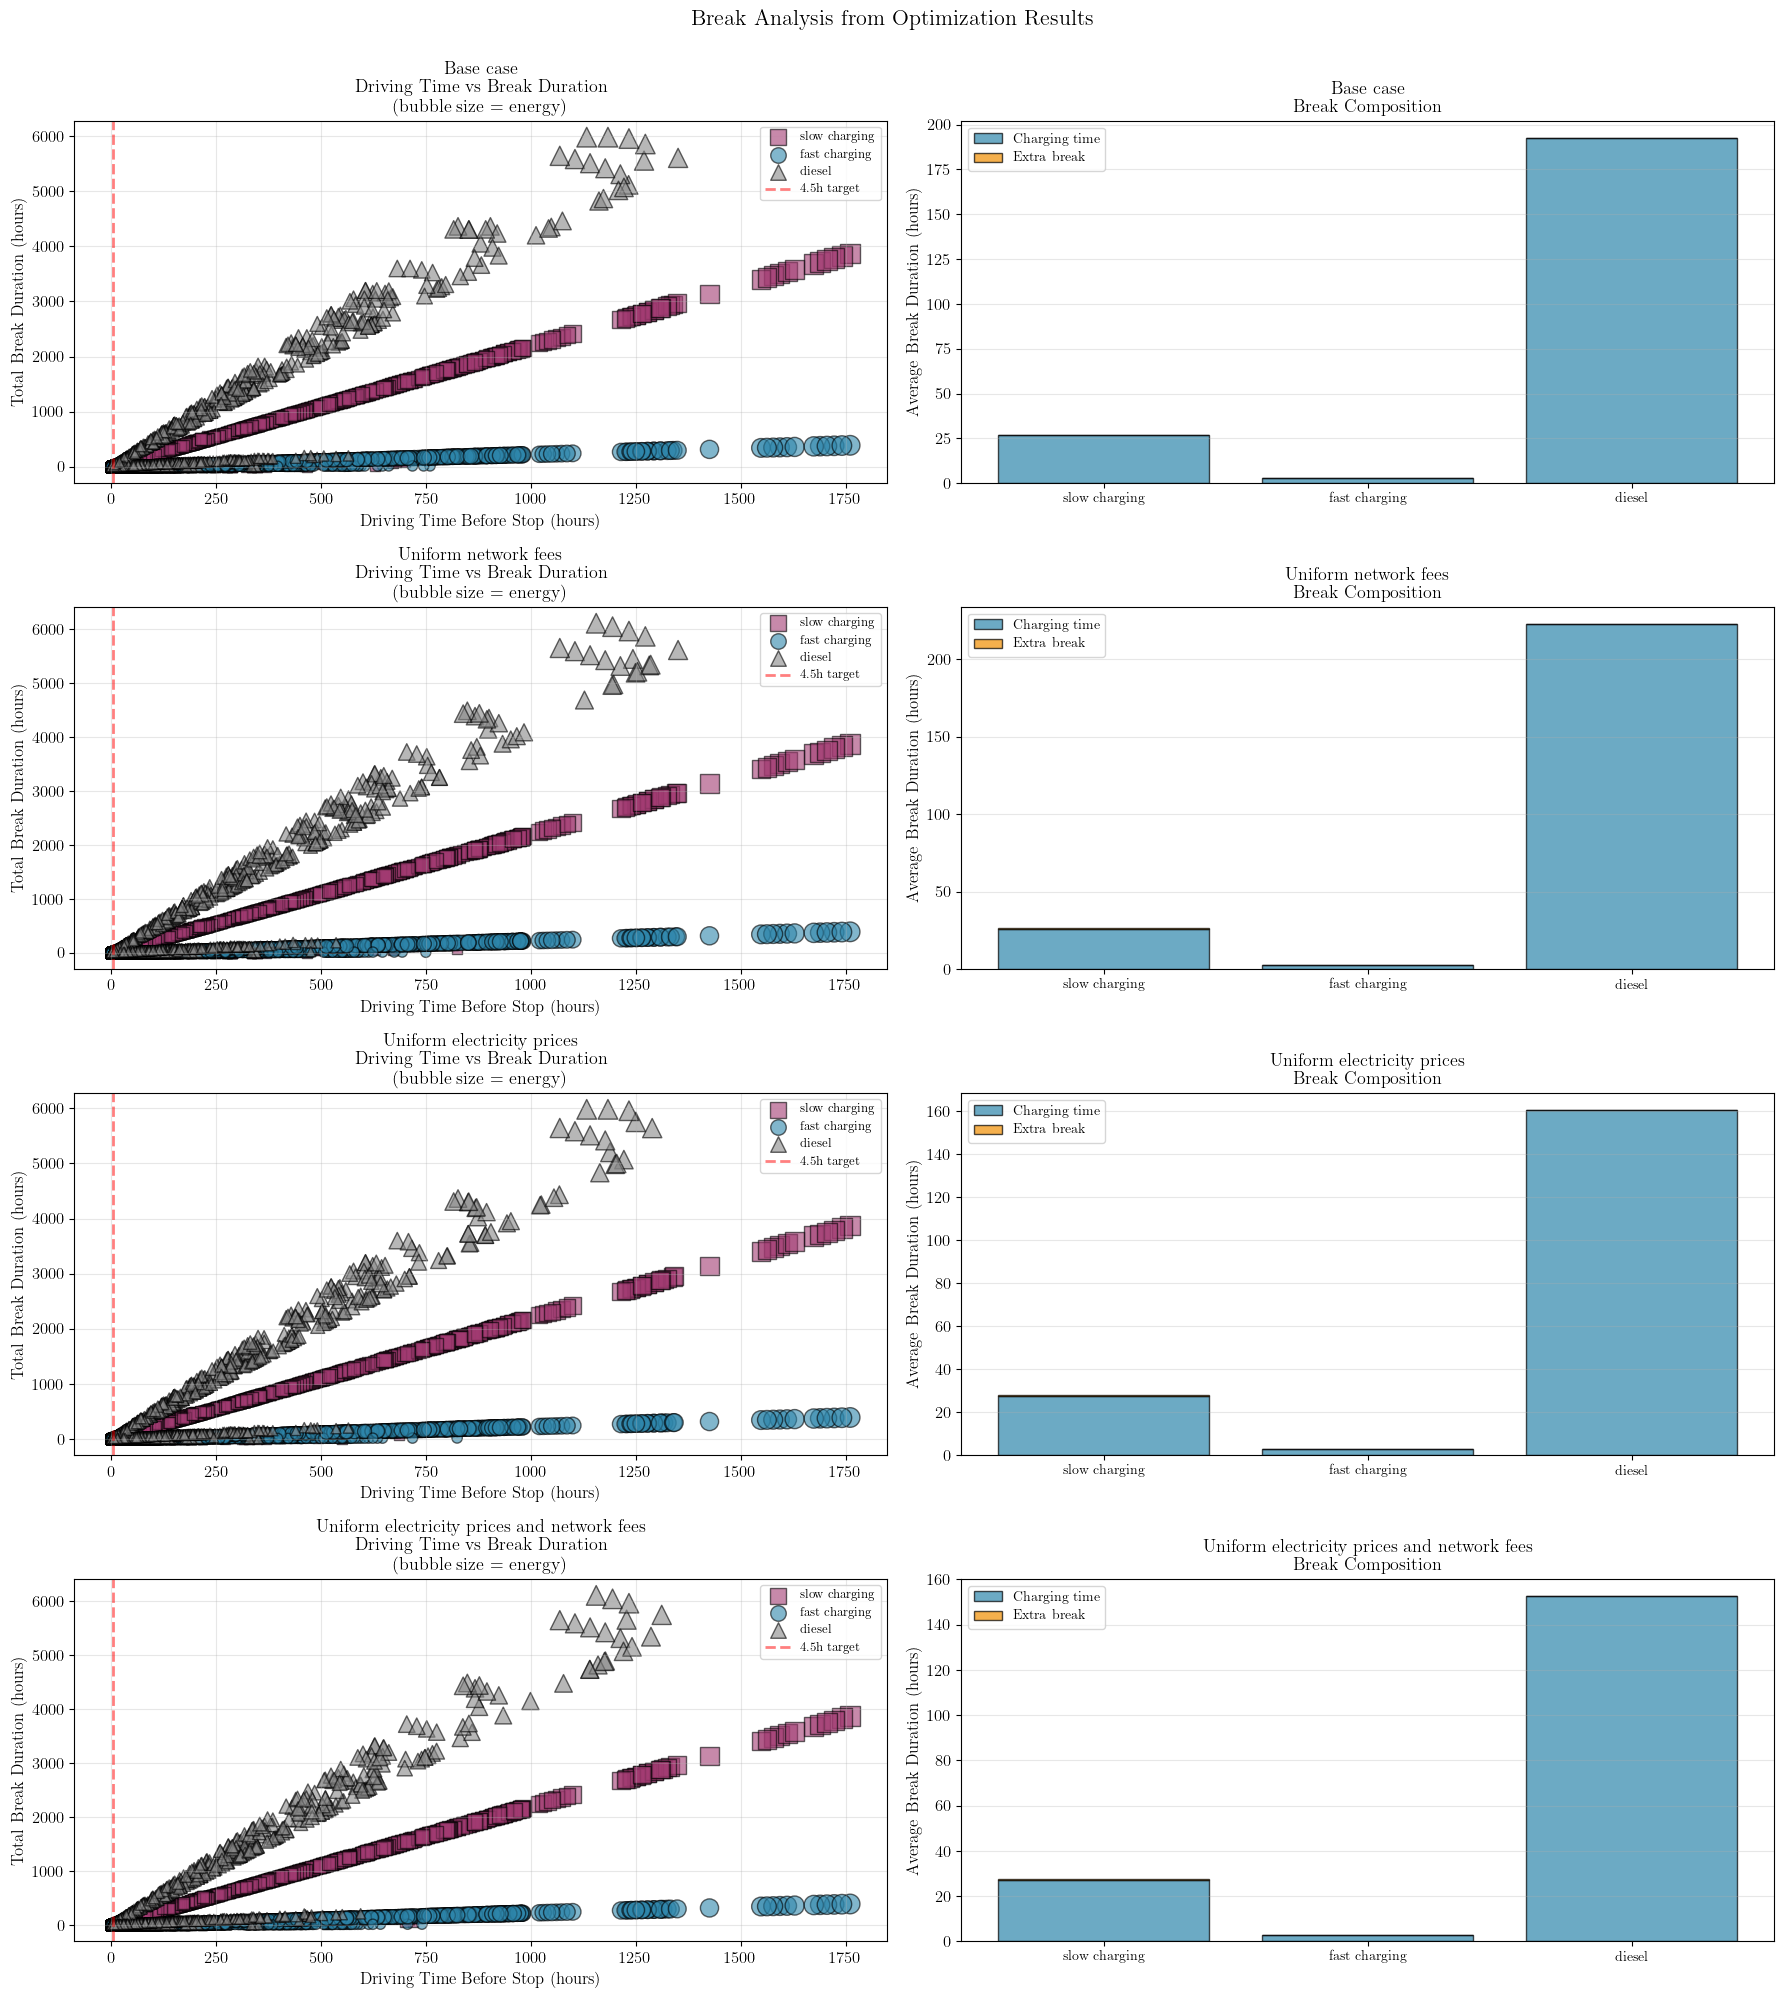

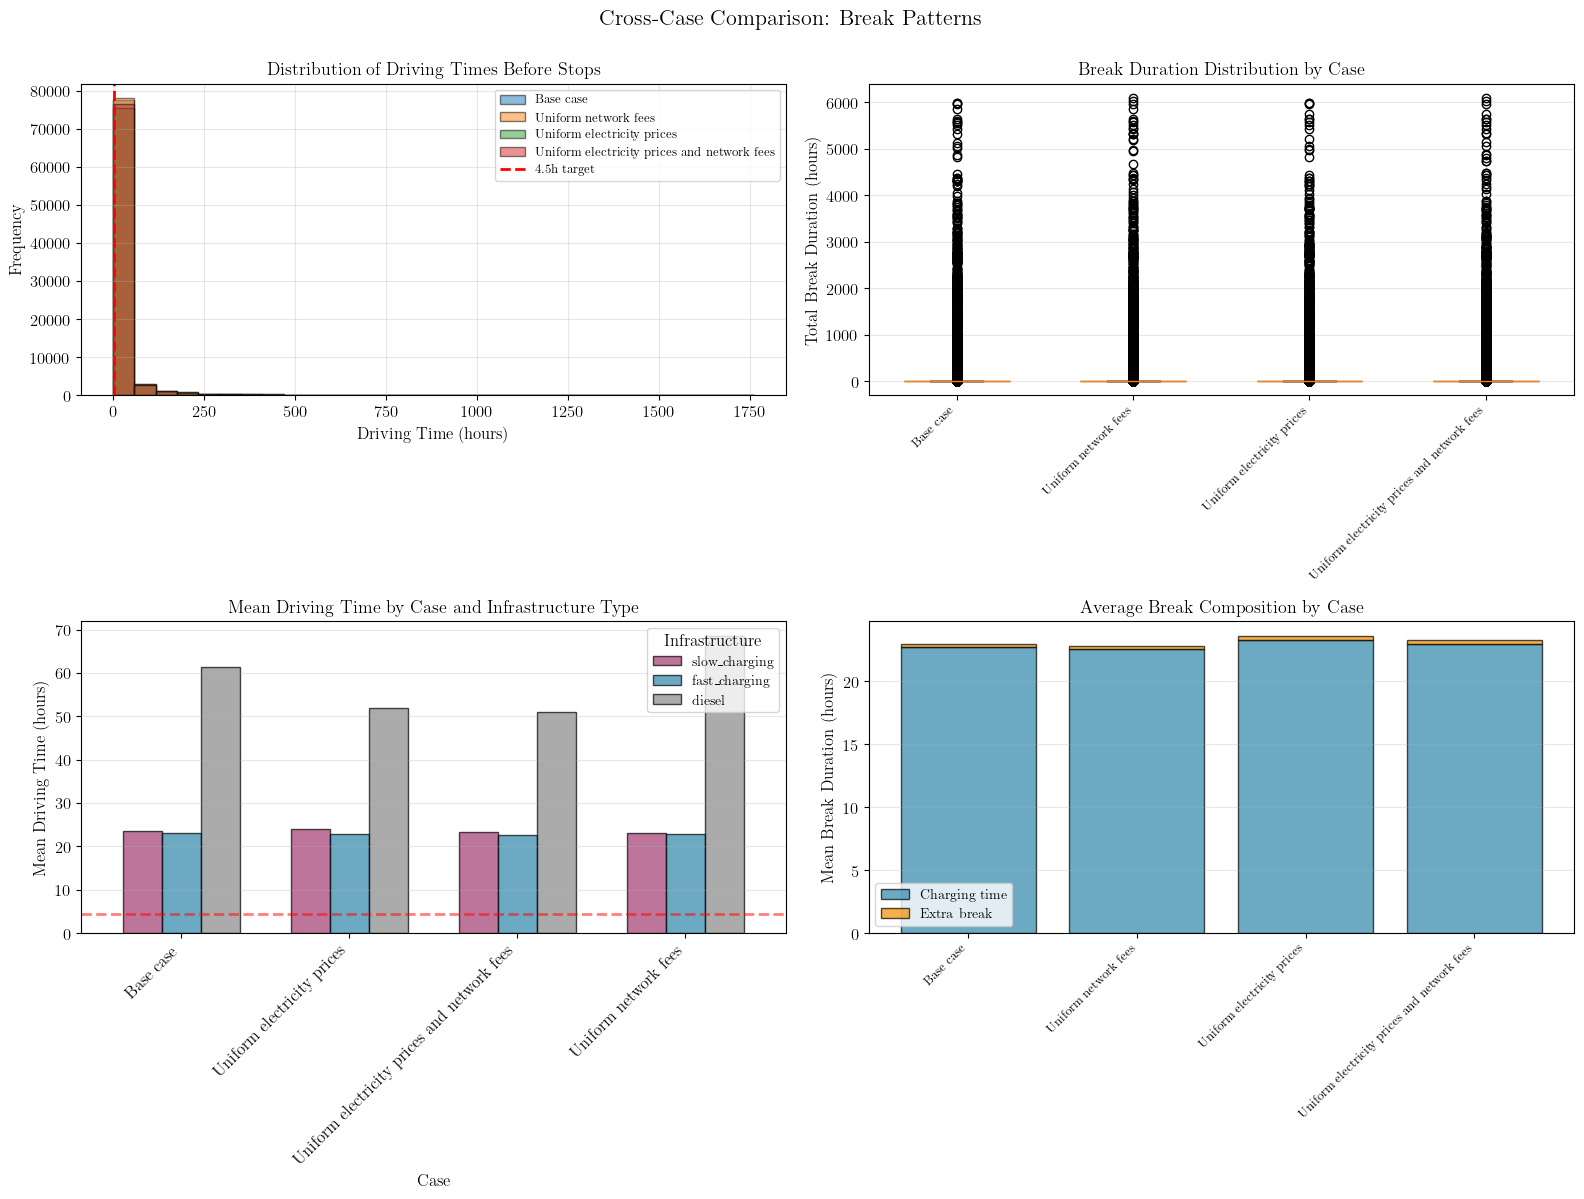


SUMMARY TABLE
                                                          driving_time         \
                                                                 count   mean   
case_label                                  infr_name                           
Base case                                   diesel                3858  61.42   
                                            fast_charging        40424  23.06   
                                            slow_charging        39952  23.44   
Uniform electricity prices                  diesel                4619  51.99   
                                            fast_charging        38758  22.78   
                                            slow_charging        38643  24.00   
Uniform electricity prices and network fees diesel                4827  50.88   
                                            fast_charging        39019  22.55   
                                            slow_charging        39061  23.23   
Uniform netwo

In [ ]:
"""
Break and Travel Time Analysis from Optimization Results

Extracts actual break patterns from model output by analyzing:
- Charging activity (implicit breaks)
- Extra break time (explicit breaks)
- Driving time between stops
"""

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

print("="*80)
print("EXTRACTING BREAKS FROM OPTIMIZATION RESULTS")
print("="*80)

# Extract breaks for all cases
all_trip_data = []

for case_name in case_study_names:
    case_data = loaded_runs[case_name]
    input_data = case_data['input_data']
    output_data = case_data['output_data']

    df_case = extract_breaks_from_charging(case_name, input_data, output_data)
    if len(df_case) > 0:
        df_case['case_label'] = case_study_name_labels[case_name]
        all_trip_data.append(df_case)

# Combine all cases
if len(all_trip_data) == 0:
    print("\n⚠️ No trip segment data extracted from any case!")
else:
    df_all_trips = pd.concat(all_trip_data, ignore_index=True)

    # Map infrastructure types
    infr_types = {0: 'diesel', 1: 'slow_charging', 2: 'fast_charging'}
    df_all_trips['infr_name'] = df_all_trips['infr_type'].map(infr_types)

    # Get ordered list of case labels
    case_labels_ordered = [case_study_name_labels[cn] for cn in case_study_names]

    print(f"\n" + "="*80)
    print("COMBINED ANALYSIS")
    print("="*80)
    print(f"\nTotal stops across all cases: {len(df_all_trips)}")
    print(f"\nBy case:")
    for case_label in case_labels_ordered:
        if case_label in df_all_trips['case_label'].values:
            subset = df_all_trips[df_all_trips['case_label'] == case_label]
            print(f"  {case_label}: {len(subset)} stops")
            print(f"    With charging: {len(subset[subset['charging_time'] > 0])}")
            print(f"    With extra break: {len(subset[subset['extra_break'] > 0])}")

    # Summary statistics by case
    print(f"\n" + "="*80)
    print("STATISTICS BY CASE")
    print("="*80)

    for case_label in case_labels_ordered:
        if case_label not in df_all_trips['case_label'].values:
            continue

        subset = df_all_trips[df_all_trips['case_label'] == case_label]
        print(f"\n{case_label}:")
        print(f"  Driving time before stop: mean={subset['driving_time'].mean():.2f}h, "
            f"median={subset['driving_time'].median():.2f}h")
        print(f"  Total break duration: mean={subset['total_break'].mean():.2f}h, "
            f"median={subset['total_break'].median():.2f}h")
        print(f"    Charging time: mean={subset['charging_time'].mean():.2f}h")
        print(f"    Extra break time: mean={subset['extra_break'].mean():.2f}h")

        print(f"  By infrastructure type:")
        for infr_name in ['slow_charging', 'fast_charging', 'diesel']:
            if infr_name in subset['infr_name'].values:
                infr_subset = subset[subset['infr_name'] == infr_name]
                print(f"    {infr_name}: {len(infr_subset)} stops, "
                    f"mean driving={infr_subset['driving_time'].mean():.2f}h, "
                    f"mean break={infr_subset['total_break'].mean():.2f}h")

    # ========================================================================
    # VISUALIZATION 1: PER-CASE DETAILED PLOTS
    # ========================================================================

    n_cases = len(case_labels_ordered)
    fig, axes = plt.subplots(n_cases, 2, figsize=(18, 5*n_cases))
    if n_cases == 1:
        axes = axes.reshape(1, -1)

    colors = {'slow_charging': '#A23B72', 'fast_charging': '#2E86AB', 'diesel': '#888888'}
    markers = {'slow_charging': 's', 'fast_charging': 'o', 'diesel': '^'}

    for idx, case_label in enumerate(case_labels_ordered):
        subset = df_all_trips[df_all_trips['case_label'] == case_label]

        if len(subset) == 0:
            axes[idx, 0].text(0.5, 0.5, 'No data', ha='center', va='center',
                            transform=axes[idx, 0].transAxes, fontsize=14)
            axes[idx, 1].text(0.5, 0.5, 'No data', ha='center', va='center',
                            transform=axes[idx, 1].transAxes, fontsize=14)
            continue

        # LEFT: Driving Time vs Total Break Duration
        ax = axes[idx, 0]

        for infr_name in ['slow_charging', 'fast_charging', 'diesel']:
            if infr_name in subset['infr_name'].values:
                infr_subset = subset[subset['infr_name'] == infr_name]

                # Size by energy charged (normalize per infrastructure type)
                if infr_subset['energy_kwh'].max() > 0:
                    sizes = (infr_subset['energy_kwh'] / infr_subset['energy_kwh'].max() * 150) + 50
                else:
                    sizes = 50

                ax.scatter(infr_subset['driving_time'], infr_subset['total_break'],
                        s=sizes, alpha=0.6, marker=markers[infr_name],
                        color=colors[infr_name],
                        label=f'{infr_name.replace("_", " ")}',
                        edgecolors='black', linewidths=1)

        ax.axvline(4.5, color='red', linestyle='--', linewidth=2, alpha=0.5, label='4.5h target')
        ax.set_xlabel('Driving Time Before Stop (hours)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Total Break Duration (hours)', fontsize=12, fontweight='bold')
        ax.set_title(f'{case_label}\nDriving Time vs Break Duration\n(bubble size = energy)',
                    fontsize=13, fontweight='bold')
        ax.legend(fontsize=9, loc='best')
        ax.grid(True, alpha=0.3)

        # RIGHT: Break composition (charging vs extra break)
        ax = axes[idx, 1]

        infr_names_present = [n for n in ['slow_charging', 'fast_charging', 'diesel']
                            if n in subset['infr_name'].values]
        charging_means = [subset[subset['infr_name'] == i]['charging_time'].mean()
                        for i in infr_names_present]
        extra_means = [subset[subset['infr_name'] == i]['extra_break'].mean()
                    for i in infr_names_present]

        x_pos = np.arange(len(infr_names_present))
        ax.bar(x_pos, charging_means, label='Charging time',
                color='#2E86AB', alpha=0.7, edgecolor='black')
        ax.bar(x_pos, extra_means, bottom=charging_means, label='Extra break',
                color='#F18F01', alpha=0.7, edgecolor='black')

        ax.set_xticks(x_pos)
        ax.set_xticklabels([n.replace('_', ' ') for n in infr_names_present], fontsize=10)
        ax.set_ylabel('Average Break Duration (hours)', fontsize=12, fontweight='bold')
        ax.set_title(f'{case_label}\nBreak Composition', fontsize=13, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3, axis='y')

    plt.suptitle('Break Analysis from Optimization Results',
                fontsize=16, fontweight='bold', y=0.998)
    plt.tight_layout()
    plt.show()

    # ========================================================================
    # VISUALIZATION 2: CROSS-CASE COMPARISON
    # ========================================================================

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Driving time distribution comparison
    ax = axes[0, 0]
    for case_label in case_labels_ordered:
        if case_label in df_all_trips['case_label'].values:
            subset = df_all_trips[df_all_trips['case_label'] == case_label]
            ax.hist(subset['driving_time'], bins=30, alpha=0.5,
                    label=case_label, edgecolor='black')
    ax.axvline(4.5, color='red', linestyle='--', linewidth=2, label='4.5h target')
    ax.set_xlabel('Driving Time (hours)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax.set_title('Distribution of Driving Times Before Stops',
                fontsize=13, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

    # 2. Break duration comparison (boxplot)
    ax = axes[0, 1]
    labels_with_data = [label for label in case_labels_ordered
                        if label in df_all_trips['case_label'].values]
    break_by_case = [df_all_trips[df_all_trips['case_label'] == label]['total_break'].values
                    for label in labels_with_data]

    bp = ax.boxplot(break_by_case, tick_labels=range(1, len(labels_with_data)+1),
                    patch_artist=True, widths=0.6)
    for i, patch in enumerate(bp['boxes']):
        patch.set_facecolor(plt.cm.viridis(i / len(labels_with_data)))
        patch.set_alpha(0.6)
    ax.set_xticks(range(1, len(labels_with_data)+1))
    ax.set_xticklabels(labels_with_data, rotation=45, ha='right', fontsize=9)
    ax.set_ylabel('Total Break Duration (hours)', fontsize=12, fontweight='bold')
    ax.set_title('Break Duration Distribution by Case', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

    # 3. Mean driving time by case and infrastructure type
    ax = axes[1, 0]
    driving_means = df_all_trips.groupby(['case_label', 'infr_name'])['driving_time'].mean().unstack()
    # Reorder columns
    col_order = [c for c in ['slow_charging', 'fast_charging', 'diesel']
                if c in driving_means.columns]
    driving_means = driving_means[col_order]

    driving_means.plot(kind='bar', ax=ax,
                    color=[colors.get(c, '#888888') for c in driving_means.columns],
                    width=0.7, edgecolor='black', alpha=0.7)
    ax.axhline(4.5, color='red', linestyle='--', linewidth=2, alpha=0.5)
    ax.set_xlabel('Case', fontsize=12, fontweight='bold')
    ax.set_ylabel('Mean Driving Time (hours)', fontsize=12, fontweight='bold')
    ax.set_title('Mean Driving Time by Case and Infrastructure Type',
                fontsize=13, fontweight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.legend(fontsize=10, title='Infrastructure')
    ax.grid(True, alpha=0.3, axis='y')

    # 4. Break composition stacked bar (by case)
    ax = axes[1, 1]
    charging_by_case = df_all_trips.groupby('case_label')['charging_time'].mean()
    extra_by_case = df_all_trips.groupby('case_label')['extra_break'].mean()

    # Reorder to match case_labels_ordered
    charging_ordered = [charging_by_case.get(label, 0) for label in labels_with_data]
    extra_ordered = [extra_by_case.get(label, 0) for label in labels_with_data]

    x_pos = np.arange(len(labels_with_data))
    ax.bar(x_pos, charging_ordered, label='Charging time',
            color='#2E86AB', alpha=0.7, edgecolor='black')
    ax.bar(x_pos, extra_ordered, bottom=charging_ordered, label='Extra break',
            color='#F18F01', alpha=0.7, edgecolor='black')

    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels_with_data, rotation=45, ha='right', fontsize=9)
    ax.set_ylabel('Mean Break Duration (hours)', fontsize=12, fontweight='bold')
    ax.set_title('Average Break Composition by Case', fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')

    plt.suptitle('Cross-Case Comparison: Break Patterns',
                fontsize=16, fontweight='bold', y=0.998)
    plt.tight_layout()
    plt.show()

    # ========================================================================
    # SUMMARY TABLE
    # ========================================================================

    print(f"\n" + "="*80)
    print("SUMMARY TABLE")
    print("="*80)

    summary = df_all_trips.groupby(['case_label', 'infr_name']).agg({
        'driving_time': ['count', 'mean', 'median', 'std'],
        'total_break': ['mean', 'median'],
        'charging_time': 'mean',
        'extra_break': 'mean',
        'energy_kwh': 'sum'
    }).round(2)
    print(summary)

    # Export summary to CSV
    summary_flat = summary.copy()
    summary_flat.columns = ['_'.join(col).strip() for col in summary_flat.columns.values]
    summary_flat.to_csv('break_analysis_summary.csv')
    print(f"\nExported: break_analysis_summary.csv")

EXTRACTING BREAKS WITH VEHICLE WEIGHTS

case_20251028_091344_var_var:
  Travel time entries: 163929
  Extra break time entries: 14068
  Charging events: 147050
  Charging powers: {1: 100, 2: 1000, 0: 10000}
  Consolidated charging events: 147050
  Explicit extra breaks: 14068
  Routes found: 130269
  Trip segments extracted: 84234

case_20251028_091344_var_var:
  Processing 84234 trip segments
  Vehicle stock entries: 308470
  Non-zero vehicle stock entries: 308470
  Matched 84234/84234 segments to vehicle stock (100.0%)

case_20251028_091411_var_uni:
  Travel time entries: 164760
  Extra break time entries: 14063
  Charging events: 148350
  Charging powers: {1: 100, 2: 1000, 0: 10000}
  Consolidated charging events: 148350
  Explicit extra breaks: 14063
  Routes found: 131109
  Trip segments extracted: 84571

case_20251028_091411_var_uni:
  Processing 84571 trip segments
  Vehicle stock entries: 308271
  Non-zero vehicle stock entries: 308271
  Matched 84571/84571 segments to vehicle 

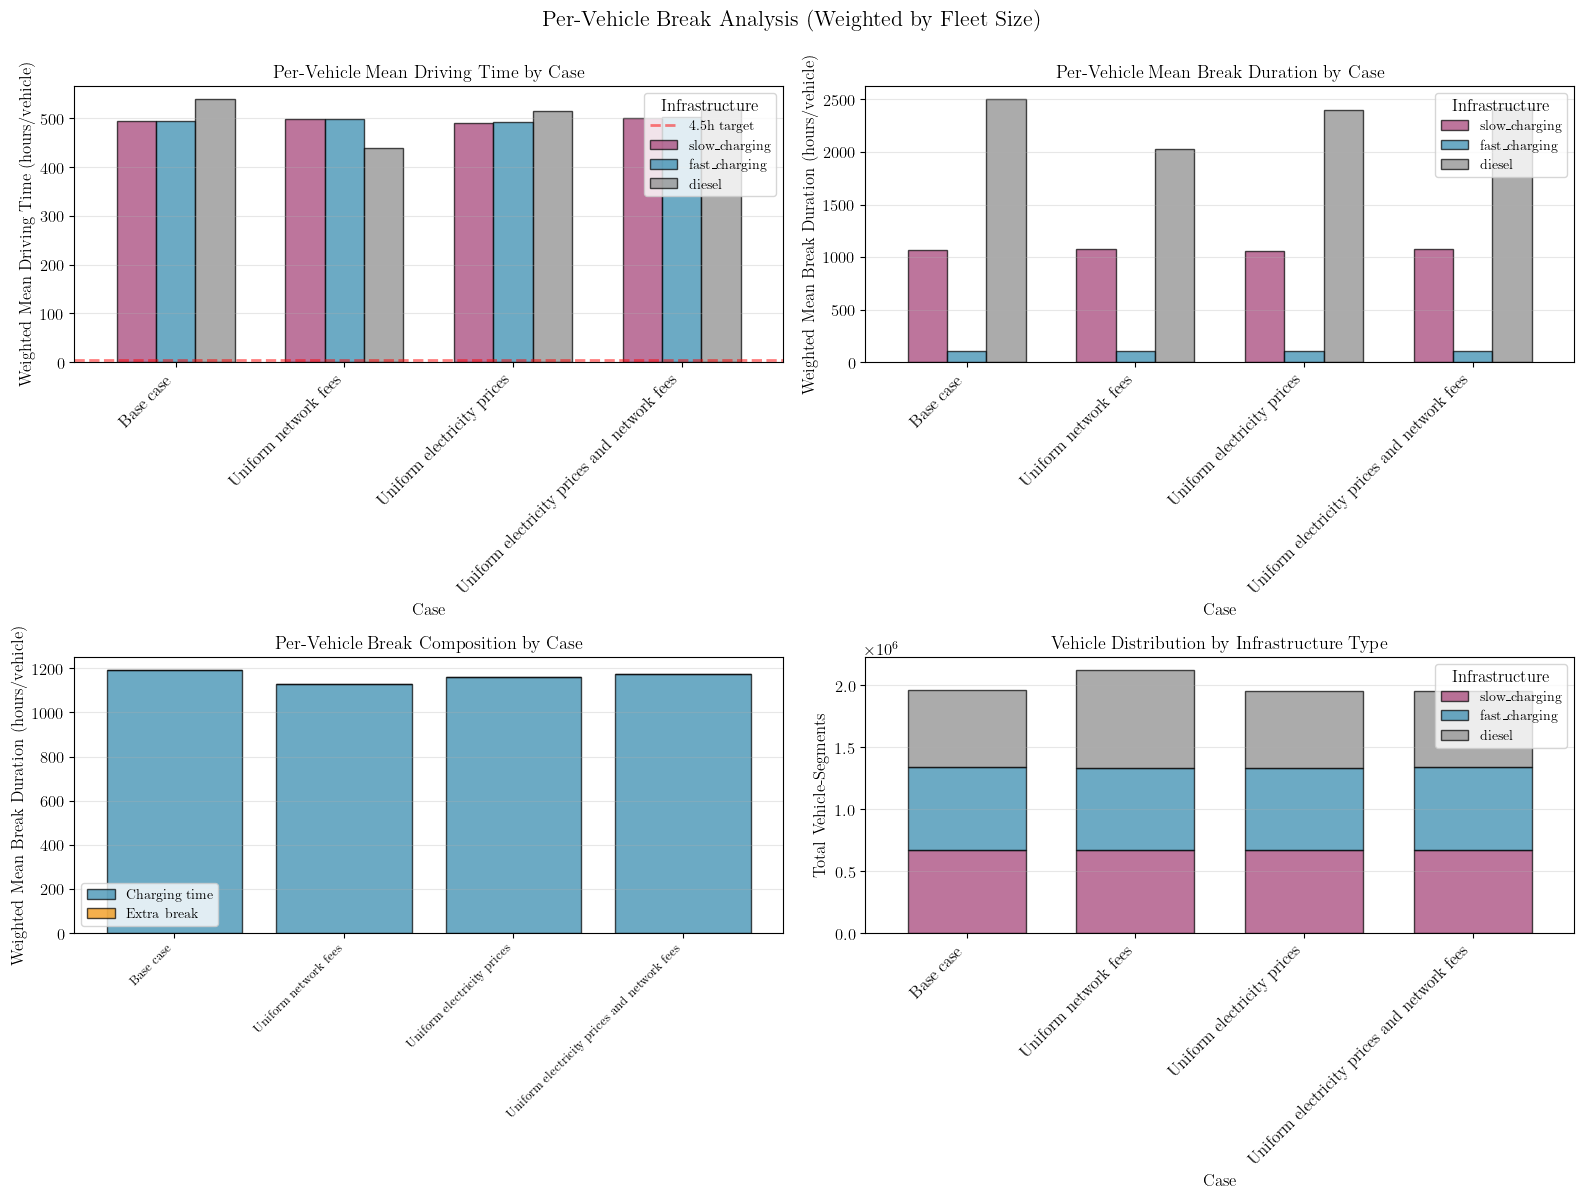


WEIGHTED SUMMARY TABLE
                                       case infrastructure  vehicle_segments  weighted_driving_time  weighted_total_break  weighted_charging_time  weighted_extra_break  total_energy_kwh
                                  Base case  slow_charging         672125.17                 494.62               1063.92                 1063.73                  0.19      7.149584e+10
                                  Base case  fast_charging         669287.47                 495.27                106.96                  106.79                  0.17      7.147084e+10
                                  Base case         diesel         619136.64                 539.48               2502.47                 2502.47                  0.00      1.549368e+13
                       Uniform network fees  slow_charging         668523.17                 499.18               1073.90                 1073.71                  0.19      7.177969e+10
                       Uniform network fees  f

In [ ]:
"""
Per-Vehicle Break and Travel Time Analysis

Uses vehicle stock (h) to calculate weighted average break patterns
per vehicle operating on routes.
"""

def add_vehicle_weights(df_trips, case_name, output_data):
    """
    Add vehicle stock weights to trip segments.

    Parameters:
    - df_trips: DataFrame with trip segments
    - case_name: Case identifier
    - output_data: Dict with 'h' variable (vehicle stock)

    Returns:
    - DataFrame with 'vehicle_stock' column added
    """

    h_data = output_data.get('h', {})

    print(f"\n{case_name}:")
    print(f"  Processing {len(df_trips)} trip segments")
    print(f"  Vehicle stock entries: {len(h_data)}")

    # Parse h data into lookup dict
    # h key format: (year, odpair, techvehicle, generation)
    h_lookup = {}
    for key, stock in h_data.items():
        if stock > 0:
            year, odpair, techvehicle, generation = key
            h_lookup[(year, odpair, techvehicle, generation)] = stock

    print(f"  Non-zero vehicle stock entries: {len(h_lookup)}")

    # Add vehicle stock to each trip segment
    vehicle_stocks = []
    for idx, row in df_trips.iterrows():
        lookup_key = (row['year'], row['odpair'], row['techvehicle'], row['generation'])
        stock = h_lookup.get(lookup_key, 0)
        vehicle_stocks.append(stock)

    df_trips['vehicle_stock'] = vehicle_stocks

    # Report matching
    matched = len(df_trips[df_trips['vehicle_stock'] > 0])
    print(f"  Matched {matched}/{len(df_trips)} segments to vehicle stock ({matched/len(df_trips)*100:.1f}%)")

    return df_trips


# Re-extract with vehicle weights
print("="*80)
print("EXTRACTING BREAKS WITH VEHICLE WEIGHTS")
print("="*80)

all_trip_data_weighted = []

for case_name in case_study_names:
    case_data = loaded_runs[case_name]
    input_data = case_data['input_data']
    output_data = case_data['output_data']

    # Extract trip segments
    df_case = extract_breaks_from_charging(case_name, input_data, output_data)

    if len(df_case) > 0:
        # Add vehicle weights
        df_case = add_vehicle_weights(df_case, case_name, output_data)
        df_case['case_label'] = case_study_name_labels[case_name]
        all_trip_data_weighted.append(df_case)

# Combine all cases
if len(all_trip_data_weighted) == 0:
    print("\n⚠️ No weighted trip data extracted!")
else:
    df_weighted = pd.concat(all_trip_data_weighted, ignore_index=True)

    # Map infrastructure types
    infr_types = {0: 'diesel', 1: 'slow_charging', 2: 'fast_charging'}
    df_weighted['infr_name'] = df_weighted['infr_type'].map(infr_types)

    # Filter to segments with vehicle stock
    df_weighted = df_weighted[df_weighted['vehicle_stock'] > 0].copy()

    print(f"\n" + "="*80)
    print("PER-VEHICLE WEIGHTED ANALYSIS")
    print("="*80)
    print(f"\nTotal segments with vehicles: {len(df_weighted)}")
    print(f"Total vehicle-segments: {df_weighted['vehicle_stock'].sum():.0f}")

    # Calculate weighted statistics
    case_labels_ordered = [case_study_name_labels[cn] for cn in case_study_names]

    print(f"\n" + "="*80)
    print("WEIGHTED STATISTICS BY CASE")
    print("="*80)

    for case_label in case_labels_ordered:
        if case_label not in df_weighted['case_label'].values:
            continue

        subset = df_weighted[df_weighted['case_label'] == case_label]
        total_vehicles = subset['vehicle_stock'].sum()

        # Weighted means
        weighted_driving = (subset['driving_time'] * subset['vehicle_stock']).sum() / total_vehicles
        weighted_break = (subset['total_break'] * subset['vehicle_stock']).sum() / total_vehicles
        weighted_charging = (subset['charging_time'] * subset['vehicle_stock']).sum() / total_vehicles
        weighted_extra = (subset['extra_break'] * subset['vehicle_stock']).sum() / total_vehicles

        print(f"\n{case_label}:")
        print(f"  Total vehicle-segments: {total_vehicles:.0f}")
        print(f"  Weighted mean driving time: {weighted_driving:.2f}h")
        print(f"  Weighted mean total break: {weighted_break:.2f}h")
        print(f"    - Charging time: {weighted_charging:.2f}h")
        print(f"    - Extra break: {weighted_extra:.2f}h")

        print(f"  By infrastructure type:")
        for infr_name in ['slow_charging', 'fast_charging', 'diesel']:
            if infr_name in subset['infr_name'].values:
                infr_subset = subset[subset['infr_name'] == infr_name]
                infr_vehicles = infr_subset['vehicle_stock'].sum()

                w_driving = (infr_subset['driving_time'] * infr_subset['vehicle_stock']).sum() / infr_vehicles
                w_break = (infr_subset['total_break'] * infr_subset['vehicle_stock']).sum() / infr_vehicles

                print(f"    {infr_name}: {infr_vehicles:.0f} vehicle-segments, "
                    f"mean driving={w_driving:.2f}h, mean break={w_break:.2f}h")

    # ========================================================================
    # VISUALIZATION: WEIGHTED COMPARISON
    # ========================================================================

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    colors = {'slow_charging': '#A23B72', 'fast_charging': '#2E86AB', 'diesel': '#888888'}

    # 1. Weighted mean driving time by case
    ax = axes[0, 0]

    weighted_driving_by_case = {}
    for case_label in case_labels_ordered:
        if case_label in df_weighted['case_label'].values:
            subset = df_weighted[df_weighted['case_label'] == case_label]

            by_infr = {}
            for infr_name in ['slow_charging', 'fast_charging', 'diesel']:
                if infr_name in subset['infr_name'].values:
                    infr_subset = subset[subset['infr_name'] == infr_name]
                    total_veh = infr_subset['vehicle_stock'].sum()
                    if total_veh > 0:
                        by_infr[infr_name] = (infr_subset['driving_time'] * infr_subset['vehicle_stock']).sum() / total_veh

            weighted_driving_by_case[case_label] = by_infr

    df_plot = pd.DataFrame(weighted_driving_by_case).T
    df_plot.plot(kind='bar', ax=ax, color=[colors.get(c, '#888888') for c in df_plot.columns],
                width=0.7, edgecolor='black', alpha=0.7)
    ax.axhline(4.5, color='red', linestyle='--', linewidth=2, alpha=0.5, label='4.5h target')
    ax.set_xlabel('Case', fontsize=12, fontweight='bold')
    ax.set_ylabel('Weighted Mean Driving Time (hours/vehicle)', fontsize=12, fontweight='bold')
    ax.set_title('Per-Vehicle Mean Driving Time by Case', fontsize=13, fontweight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.legend(fontsize=10, title='Infrastructure')
    ax.grid(True, alpha=0.3, axis='y')

    # 2. Weighted mean break duration by case
    ax = axes[0, 1]

    weighted_break_by_case = {}
    for case_label in case_labels_ordered:
        if case_label in df_weighted['case_label'].values:
            subset = df_weighted[df_weighted['case_label'] == case_label]

            by_infr = {}
            for infr_name in ['slow_charging', 'fast_charging', 'diesel']:
                if infr_name in subset['infr_name'].values:
                    infr_subset = subset[subset['infr_name'] == infr_name]
                    total_veh = infr_subset['vehicle_stock'].sum()
                    if total_veh > 0:
                        by_infr[infr_name] = (infr_subset['total_break'] * infr_subset['vehicle_stock']).sum() / total_veh

            weighted_break_by_case[case_label] = by_infr

    df_plot = pd.DataFrame(weighted_break_by_case).T
    df_plot.plot(kind='bar', ax=ax, color=[colors.get(c, '#888888') for c in df_plot.columns],
                width=0.7, edgecolor='black', alpha=0.7)
    ax.set_xlabel('Case', fontsize=12, fontweight='bold')
    ax.set_ylabel('Weighted Mean Break Duration (hours/vehicle)', fontsize=12, fontweight='bold')
    ax.set_title('Per-Vehicle Mean Break Duration by Case', fontsize=13, fontweight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.legend(fontsize=10, title='Infrastructure')
    ax.grid(True, alpha=0.3, axis='y')

    # 3. Break composition (weighted)
    ax = axes[1, 0]

    for case_label in case_labels_ordered:
        if case_label not in df_weighted['case_label'].values:
            continue

        subset = df_weighted[df_weighted['case_label'] == case_label]
        total_veh = subset['vehicle_stock'].sum()

        charging_weighted = (subset['charging_time'] * subset['vehicle_stock']).sum() / total_veh
        extra_weighted = (subset['extra_break'] * subset['vehicle_stock']).sum() / total_veh

    charging_by_case = []
    extra_by_case = []
    labels_with_data = []

    for case_label in case_labels_ordered:
        if case_label in df_weighted['case_label'].values:
            subset = df_weighted[df_weighted['case_label'] == case_label]
            total_veh = subset['vehicle_stock'].sum()

            charging_by_case.append((subset['charging_time'] * subset['vehicle_stock']).sum() / total_veh)
            extra_by_case.append((subset['extra_break'] * subset['vehicle_stock']).sum() / total_veh)
            labels_with_data.append(case_label)

    x_pos = np.arange(len(labels_with_data))
    ax.bar(x_pos, charging_by_case, label='Charging time',
            color='#2E86AB', alpha=0.7, edgecolor='black')
    ax.bar(x_pos, extra_by_case, bottom=charging_by_case, label='Extra break',
            color='#F18F01', alpha=0.7, edgecolor='black')

    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels_with_data, rotation=45, ha='right', fontsize=9)
    ax.set_ylabel('Weighted Mean Break Duration (hours/vehicle)', fontsize=12, fontweight='bold')
    ax.set_title('Per-Vehicle Break Composition by Case', fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')

    # 4. Vehicle distribution by infrastructure type
    ax = axes[1, 1]

    vehicle_by_infr = {}
    for case_label in case_labels_ordered:
        if case_label in df_weighted['case_label'].values:
            subset = df_weighted[df_weighted['case_label'] == case_label]

            by_infr = {}
            for infr_name in ['slow_charging', 'fast_charging', 'diesel']:
                if infr_name in subset['infr_name'].values:
                    infr_subset = subset[subset['infr_name'] == infr_name]
                    by_infr[infr_name] = infr_subset['vehicle_stock'].sum()

            vehicle_by_infr[case_label] = by_infr

    df_plot = pd.DataFrame(vehicle_by_infr).T
    df_plot.plot(kind='bar', ax=ax, color=[colors.get(c, '#888888') for c in df_plot.columns],
                width=0.7, edgecolor='black', alpha=0.7, stacked=True)
    ax.set_xlabel('Case', fontsize=12, fontweight='bold')
    ax.set_ylabel('Total Vehicle-Segments', fontsize=12, fontweight='bold')
    ax.set_title('Vehicle Distribution by Infrastructure Type', fontsize=13, fontweight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.legend(fontsize=10, title='Infrastructure')
    ax.grid(True, alpha=0.3, axis='y')

    plt.suptitle('Per-Vehicle Break Analysis (Weighted by Fleet Size)',
                fontsize=16, fontweight='bold', y=0.998)
    plt.tight_layout()
    plt.show()

    # Export weighted summary
    print(f"\n" + "="*80)
    print("WEIGHTED SUMMARY TABLE")
    print("="*80)

    summary_data = []
    for case_label in case_labels_ordered:
        if case_label not in df_weighted['case_label'].values:
            continue

        subset = df_weighted[df_weighted['case_label'] == case_label]

        for infr_name in ['slow_charging', 'fast_charging', 'diesel']:
            if infr_name in subset['infr_name'].values:
                infr_subset = subset[subset['infr_name'] == infr_name]
                total_veh = infr_subset['vehicle_stock'].sum()

                if total_veh > 0:
                    summary_data.append({
                        'case': case_label,
                        'infrastructure': infr_name,
                        'vehicle_segments': total_veh,
                        'weighted_driving_time': (infr_subset['driving_time'] * infr_subset['vehicle_stock']).sum() / total_veh,
                        'weighted_total_break': (infr_subset['total_break'] * infr_subset['vehicle_stock']).sum() / total_veh,
                        'weighted_charging_time': (infr_subset['charging_time'] * infr_subset['vehicle_stock']).sum() / total_veh,
                        'weighted_extra_break': (infr_subset['extra_break'] * infr_subset['vehicle_stock']).sum() / total_veh,
                        'total_energy_kwh': (infr_subset['energy_kwh'] * infr_subset['vehicle_stock']).sum()
                    })

    df_summary = pd.DataFrame(summary_data)
    print(df_summary.round(2).to_string(index=False))

    df_summary.to_csv('per_vehicle_break_analysis.csv', index=False)
    print(f"\nExported: per_vehicle_break_analysis.csv")

In [ ]:
"""
DEBUG: Understanding travel_time and constraint enforcement
"""

case_name = case_study_names[0]
case_data = loaded_runs[case_name]
input_data = case_data['input_data']
output_data = case_data['output_data']

travel_time_data = output_data.get('travel_time', {})
extra_break_data = output_data.get('extra_break_time', {})
energy_data = output_data.get('s', {})

# Find one specific route with multiple stops
print("Finding a route with multiple breaks...")

route_stops = {}
for key, extra_break in extra_break_data.items():
    if extra_break > 0:
        year, prkg, techvehicle, fuel_infr, generation = key
        product, odpair, path, geo = prkg
        fuel_id, infr_type = fuel_infr

        route_key = (year, odpair, path, techvehicle, fuel_infr, generation)
        if route_key not in route_stops:
            route_stops[route_key] = []

        route_stops[route_key].append({
            'geo': geo,
            'extra_break': extra_break,
            'infr_type': infr_type
        })

# Find a route with multiple stops
multi_stop_route = None
for route_key, stops in route_stops.items():
    if len(stops) >= 3:  # At least 3 stops
        multi_stop_route = route_key
        break

if multi_stop_route:
    year, odpair, path, techvehicle, fuel_infr, generation = multi_stop_route
    fuel_id, infr_type = fuel_infr

    print(f"\n{'='*80}")
    print(f"ANALYZING ROUTE:")
    print(f"  Year: {year}, OD-pair: {odpair}, Path: {path}")
    print(f"  TechVehicle: {techvehicle}, Infrastructure: {infr_type}, Generation: {generation}")
    print(f"{'='*80}")

    # Get ALL locations on this path (not just where breaks occur)
    path_locations = []
    for key, tt in travel_time_data.items():
        if (key[0] == year and
            key[1][1] == odpair and
            key[1][2] == path and
            key[2] == techvehicle and
            key[3] == fuel_infr and
            key[4] == generation):

            geo = key[1][3]

            # Check for break at this location
            extra_break = extra_break_data.get(key, 0)

            # Check for charging at this location
            charging_kwh = energy_data.get(key, 0)

            path_locations.append({
                'geo': geo,
                'travel_time': tt,
                'extra_break': extra_break,
                'charging_kwh': charging_kwh,
                'has_break': extra_break > 0 or charging_kwh > 0
            })

    # Sort by travel time
    path_locations.sort(key=lambda x: x['travel_time'])

    print(f"\nTotal locations on path: {len(path_locations)}")
    print(f"Locations with breaks: {sum(1 for loc in path_locations if loc['has_break'])}")

    print(f"\n{'Seq':<5} {'Geo':<8} {'Travel Time':<12} {'Δ Time':<12} {'Extra Break':<12} {'Charging':<12} {'Has Break':<10}")
    print("-" * 90)

    prev_tt = 0
    for i, loc in enumerate(path_locations[:20]):  # Show first 20 locations
        delta_time = loc['travel_time'] - prev_tt

        print(f"{i:<5} {loc['geo']:<8} {loc['travel_time']:<12.2f} {delta_time:<12.2f} "
            f"{loc['extra_break']:<12.2f} {loc['charging_kwh']:<12.2f} "
            f"{'YES' if loc['has_break'] else 'NO':<10}")

        prev_tt = loc['travel_time']

    print(f"\n{'='*80}")
    print("OBSERVATIONS TO CHECK:")
    print(f"{'='*80}")

    # Calculate time between breaks
    break_locations = [loc for loc in path_locations if loc['has_break']]

    if len(break_locations) >= 2:
        print(f"\nTime between consecutive BREAKS:")
        prev_break_time = 0
        for i, loc in enumerate(break_locations):
            if i == 0:
                time_since_last = loc['travel_time']
            else:
                time_since_last = loc['travel_time'] - prev_break_time

            print(f"  Break {i+1} at geo {loc['geo']}: {time_since_last:.2f}h since last break")
            prev_break_time = loc['travel_time']

    print(f"\n{'='*80}")
    print("KEY QUESTIONS:")
    print(f"{'='*80}")
    print("1. Does 'Δ Time' between ALL locations make sense as pure driving time?")
    print("   (Should be small values like 0.5-2 hours if it's just driving between nodes)")
    print()
    print("2. Does 'Time between consecutive BREAKS' exceed 4.5 hours?")
    print("   (If YES, constraint is violated OR travel_time includes breaks)")
    print()
    print("3. Do locations WITHOUT breaks still have travel_time increments?")
    print("   (If YES, travel_time includes driving between all nodes, not just break points)")

else:
    print("No route found with multiple stops!")

Finding a route with multiple breaks...
No route found with multiple stops!


In [ ]:
"""
DEBUG: Check routes with single or no breaks
"""

case_name = case_study_names[0]
case_data = loaded_runs[case_name]
output_data = case_data['output_data']

travel_time_data = output_data.get('travel_time', {})
extra_break_data = output_data.get('extra_break_time', {})
energy_data = output_data.get('s', {})

# Count breaks per route
route_stops = {}
for key, extra_break in extra_break_data.items():
    if extra_break > 0:
        year, prkg, techvehicle, fuel_infr, generation = key
        product, odpair, path, geo = prkg

        route_key = (year, odpair, path, techvehicle, fuel_infr, generation)
        if route_key not in route_stops:
            route_stops[route_key] = 0
        route_stops[route_key] += 1

# Analyze break distribution
break_counts = {}
for route, count in route_stops.items():
    if count not in break_counts:
        break_counts[count] = 0
    break_counts[count] += 1

print("="*80)
print("BREAK DISTRIBUTION PER ROUTE")
print("="*80)
for num_breaks in sorted(break_counts.keys()):
    print(f"  {num_breaks} break(s): {break_counts[num_breaks]} routes")

print(f"\nTotal routes with breaks: {len(route_stops)}")

# Now check a route with 1 break
single_break_route = None
for route_key, count in route_stops.items():
    if count == 1:
        single_break_route = route_key
        break

if single_break_route:
    year, odpair, path, techvehicle, fuel_infr, generation = single_break_route
    fuel_id, infr_type = fuel_infr

    print(f"\n{'='*80}")
    print(f"ANALYZING ROUTE WITH 1 BREAK:")
    print(f"  Year: {year}, OD-pair: {odpair}, Path: {path}")
    print(f"  TechVehicle: {techvehicle}, Infrastructure: {infr_type}, Generation: {generation}")
    print(f"{'='*80}")

    # Get all locations on this path
    path_locations = []
    for key, tt in travel_time_data.items():
        if (key[0] == year and
            key[1][1] == odpair and
            key[1][2] == path and
            key[2] == techvehicle and
            key[3] == fuel_infr and
            key[4] == generation):

            geo = key[1][3]
            extra_break = extra_break_data.get(key, 0)
            charging_kwh = energy_data.get(key, 0)

            path_locations.append({
                'geo': geo,
                'travel_time': tt,
                'extra_break': extra_break,
                'charging_kwh': charging_kwh
            })

    path_locations.sort(key=lambda x: x['travel_time'])

    print(f"\nLocations on this path: {len(path_locations)}")
    print(f"\n{'Seq':<5} {'Geo':<8} {'Travel Time':<12} {'Extra Break':<12} {'Charging (kWh)':<15}")
    print("-" * 60)

    for i, loc in enumerate(path_locations[:10]):
        print(f"{i:<5} {loc['geo']:<8} {loc['travel_time']:<12.2f} "
            f"{loc['extra_break']:<12.2f} {loc['charging_kwh']:<15.2f}")

    if len(path_locations) > 10:
        print("...")

    print(f"\n{'='*80}")
    print("INTERPRETATION:")
    print(f"{'='*80}")
    print(f"If each route only has 1 break location:")
    print(f"  - travel_time at that location = time to reach that point")
    print(f"  - This could be VERY LONG if it's far into the route")
    print(f"  - My 'segment calculation' assumes multiple breaks per route!")
    print(f"\nThe issue: I'm calculating 'driving_time = travel_time - segment_start_time'")
    print(f"But if there's only 1 break per route, segment_start_time = 0")
    print(f"So driving_time = entire travel_time to that location!")

# Check how many locations per path typically
print(f"\n{'='*80}")
print("PATH STRUCTURE ANALYSIS")
print(f"{'='*80}")

# Sample a few paths
paths_sampled = {}
for key in list(travel_time_data.keys())[:1000]:  # Sample 1000 entries
    year, prkg, techvehicle, fuel_infr, generation = key
    product, odpair, path, geo = prkg

    path_key = (year, odpair, path, techvehicle, fuel_infr, generation)
    if path_key not in paths_sampled:
        paths_sampled[path_key] = 0
    paths_sampled[path_key] += 1

if paths_sampled:
    location_counts = list(paths_sampled.values())
    print(f"Sampled {len(paths_sampled)} unique paths")
    print(f"Locations per path:")
    print(f"  Min: {min(location_counts)}")
    print(f"  Max: {max(location_counts)}")
    print(f"  Mean: {sum(location_counts)/len(location_counts):.1f}")

BREAK DISTRIBUTION PER ROUTE
  1 break(s): 12576 routes
  2 break(s): 746 routes

Total routes with breaks: 13322

ANALYZING ROUTE WITH 1 BREAK:
  Year: 2030, OD-pair: 1215, Path: 1215
  TechVehicle: 1, Infrastructure: 1, Generation: 2026

Locations on this path: 3

Seq   Geo      Travel Time  Extra Break  Charging (kWh) 
------------------------------------------------------------
0     22       6.21         5.24         0.00           
1     73       67.67        0.00         0.00           
2     74       85.73        0.00         7.40           

INTERPRETATION:
If each route only has 1 break location:
  - travel_time at that location = time to reach that point
  - This could be VERY LONG if it's far into the route
  - My 'segment calculation' assumes multiple breaks per route!

The issue: I'm calculating 'driving_time = travel_time - segment_start_time'
But if there's only 1 break per route, segment_start_time = 0
So driving_time = entire travel_time to that location!

PATH STRUCT

In [ ]:
"""
Analyze Mandatory Breaks Structure from Input Data
"""

case_name = case_study_names[0]
case_data = loaded_runs[case_name]
input_data = case_data['input_data']

# Check if mandatory breaks exist in input
if 'MandatoryBreaks' in input_data:
    breaks = input_data['MandatoryBreaks']
    df_breaks = pd.DataFrame(breaks)

    print("="*80)
    print("MANDATORY BREAKS FROM INPUT DATA")
    print("="*80)
    print(f"\nTotal breaks defined: {len(df_breaks)}")
    print(f"Paths with breaks: {df_breaks['path_id'].nunique()}")

    # Sample one path
    sample_path = df_breaks['path_id'].iloc[0]
    path_breaks = df_breaks[df_breaks['path_id'] == sample_path].sort_values('break_number')

    print(f"\nSample path {sample_path}:")
    print(path_breaks[['break_number', 'cumulative_driving_time', 'cumulative_distance',
                        'time_with_breaks', 'event_type', 'charging_type']].head(10))

    print("\nThese mandatory breaks show:")
    print("- cumulative_driving_time: actual driving time (should respect 4.5h)")
    print("- time_with_breaks: total time including breaks")
    print("- This is the INTENDED structure, not what optimization chose")
else:
    print("No MandatoryBreaks in input data!")

MANDATORY BREAKS FROM INPUT DATA

Total breaks defined: 9560
Paths with breaks: 2928

Sample path 0:
   break_number  cumulative_driving_time  cumulative_distance  \
0             1                      0.0                  0.0   

   time_with_breaks event_type charging_type  
0              0.75          B          fast  

These mandatory breaks show:
- cumulative_driving_time: actual driving time (should respect 4.5h)
- time_with_breaks: total time including breaks
- This is the INTENDED structure, not what optimization chose


MANDATORY BREAKS ANALYSIS - ALL CASES

Base case:
  Total breaks: 9560
  - Short breaks (0.75h): 7381
  - Rest periods (9h): 2179
  Average trip duration: 0.05h
  Maximum trip duration: 12.91h
  Fast charging: 7381 breaks
  Slow charging: 2179 breaks

Uniform electricity prices:
  Total breaks: 9560
  - Short breaks (0.75h): 7381
  - Rest periods (9h): 2179
  Average trip duration: 0.05h
  Maximum trip duration: 12.91h
  Fast charging: 7381 breaks
  Slow charging: 2179 breaks

Uniform network fees:
  Total breaks: 9560
  - Short breaks (0.75h): 7381
  - Rest periods (9h): 2179
  Average trip duration: 0.05h
  Maximum trip duration: 12.91h
  Fast charging: 7381 breaks
  Slow charging: 2179 breaks

Uniform electricity prices and network fees:
  Total breaks: 9560
  - Short breaks (0.75h): 7381
  - Rest periods (9h): 2179
  Average trip duration: 0.05h
  Maximum trip duration: 12.91h
  Fast charging: 7381 breaks
  Slow charging: 2179 breaks


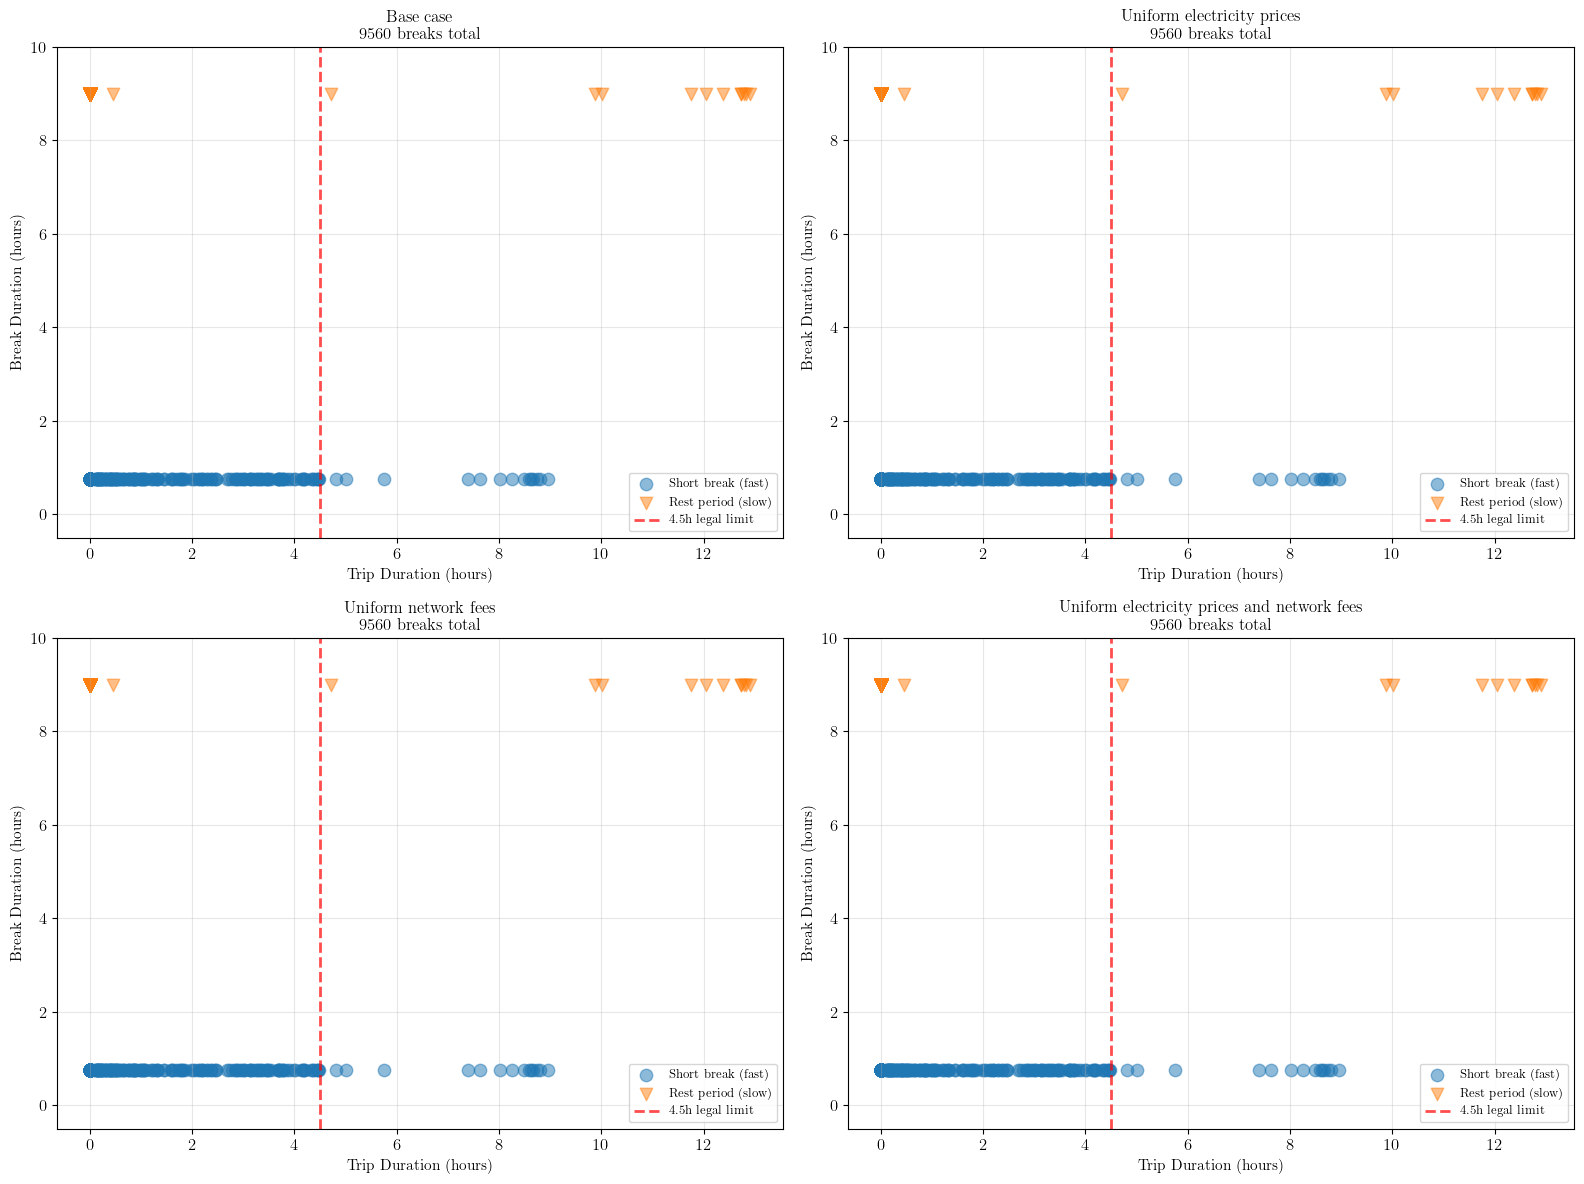

In [ ]:
from analyze_mandatory_breaks_all_cases import analyze_mandatory_breaks_for_all_cases

case_study_name_labels_dict = {
    "case_20251030_113213_var_var": "Base case",
    "case_20251030_113248_var_uni": "Uniform electricity prices",
    "case_20251030_113325_uni_var": "Uniform network fees",
    "case_20251030_113500_uni_uni": "Uniform electricity prices and network fees"
}

fig, stats = analyze_mandatory_breaks_for_all_cases(loaded_runs, case_study_name_labels_dict)
plt.savefig('figures/mandatory_breaks_all_cases.png', dpi=300, bbox_inches='tight')
plt.show()